# This notebook 

In [1]:
import numpy as np
import pandas as pd
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt

In [2]:
import gvar as gv
import h5py
import lsqfit
import h5data_methods as h5_dm

In [3]:
import pickle

## Define methods and constants

In [4]:
# Constants

#Physical constants
hbarc = 197.3 # MeV fm
a = 0.12

# Pion mass
mpi = 0.1885
#mpi = 0.2

# Plot constants
t_min_plt = 1
t_max_plt = 25

# Array of tsep values
tsep_vals = np.arange(3,13,1)
tsep_vals

array([ 3,  4,  5,  6,  7,  8,  9, 10, 11, 12])

In [5]:
def Ei(n_selec, p):
    Ea = p['E0']
    for l in range(1, n_selec+1):
        Ea += p['dE{}'.format(l)]
        
    #print(Ea)
    return Ea

In [6]:
data = gv.BufferDict()
data['2pt'] = h5_dm.get_2pt("a12m310_a_avg.h5")
data['2pt_SS'] = data['2pt'][:,:,0]
data['2pt_PS'] = data['2pt'][:,:,1]
data['3pt_A3'] = h5_dm.get_3pt("a12m310_a_avg.h5", "A3", 3, 13)
data['3pt_V4'] = h5_dm.get_3pt("a12m310_a_avg.h5", "V4", 3, 13)
data['FH_N_A3'] = h5_dm.get_FH("a12m310_a_fh.h5", "gA")
data['FH_N_V4'] = h5_dm.get_FH("a12m310_a_fh.h5", "gV")
data['FH_N'] = h5_dm.get_FH("a12m310_a_fh.h5", "all")

In [7]:
# The averaged-set data
gv_avg_data = gv.BufferDict()
gv_avg_data = gv.dataset.avg_data(data)

# Calculate the ratio between 3-point and 2-point data, for both A3 and V4
gv_avg_data['C_ratio_A3'] = np.array([ [gv_avg_data['3pt_A3'][i][j]/gv_avg_data['2pt_SS'][i+tsep_vals[0]] for j in range(1, i+3)] for i in range(len(tsep_vals))])
gv_avg_data['Csum_A3'] = np.array([np.sum(gv_avg_data['3pt_A3'][i][1:i+3]) for i in range(len(tsep_vals))])
gv_avg_data['C^FH_A3'] = np.array([ (gv_avg_data['Csum_A3'][i + 1]/gv_avg_data['2pt_SS'][i + tsep_vals[0] + 1]) - (gv_avg_data['Csum_A3'][i]/gv_avg_data['2pt_SS'][i + tsep_vals[0]]) for i in range(len(tsep_vals)-1)])

gv_avg_data['C_ratio_V4'] = np.array([ [gv_avg_data['3pt_V4'][i][j]/gv_avg_data['2pt_SS'][i+tsep_vals[0]] for j in range(1, i+3)] for i in range(len(tsep_vals))])
gv_avg_data['Csum_V4'] = np.array([np.sum(gv_avg_data['3pt_V4'][i][1:i+3]) for i in range(len(tsep_vals))])
gv_avg_data['C^FH_V4'] = np.array([ (gv_avg_data['Csum_V4'][i + 1]/gv_avg_data['2pt_SS'][i + tsep_vals[0] + 1]) - (gv_avg_data['Csum_V4'][i]/gv_avg_data['2pt_SS'][i + tsep_vals[0]]) for i in range(len(tsep_vals)-1)])

# The A3 and V4 3-point and sum-subtracted samples are combined into arrays of (A3, V4) pairs 
gv_avg_data['3pt_combined'] = np.array([ [ [gv_avg_data['3pt_A3'][i][j], gv_avg_data['3pt_V4'][i][j]] for j in range(len(gv_avg_data['3pt_A3'][i]))] for i in range(len(gv_avg_data['3pt_A3']))])
gv_avg_data['C^FH_combined'] = np.transpose(np.append([gv_avg_data['C^FH_A3'],], [gv_avg_data['C^FH_V4'],], axis = 0))

# Sum-subtract the Feynman-Hellman raw data to get a FH dataset
gv_avg_data['2pt_D'] = np.transpose(np.array([gv_avg_data['2pt_SS'], gv_avg_data['2pt_PS'], gv_avg_data['2pt_SS'], gv_avg_data['2pt_PS']]))
gv_avg_data['FH'] = np.roll(gv_avg_data['FH_N']/gv_avg_data['2pt_D'], -1, axis = 0) - gv_avg_data['FH_N']/gv_avg_data['2pt_D']

In [8]:
def param_FH(p):
    sub_p = gv.BufferDict()
    sub_p['E0'] = p['E0']
    sub_p['Z0'] = p['Z0']
    
    for k in range(1, num_states_FH - 1):
        sub_p['Z{}'.format(k)] = p['Z{}'.format(k)]
        sub_p['log(dE{})'.format(k)] = p['log(dE{})'.format(k)]
        
    sub_p['Z{}'.format(num_states_FH - 1)] = p['Z_FHmax']
    sub_p['log(dE{})'.format(num_states_FH - 1)] = p['log(FH_dEmax)']
    
    for n in range(num_states_FH-1):
        for m in range(num_states_FH-1):
                
            sub_p['gA3_{0}{1}'.format(n, m)] = p['gA3_{0}{1}'.format(n, m)]
            sub_p['gV4_{0}{1}'.format(n, m)] = p['gV4_{0}{1}'.format(n, m)]
            
    for n in range(num_states_FH-1):
        sub_p['gA3_{0}{1}'.format(n, num_states_FH-1)] = p['gA3_{}FHmax'.format(n)]
        sub_p['gA3_{0}{1}'.format(num_states_FH-1, n)] = p['gA3_FHmax{}'.format(n)]
        sub_p['gV4_{0}{1}'.format(n, num_states_FH-1)] = p['gV4_{}FHmax'.format(n)]
        sub_p['gV4_{0}{1}'.format(num_states_FH-1, n)] = p['gV4_FHmax{}'.format(n)]
        
    sub_p['gA3_{0}{1}'.format(num_states_FH-1, num_states_FH-1)] = p['gA3_FHmaxFHmax']
    sub_p['gV4_{0}{1}'.format(num_states_FH-1, num_states_FH-1)] = p['gV4_FHmaxFHmax']
    
    return sub_p

def param_FHdata(p):
    sub_p = gv.BufferDict()
    sub_p['E0'] = p['E0']
    sub_p['Z0'] = p['Z0']
    sub_p['Ztilde0'] = p['Ztilde0']
    
    for k in range(1, num_states_FH - 1):
        sub_p['Z{}'.format(k)] = p['Z{}'.format(k)]
        sub_p['Ztilde{}'.format(k)] = p['Ztilde{}'.format(k)]
        sub_p['log(dE{})'.format(k)] = p['log(dE{})'.format(k)]
        
    sub_p['Z{}'.format(num_states_FH - 1)] = p['Z_FHmax']
    sub_p['Ztilde{}'.format(num_states_FH - 1)] = p['Ztilde_FHmax']
    sub_p['log(dE{})'.format(num_states_FH - 1)] = p['log(FH_dEmax)']
    
    for n in range(num_states_FH-1):
        for m in range(num_states_FH-1):
                
            sub_p['gA3_{0}{1}'.format(n, m)] = p['gA3_{0}{1}'.format(n, m)]
            sub_p['gV4_{0}{1}'.format(n, m)] = p['gV4_{0}{1}'.format(n, m)]
            
    for n in range(num_states_FH-1):
        sub_p['gA3_{0}{1}'.format(n, num_states_FH-1)] = p['gA3_{}FHmax'.format(n)]
        sub_p['gA3_{0}{1}'.format(num_states_FH-1, n)] = p['gA3_FHmax{}'.format(n)]
        sub_p['gV4_{0}{1}'.format(n, num_states_FH-1)] = p['gV4_{}FHmax'.format(n)]
        sub_p['gV4_{0}{1}'.format(num_states_FH-1, n)] = p['gV4_FHmax{}'.format(n)]
        
    sub_p['gA3_{0}{1}'.format(num_states_FH-1, num_states_FH-1)] = p['gA3_FHmaxFHmax']
    sub_p['gV4_{0}{1}'.format(num_states_FH-1, num_states_FH-1)] = p['gV4_FHmaxFHmax']
    
    for n in range(num_states_FH):
        sub_p['d_gA_ss_{}'.format(n)] = p['d_gA_ss_{}'.format(n)]
        sub_p['d_gA_ps_{}'.format(n)] = p['d_gA_ps_{}'.format(n)]
        sub_p['d_gV_ss_{}'.format(n)] = p['d_gV_ss_{}'.format(n)]
        sub_p['d_gV_ps_{}'.format(n)] = p['d_gV_ps_{}'.format(n)]
    
    return sub_p

In [9]:
num_zs = 1 #Order number of the n's
# Log E: log of the energy.  
# P is point (in the context of )

def C_2pt(t, p):
    
    z = np.array([])
    ztilde = np.array([])
    E = np.array([])
    for i in range(num_zs):
        z = np.append(z, p['Z{}'.format(i)])
        ztilde = np.append(ztilde, p['Ztilde{}'.format(i)])
        E = np.append(E, Ei(i, p))
        
    
    sum_pp = sum([z[i]*z[i]*np.exp(-E[i]*t) for i in range(num_zs)])
    sum_ps = sum([z[i]*ztilde[i]*np.exp(-E[i]*t) for i in range(num_zs)])
    
    return np.transpose(np.array([[sum_pp], [sum_ps]]), axes=[2,0,1])

def C_2pt_SS(t, p):
    
    z = np.array([])
    E = np.array([])
    for i in range(num_zs):
        z = np.append(z, p['Z{}'.format(i)])
        E = np.append(E, Ei(i, p))
        
    
    sum_ss = sum([z[i]*z[i]*np.exp(-E[i]*t) for i in range(num_zs)])
    
    return np.array(sum_ss)

def C_2pt_PS(t, p):
    
    z = np.array([])
    ztilde = np.array([])
    E = np.array([])
    for i in range(num_zs):
        z = np.append(z, p['Z{}'.format(i)])
        ztilde = np.append(ztilde, p['Ztilde{}'.format(i)])
        E = np.append(E, Ei(i, p))
        
    #print("z: ", z)
    #print("ztilde: ", ztilde)
    
    sum_ps = sum([z[i]*ztilde[i]*np.exp(-E[i]*t) for i in range(num_zs)])
    
    return np.array(sum_ps)

In [10]:
# Precondition: t is a 1-D numpy array of 2-element array like objects t[i] = (t_sep, tau)
  
    
def C_3pt_A3(t, p):
    #tsep = np.array([np.array([t[i][j][0] for j in range(len(t[i]))]) for i in range(len(t))])
    #tau = np.array([np.array([t[i][j][1] for j in range(len(t[i]))]) for i in range(len(t))])
    tsep, tau = np.transpose(t)
    #print("tsep: ", tsep)
    #print("tau: ", tau)
    
    result = p['Z0']*p['gA3_00']*p['Z0']*np.exp(-p["E0"]*tsep)*np.exp(-(p["E0"] - p["E0"])*tau)
    n = 0
    m = 0
    
    if num_zs == 1:
        return result
    
    m += 1
    while n < num_zs:    
        En = Ei(n, p)
        Em = Ei(m, p) 
        result += p['Z{}'.format(n)]*p['gA3_{0}{1}'.format(n, m)]*p['Z{}'.format(m)]*np.exp(-En*tsep)*np.exp(-(Em - En)*tau)
        m += 1
        if m >= num_zs:
            m = 0
            n += 1
            
    #for n in range(num_zs):
        #for m in range(num_zs):
            #result += p['Z{}'.format(n)]*p['gA3_{0}{1}'.format(n, m)]*p['Z{}'.format(m)]*np.exp(-p["E{}".format(n)]*tsep)*np.exp(-(p["E{}".format(m)] - p["E{}".format(n)])*tau)
            # print out the dictionary indices which are called in this summation
            #print("n = ", n, "; m = ", m)
            #print('Z{}'.format(n), "*", 'gA3_{0}{1}'.format(n, m), "*", 'Z{}'.format(m), "*e^(-tsep*", "E{}".format(n), ")*e^(-tau*(", "E{}".format(m), "-", "E{}".format(n), ")")
            
    return result



def C_3pt_V4(t, p):
    #tsep = np.array([np.array([t[i][j][0] for j in range(len(t[i]))]) for i in range(len(t))])
    #tau = np.array([np.array([t[i][j][1] for j in range(len(t[i]))]) for i in range(len(t))])
    tsep, tau = np.transpose(t)
    #print("tsep: ", tsep)
    #print("tau: ", tau)
    
    result = p['Z0']*p['gV4_00']*p['Z0']*np.exp(-p["E0"]*tsep)*np.exp(-(p["E0"] - p["E0"])*tau)
    
    n = 0
    m = 0
    if num_zs == 1:
        return result
    
    m += 1
    while n < num_zs:
        En = Ei(n, p)
        Em = Ei(m, p)
        result += p['Z{}'.format(n)]*p['gV4_{0}{1}'.format(n, m)]*p['Z{}'.format(m)]*np.exp(-En*tsep)*np.exp(-(Em - En)*tau)
        m += 1
        if m >= num_zs:
            m = 0
            n += 1
    
    
    #for n in range(num_zs):
        #for m in range(num_zs):
            #result += p['Z{}'.format(n)]*p['gV4_{0}{1}'.format(n, m)]*p['Z{}'.format(m)]*np.exp(-p["E{}".format(n)]*tsep)*np.exp(-(p["E{}".format(m)] - p["E{}".format(n)])*tau)
            # print out the dictionary indices which are called in this summation
            #print("n = ", n, "; m = ", m)
            #print('Z{}'.format(n), "*", 'gV4_{0}{1}'.format(n, m), "*", 'Z{}'.format(m), "*e^(-tsep*", "E{}".format(n), ")*e^(-tau*(", "E{}".format(m), "-", "E{}".format(n), ")")
            
    return result

def C_3pt(t, p):
    A3 = C_3pt_A3(t, p)
    V4 = C_3pt_V4(t, p)
    
    return np.transpose(np.array([[A3], [V4]]), axes=[2,0,1])

In [11]:
num_states_FH = 1 # The number of states that the sum-subtraction and Feynman-Hellman data needs

def C_2pt_SS_aux(t, p, n_local):
    
    z = np.array([])
    E = np.array([])
    for i in range(n_local):
        z = np.append(z, p['Z{}'.format(i)])
        E = np.append(E, Ei(i, p))
        
    
    sum_ss = sum([z[i]*z[i]*np.exp(-E[i]*t) for i in range(n_local)])
    
    return np.array(sum_ss)

def C_2pt_PS_aux(t, p, n_local):
    
    z = np.array([])
    ztilde = np.array([])
    E = np.array([])
    for i in range(n_local):
        z = np.append(z, p['Z{}'.format(i)])
        ztilde = np.append(ztilde, p['Ztilde{}'.format(i)])
        E = np.append(E, Ei(i, p))
        
    #print("z: ", z)
    #print("ztilde: ", ztilde)
    
    sum_ps = sum([z[i]*ztilde[i]*np.exp(-E[i]*t) for i in range(n_local)])
    
    return np.array(sum_ps)

def Csum_A3(t, p, n_local):
    result = 0
    for n in range(n_local):
        En = Ei(n, p)
        result += (t - 1) * p['Z{}'.format(n)]*p['gA3_{0}{1}'.format(n, n)]*p['Z{}'.format(n)]*np.exp(-En*t)
        for m in range(n_local):
            if n == m:
                continue
            else:
                Em = Ei(m, p)
                e_Delta_nm = np.exp((En - Em)/2.)
                e_Delta_mn = np.exp((Em - En)/2.)
                #print("n = ", n)
                #print("m = ", m)
                #print("En = ", En)
                #print("Em = ", Em)
                #print("e_Delta_nm = ", e_Delta_nm)
                #print("e_Delta_nm = ", e_Delta_mn)
                
                mn_ratio = (e_Delta_nm*np.exp(-En*t) - e_Delta_mn*np.exp(-Em*t))/(e_Delta_mn - e_Delta_nm)
                
                result += p['Z{}'.format(n)]*p['gA3_{0}{1}'.format(n, m)]*p['Z{}'.format(m)]*mn_ratio
                
    return result

def Csum_V4(t, p, n_local):
    result = 0
    for n in range(n_local):
        En = Ei(n, p)
        result += (t - 1) * p['Z{}'.format(n)]*p['gV4_{0}{1}'.format(n, n)]*p['Z{}'.format(n)]*np.exp(-En*t)
        for m in range(n_local):
            if n == m:
                continue
            else:
                Em = Ei(m, p)
                e_Delta_nm = np.exp((En - Em)/2.)
                e_Delta_mn = np.exp((Em - En)/2.)
                
                mn_ratio = (e_Delta_nm*np.exp(-En*t) - e_Delta_mn*np.exp(-Em*t))/(e_Delta_mn - e_Delta_nm)
                
                result += p['Z{}'.format(n)]*p['gV4_{0}{1}'.format(n, m)]*p['Z{}'.format(m)]*mn_ratio
                
    return result

def C_FH_A3(t, p):
    #p_FH = gv.BufferDict()
    #p_FH['E0'] = p['E0']
    
    #n = 0
    #while (n < num_states_FH):
        #p_FH['Z{}'.format(n)] = p['Z{}'.format(n)]
        #for m in range(num_states_FH):
            #p_FH['gA3_{0}{1}'.format(n, m)] = p['gA3_{0}{1}'.format(n, m)]
            
        #n += 1
        
    
    #nE = 0
    #while nE < num_states_FH - 2:
        #p_FH['log(dE{})'.format(nE)] = p['log(dE{})'.format(nE)]
        #nE += 1
        
    #p_FH['log(dE{})'.format(nE)] = p['log(FH_dEmax)']
    if(num_zs == num_states_FH):
        return (Csum_A3(t + 1, p, num_states_FH)/C_2pt_SS_aux(t + 1, p, num_states_FH)) - (Csum_A3(t, p, num_states_FH)/C_2pt_SS_aux(t, p, num_states_FH))

    else:
        return (Csum_A3(t + 1, param_FH(p), num_states_FH)/C_2pt_SS_aux(t + 1, param_FH(p), num_states_FH)) - (Csum_A3(t, param_FH(p), num_states_FH)/C_2pt_SS_aux(t, param_FH(p), num_states_FH))


def C_FH_V4(t, p):
    #p_FH = gv.BufferDict()
    #p_FH['E0'] = p['E0']
    
    #for n in range(num_states_FH):
        #p_FH['Z{}'.format(n)] = p['Z{}'.format(n)]
        #for m in range(num_states_FH):
            #p_FH['gV4_{0}{1}'.format(n, m)] = p['gV4_{0}{1}'.format(n, m)]
    
    #nE = 0
    #while nE < num_states_FH - 2:
        #p_FH['log(dE{})'.format(nE)] = p['log(dE{})'.format(nE)]
        #nE += 1
        
    #p_FH['log(dE{})'.format(nE)] = p['log(FH_dEmax)']
    
    if(num_zs == num_states_FH):
        return (Csum_V4(t + 1, p, num_states_FH)/C_2pt_SS_aux(t + 1, p, num_states_FH)) - (Csum_V4(t, p, num_states_FH)/C_2pt_SS_aux(t, p, num_states_FH))

    else:
        return (Csum_V4(t + 1, param_FH(p), num_states_FH)/C_2pt_SS_aux(t + 1, param_FH(p), num_states_FH)) - (Csum_V4(t, param_FH(p), num_states_FH)/C_2pt_SS_aux(t, param_FH(p), num_states_FH))




def C_FH(t, p):
    return np.transpose(np.array([C_FH_A3(t, p), C_FH_V4(t, p)])) #, axes=[2,0,1]

In [12]:
# Create new functions to fit the new Feynman-Hellman dataset to 
def Csum_A3_FHdata_ss(t, p, n_local):
    result = 0
    for n in range(n_local):
        En = Ei(n, p)
        result += ((t - 1) * p['Z{}'.format(n)]*p['gA3_{0}{1}'.format(n, n)]*p['Z{}'.format(n)] + p['d_gA_ss_{}'.format(n)])*np.exp(-En*t)
        for m in range(n_local):
            if n == m:
                continue
            else:
                Em = Ei(m, p)
                e_Delta_nm = np.exp((En - Em)/2.)
                e_Delta_mn = np.exp((Em - En)/2.)
                
                mn_ratio = (e_Delta_nm*np.exp(-En*t) - e_Delta_mn*np.exp(-Em*t))/(e_Delta_mn - e_Delta_nm)
                
                result += p['Z{}'.format(n)]*p['gA3_{0}{1}'.format(n, m)]*p['Z{}'.format(m)]*mn_ratio
                
    return result

def Csum_A3_FHdata_ps(t, p, n_local):
    result = 0
    for n in range(n_local):
        En = Ei(n, p)
        result += ((t - 1) * p['Z{}'.format(n)]*p['gA3_{0}{1}'.format(n, n)]*p['Ztilde{}'.format(n)] + p['d_gA_ps_{}'.format(n)])*np.exp(-En*t)
        for m in range(n_local):
            if n == m:
                continue
            else:
                Em = Ei(m, p)
                e_Delta_nm = np.exp((En - Em)/2.)
                e_Delta_mn = np.exp((Em - En)/2.)
                
                mn_ratio = (e_Delta_nm*np.exp(-En*t) - e_Delta_mn*np.exp(-Em*t))/(e_Delta_mn - e_Delta_nm)
                
                result += p['Z{}'.format(n)]*p['gA3_{0}{1}'.format(n, m)]*p['Ztilde{}'.format(m)]*mn_ratio
                
    return result

def Csum_V4_FHdata_ss(t, p, n_local):
    result = 0
    for n in range(n_local):
        En = Ei(n, p)
        result += ((t - 1) * p['Z{}'.format(n)]*p['gV4_{0}{1}'.format(n, n)]*p['Z{}'.format(n)] + p['d_gV_ss_{}'.format(n)])*np.exp(-En*t)
        for m in range(n_local):
            if n == m:
                continue
            else:
                Em = Ei(m, p)
                e_Delta_nm = np.exp((En - Em)/2.)
                e_Delta_mn = np.exp((Em - En)/2.)
                
                mn_ratio = (e_Delta_nm*np.exp(-En*t) - e_Delta_mn*np.exp(-Em*t))/(e_Delta_mn - e_Delta_nm)
                
                result += p['Z{}'.format(n)]*p['gV4_{0}{1}'.format(n, m)]*p['Z{}'.format(m)]*mn_ratio
                
    return result

def Csum_V4_FHdata_ps(t, p, n_local):
    result = 0
    for n in range(n_local):
        En = Ei(n, p)
        result += ((t - 1) * p['Z{}'.format(n)]*p['gV4_{0}{1}'.format(n, n)]*p['Ztilde{}'.format(n)] + p['d_gV_ps_{}'.format(n)])*np.exp(-En*t)
        for m in range(n_local):
            if n == m:
                continue
            else:
                Em = Ei(m, p)
                e_Delta_nm = np.exp((En - Em)/2.)
                e_Delta_mn = np.exp((Em - En)/2.)
                
                mn_ratio = (e_Delta_nm*np.exp(-En*t) - e_Delta_mn*np.exp(-Em*t))/(e_Delta_mn - e_Delta_nm)
                
                result += p['Z{}'.format(n)]*p['gV4_{0}{1}'.format(n, m)]*p['Ztilde{}'.format(m)]*mn_ratio
                
    return result

def C_FHdata_A3_ss(t, p):
    if(num_zs == num_states_FH):
        return (Csum_A3_FHdata_ss(t + 1, p, num_states_FH)/C_2pt_SS_aux(t + 1, p, num_states_FH)) - (Csum_A3_FHdata_ss(t, p, num_states_FH)/C_2pt_SS_aux(t, p, num_states_FH))

    else:
        return (Csum_A3_FHdata_ss(t + 1, param_FHdata(p), num_states_FH)/C_2pt_SS_aux(t + 1, param_FHdata(p), num_states_FH)) - (Csum_A3_FHdata_ss(t, param_FHdata(p), num_states_FH)/C_2pt_SS_aux(t, param_FHdata(p), num_states_FH))

def C_FHdata_A3_ps(t, p):
    if(num_zs == num_states_FH):
        return (Csum_A3_FHdata_ps(t + 1, p, num_states_FH)/C_2pt_PS_aux(t + 1, p, num_states_FH)) - (Csum_A3_FHdata_ps(t, p, num_states_FH)/C_2pt_PS_aux(t, p, num_states_FH))

    else:
        return (Csum_A3_FHdata_ps(t + 1, param_FHdata(p), num_states_FH)/C_2pt_PS_aux(t + 1, param_FHdata(p), num_states_FH)) - (Csum_A3_FHdata_ps(t, param_FHdata(p), num_states_FH)/C_2pt_PS_aux(t, param_FHdata(p), num_states_FH))


def C_FHdata_V4_ss(t, p):  
    if(num_zs == num_states_FH):
        return (Csum_V4_FHdata_ss(t + 1, p, num_states_FH)/C_2pt_SS_aux(t + 1, p, num_states_FH)) - (Csum_V4_FHdata_ss(t, p, num_states_FH)/C_2pt_SS_aux(t, p, num_states_FH))

    else:
        return (Csum_V4_FHdata_ss(t + 1, param_FHdata(p), num_states_FH)/C_2pt_SS_aux(t + 1, param_FHdata(p), num_states_FH)) - (Csum_V4_FHdata_ss(t, param_FHdata(p), num_states_FH)/C_2pt_SS_aux(t, param_FHdata(p), num_states_FH))

def C_FHdata_V4_ps(t, p):
    if(num_zs == num_states_FH):
        return (Csum_V4_FHdata_ps(t + 1, p, num_states_FH)/C_2pt_PS_aux(t + 1, p, num_states_FH)) - (Csum_V4_FHdata_ps(t, p, num_states_FH)/C_2pt_PS_aux(t, p, num_states_FH))

    else:
        return (Csum_V4_FHdata_ps(t + 1, param_FHdata(p), num_states_FH)/C_2pt_PS_aux(t + 1, param_FHdata(p), num_states_FH)) - (Csum_V4_FHdata_ps(t, param_FHdata(p), num_states_FH)/C_2pt_PS_aux(t, param_FHdata(p), num_states_FH))




def C_FHdata(t, p):
    return np.transpose(np.array([C_FHdata_A3_ss(t, p), C_FHdata_A3_ps(t, p), C_FHdata_V4_ss(t, p), C_FHdata_V4_ps(t, p)])) #, axes=[2,0,1]

#### All functions to which data is fitted have been created, now create functions for switching between 2-d arrays (for direct data-handling and plotting) and 1-d arrays for function output and fitting

In [13]:
# In order to be able to work with our 2-d array based functions, we need a way to convert from 2-d array to 1-d arrays and from 1-d arrays to 2-d arrays
# For the independent (time) variable, I'd just set up a 2-d array and a 1-d array with all the data I need
# For the dependent (correlation function) variable, I'd use the time variable arrays to call the correct indices to assign the variables in the conversion
t_2d_array = np.array([np.array([(i+3, j) for j in range(1, i+tsep_vals[0])]) for i in range(len(tsep_vals))])

num_elements = np.sum(np.array([i+tsep_vals[0]-1 for i in range(len(tsep_vals))]))
tsep_t = np.zeros(num_elements)
tau_t = np.zeros(num_elements)

k = 0
for i in range(len(tsep_vals)):
    for j in range(1, i+tsep_vals[0]):
        tsep_t[k] = i + tsep_vals[0]
        tau_t[k] = j
        #print("k = ", k, " tsep = ", tsep_t[k], " tau = ", tau_t[k])
        k += 1

        
t_1d_array = np.transpose(np.array([tsep_t, tau_t])) 

#print(t_2d_array)
#print(t_1d_array)

# Universal precondition for the below functions: x_1d, x_2d, y_1d, and y_2d, in the end, must have the 
# same number of elements. Also, x_1d and y_1d have to have the same dimensions, as must x_2d and y_2d
def convert_1dto2d(x_1d, x_2d, y_1d):
    y_2d = np.array([np.array([None for j in range(len(x_2d[i]))]) for i in range(len(x_2d))])
    i = 0
    j = 0
    for k in range(len(x_1d)):
        y_2d[i][j] = y_1d[k]
        j += 1
        if j >= len(x_2d[i]):
            i +=1
            j = 0
            
    return y_2d

def convert_2dto1d(x_1d, x_2d, y_2d):
    y_1d = np.array([None for k in range(len(x_1d))])
    k = 0
    for i in range(len(x_2d)):
        for j in range(len(x_2d[i])):
            y_1d[k] = y_2d[i][j]
            k += 1
    
    return y_1d



#### Fit the sum-subtracted and the 3-point functions separately

In [14]:

num_zs = 2
num_states_FH = 2

# prior the fits
tp = gv.BufferDict()

# This is the exponent e_decay_exp such that the increment between two consecutive excited state energies decays as 1/n^e_decay_exp, where n is the order of the excited state energy 
e_decay_exp = 0

tp['E0'] = gv.gvar(0.67, 0.02)
tp['Z0'] = gv.gvar(0.0008, 0.0003)
#tp['Ztilde0'] = gv.gvar(0.003, 0.003)

# Define some constants for prioring the higher-order energies
dE0 = 2*mpi
b = 0.7

# Use constant dE to prior the energies
dE0 = 2*mpi
energyvals = np.array([None]*num_states_FH)
dEvals = np.array([None]*(num_states_FH - 1))

energyvals[0] = tp['E0'].mean
for k in range(1, num_zs):
    dEvals[k-1] = dE0/np.power(k, e_decay_exp)
    energyvals[k] = energyvals[k-1] + dEvals[k-1]

for n in range(1, num_zs): #num_zs
    tp['Z{}'.format(n)] = gv.gvar(0.0012, 0.0006)
    #tp['Ztilde{}'.format(n)] = gv.gvar(0, 0.01)
    
    tp['log(dE{})'.format(n)] = gv.gvar(np.log(dEvals[n-1]), b)
    
# Set the "garbage can" for the Feynman Hellman fit
tp['log(FH_dEmax)'] = gv.gvar(np.log(dEvals[num_states_FH - 2]), b) 
tp['Z_FHmax'] = gv.gvar(0.0008, 0.0004)

for n in range(num_zs):
    for m in range(num_zs):
        
        tp['gA3_{0}{1}'.format(n, m)] = gv.gvar(1, 2)
        if n == m and n < num_zs-1:
            tp['gV4_{0}{1}'.format(n, m)] = gv.gvar(1, 0.1)
        else:
            tp['gV4_{0}{1}'.format(n, m)] = gv.gvar(0, 2)

tp['gA3_00'] = gv.gvar(1.25, 0.15)
tp['gV4_00'] = gv.gvar(1.07, 0.07)

tp['gA3_FHmaxFHmax'] = gv.gvar(1, 2)
tp['gV4_FHmaxFHmax'] = gv.gvar(0, 2)

for n in range(num_states_FH-1):
    tp['gA3_FHmax{}'.format(n)] = gv.gvar(1, 2)
    tp['gA3_{}FHmax'.format(n)] = gv.gvar(1, 2)
    tp['gV4_FHmax{}'.format(n)] = gv.gvar(0, 2)
    tp['gV4_{}FHmax'.format(n)] = gv.gvar(0, 2)


In [15]:
#y_sample = C_FH(fit_CFH_test.x, fit_CFH_test.p)

fit_CFH_test = lsqfit.nonlinear_fit(data=(np.array([l for l in tsep_vals[:-1]]), np.array([gv_avg_data['C^FH_combined'][l] for l in range(len(tsep_vals[:-1]))])), prior=tp,fcn=C_FH,debug=True)
print(fit_CFH_test.format(pstyle='vv'))
post_CFH = fit_CFH_test.p

Least Square Fit:
  chi2/dof [dof] = 0.4 [18]    Q = 0.99    logGBF = 46.934

Parameters:
             E0                 0.67 +- 0.02             [     0.67 +- 0.02 ]  
             Z0   0.000840404 +- 0.000291249             [ 0.0008 +- 0.0003 ]  
             Z1     0.00107348 +- 0.00055611             [ 0.0012 +- 0.0006 ]  
       log(dE1)         -0.516397 +- 0.40528             [  -0.97551 +- 0.7 ]  
  log(FH_dEmax)              -0.97551 +- 0.7             [  -0.97551 +- 0.7 ]  
        Z_FHmax             0.0008 +- 0.0004             [ 0.0008 +- 0.0004 ]  
         gA3_00         1.25348 +- 0.0244262             [     1.25 +- 0.15 ]  
         gV4_00         1.02285 +- 0.0176248             [     1.07 +- 0.07 ]  
         gA3_01         -0.155265 +- 1.41775             [           1 +- 2 ]  
         gV4_01         0.0383234 +- 1.41636             [           0 +- 2 ]  
         gA3_10         -0.155265 +- 1.41775             [           1 +- 2 ]  
         gV4_10         0.0383

In [16]:
final_posterior = open("FH_individual_out.obj", 'wb')
pickle.dump(post_CFH, final_posterior)
final_posterior.close()

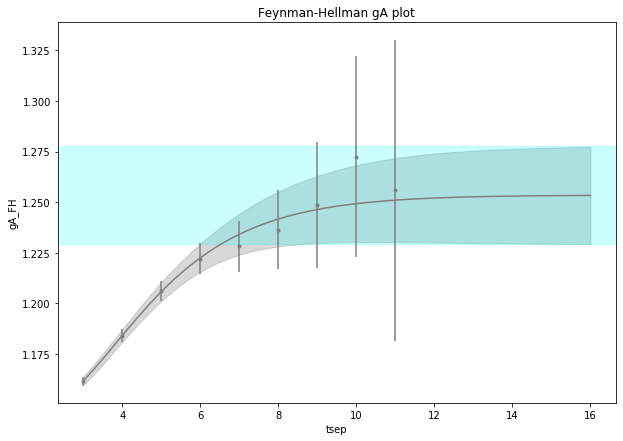

<Figure size 432x288 with 0 Axes>

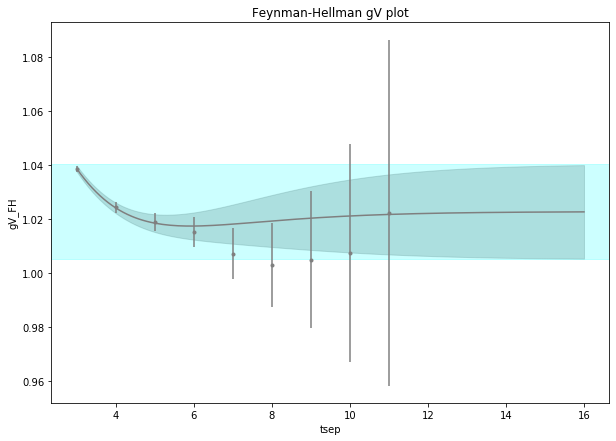

<Figure size 432x288 with 0 Axes>

In [17]:
# And finally, plot the sum-subtracted fit functions
step_FH = 10

# Set up the fit plotting
t_FH_model = np.linspace(tsep_vals[0], tsep_vals[-1]+4, (tsep_vals[-1]+4 - tsep_vals[0])*step_FH + 1)

#CFH_A3_model = C_FH_A3(t_FH_model, post_CFHV4)
#CFH_V4_model = C_FH_V4(t_FH_model, post_CFHV4)
CFH_A3_model = C_FH_A3(t_FH_model, post_CFH)
CFH_V4_model = C_FH_V4(t_FH_model, post_CFH)

CFH_A3_model_mean = np.array([CFH_A3_model[i].mean for i in range(len(CFH_A3_model))])
CFH_A3_model_upbound = np.array([CFH_A3_model[i].mean + CFH_A3_model[i].sdev for i in range(len(CFH_A3_model))])
CFH_A3_model_lowbound = np.array([CFH_A3_model[i].mean - CFH_A3_model[i].sdev for i in range(len(CFH_A3_model))])
CFH_V4_model_mean = np.array([CFH_V4_model[i].mean for i in range(len(CFH_V4_model))])
CFH_V4_model_upbound = np.array([CFH_V4_model[i].mean + CFH_V4_model[i].sdev for i in range(len(CFH_V4_model))])
CFH_V4_model_lowbound = np.array([CFH_V4_model[i].mean - CFH_V4_model[i].sdev for i in range(len(CFH_V4_model))])

# Set up the raw data plotting
x_CFH = np.array([i for i in tsep_vals[:-1] ])
y_CFH_A3 = np.array([gv_avg_data['C^FH_A3'][i].mean for i in range(len(tsep_vals)-1)])
y_CFH_A3_err = np.array([gv_avg_data['C^FH_A3'][i].sdev for i in range(len(tsep_vals)-1)])
y_CFH_V4 = np.array([gv_avg_data['C^FH_V4'][i].mean for i in range(len(tsep_vals)-1)])
y_CFH_V4_err = np.array([gv_avg_data['C^FH_V4'][i].sdev for i in range(len(tsep_vals)-1)])

#h5_dm.fit_data_plot("Sum-subtracted gA plot", "tsep", "gA_FH", x_CFH, y_CFH_A3, t_FH_model, CFH_A3_model_mean, CFH_A3_model_upbound, CFH_A3_model_lowbound, "tab:grey", g00 = post_CFHV4['gA3_00'], ydat_error=y_CFH_A3_err) 
#h5_dm.fit_data_plot("Sum-subtracted gV plot", "tsep", "gV_FH", x_CFH, y_CFH_V4, t_FH_model, CFH_V4_model_mean, CFH_V4_model_upbound, CFH_V4_model_lowbound, "tab:grey", g00 = post_CFHV4['gV4_00'], ydat_error=y_CFH_V4_err)

h5_dm.fit_data_plot("Sum-subtracted gA plot", "tsep", "gA_FH", x_CFH, y_CFH_A3, t_FH_model, CFH_A3_model_mean, CFH_A3_model_upbound, CFH_A3_model_lowbound, "tab:grey", g00 = post_CFH['gA3_00'], ydat_error=y_CFH_A3_err) 
h5_dm.fit_data_plot("Sum-subtracted gV plot", "tsep", "gV_FH", x_CFH, y_CFH_V4, t_FH_model, CFH_V4_model_mean, CFH_V4_model_upbound, CFH_V4_model_lowbound, "tab:grey", g00 = post_CFH['gV4_00'], ydat_error=y_CFH_V4_err)



In [22]:
# Try fitting the 3-point fit individually

num_zs = 7
#num_states_FH = 2

# prior the fits
tp = gv.BufferDict()

# This is the exponent e_decay_exp such that the increment between two consecutive excited state energies decays as 1/n^e_decay_exp, where n is the order of the excited state energy 
e_decay_exp = 0

tp['E0'] = gv.gvar(0.67, 0.02)
tp['Z0'] = gv.gvar(0.0008, 0.0003)

# Define some constants for prioring the higher-order energies
dE0 = 2*mpi
b = 0.7

# Use constant dE to prior the energies
dE0 = 2*mpi
energyvals = np.array([None]*num_zs)
dEvals = np.array([None]*(num_zs - 1))

energyvals[0] = tp['E0'].mean
for k in range(1, num_zs):
    dEvals[k-1] = dE0/np.power(k, e_decay_exp)
    energyvals[k] = energyvals[k-1] + dEvals[k-1]

for n in range(1, num_zs): #num_zs
    tp['Z{}'.format(n)] = gv.gvar(0.0012, 0.0006)
    #tp['Ztilde{}'.format(n)] = gv.gvar(0, 0.01)
    
    tp['log(dE{})'.format(n)] = gv.gvar(np.log(dEvals[n-1]), b)

for n in range(num_zs): #num_zs
    for m in range(num_zs): #num_zs
        
        tp['gA3_{0}{1}'.format(n, m)] = gv.gvar(0, 2)
        if n == m and n < num_zs-1:
            tp['gV4_{0}{1}'.format(n, m)] = gv.gvar(1, 0.1)
        else:
            tp['gV4_{0}{1}'.format(n, m)] = gv.gvar(0, 2)

tp['gA3_00'] = gv.gvar(1.25, 0.15)
tp['gV4_00'] = gv.gvar(1.07, 0.07)




In [23]:
y_3pt_A3_2d = np.array([ [gv_avg_data['3pt_A3'][i][j] for j in range(1, i+tsep_vals[0])] for i in range(len(tsep_vals))])
y_3pt_A3 = convert_2dto1d(t_1d_array, t_2d_array, y_3pt_A3_2d)
y_3pt_V4_2d = np.array([ [gv_avg_data['3pt_V4'][i][j] for j in range(1, i+tsep_vals[0])] for i in range(len(tsep_vals))])
y_3pt_V4 = convert_2dto1d(t_1d_array, t_2d_array, y_3pt_V4_2d)

y_3pt = np.transpose(np.array([[y_3pt_A3], [y_3pt_V4]]), axes=[2,0,1])

fit_C3pt_test = lsqfit.nonlinear_fit(data=(t_1d_array, y_3pt), prior=tp,fcn=C_3pt,debug=True)
print(fit_C3pt_test.format(pstyle='vv'))
post_3pt = fit_C3pt_test.p

Least Square Fit:
  chi2/dof [dof] = 0.62 [130]    Q = 1    logGBF = 3221.6

Parameters:
             E0        0.663259 +- 0.0137898             [     0.67 +- 0.02 ]  
             Z0   0.000809029 +- 0.000137544             [ 0.0008 +- 0.0003 ]  
             Z1    0.00108472 +- 0.000445071             [ 0.0012 +- 0.0006 ]  
       log(dE1)         -2.00215 +- 0.472025             [  -0.97551 +- 0.7 ]  *
             Z2    0.00167738 +- 0.000467975             [ 0.0012 +- 0.0006 ]  
       log(dE2)         -1.76082 +- 0.506683             [  -0.97551 +- 0.7 ]  *
             Z3     0.0015801 +- 0.000450109             [ 0.0012 +- 0.0006 ]  
       log(dE3)        -0.971526 +- 0.486212             [  -0.97551 +- 0.7 ]  
             Z4    0.00145199 +- 0.000518701             [ 0.0012 +- 0.0006 ]  
       log(dE4)        -0.441695 +- 0.454205             [  -0.97551 +- 0.7 ]  
             Z5    0.00148634 +- 0.000566466             [ 0.0012 +- 0.0006 ]  
       log(dE5)        -0.245

In [24]:
final_posterior = open("3pt_individual_out.obj", 'wb')
pickle.dump(post_3pt, final_posterior)
final_posterior.close()

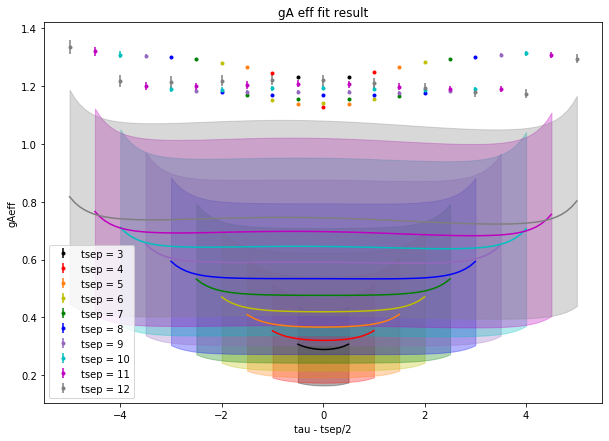

<Figure size 432x288 with 0 Axes>

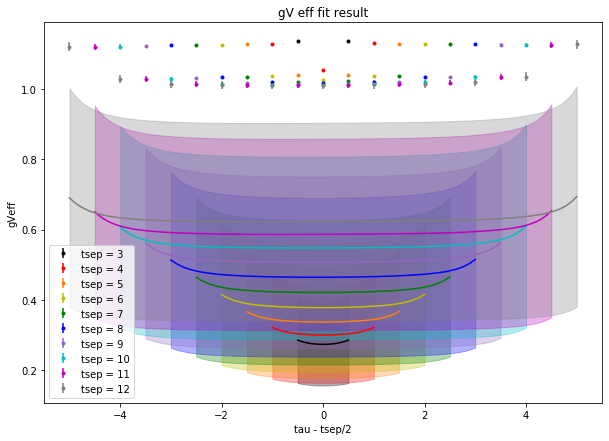

<Figure size 432x288 with 0 Axes>

In [21]:
# Now, plot out the 3-point function
# set the array of tsep, tau pairs
step_up = 10
t_min = 0
t_max = 25
tau_step = 10
legendlabels_3pt = np.array(["tsep = {}".format(i) for i in tsep_vals])

# Create 2-d and 1-d versions of the 3-point (tsep, tau) pairs
t_3pt_fitresult_2d = np.array([ np.array([ [tsep, tau] for tau in np.linspace(1, tsep - 1, (tsep - 2)*step_up +1)]) for tsep in tsep_vals])
t_3pt_fitresult_tsep = np.zeros(np.sum(np.array([len(np.linspace(1, tsep - 1, (tsep - 2)*step_up +1)) for tsep in tsep_vals])))
t_3pt_fitresult_tau = np.zeros(np.sum(np.array([len(np.linspace(1, tsep - 1, (tsep - 2)*step_up +1)) for tsep in tsep_vals])))

k = 0
for tsep in tsep_vals:
    for tau in np.linspace(1, tsep - 1, (tsep - 2)*step_up +1):
        t_3pt_fitresult_tsep[k] = tsep
        t_3pt_fitresult_tau[k] = tau
        k += 1
        
t_3pt_fitresult_1d = np.transpose(np.array([t_3pt_fitresult_tsep, t_3pt_fitresult_tau]))

# Now, calculate gA3 and gA4
model_A3_3pt_1d = C_3pt_A3(t_3pt_fitresult_1d, post_3pt)
model_V4_3pt_1d = C_3pt_V4(t_3pt_fitresult_1d, post_3pt)

# Convert to 2d
model_A3_3pt_2d = convert_1dto2d(t_3pt_fitresult_1d, t_3pt_fitresult_2d, model_A3_3pt_1d)
model_V4_3pt_2d = convert_1dto2d(t_3pt_fitresult_1d, t_3pt_fitresult_2d, model_V4_3pt_1d)

# Now, take the ratio, first take the respective 2-point function
model_ratio_2pt = C_2pt_SS(tsep_vals, post_3pt)

model_A3_ratio_2d = np.array([ np.array([ model_A3_3pt_2d[i][j]/model_ratio_2pt[i] for j in range(len(model_A3_3pt_2d[i]))]) for i in range(len(model_A3_3pt_2d))])
model_V4_ratio_2d = np.array([ np.array([ model_V4_3pt_2d[i][j]/model_ratio_2pt[i] for j in range(len(model_V4_3pt_2d[i]))]) for i in range(len(model_V4_3pt_2d))])

# Now, to prepare for plotting, split the data into mean, upper-bound and lower-bound
model_A3_ratio_2d_mean = np.array([ [ model_A3_ratio_2d[i][j].mean for j in range(len(model_A3_ratio_2d[i]))] for i in range(len(model_A3_ratio_2d)) ])
model_A3_ratio_2d_upbound = np.array([ [ model_A3_ratio_2d[i][j].mean + model_A3_ratio_2d[i][j].sdev for j in range(len(model_A3_ratio_2d[i]))] for i in range(len(model_A3_ratio_2d)) ])
model_A3_ratio_2d_lowbound = np.array([ [ model_A3_ratio_2d[i][j].mean - model_A3_ratio_2d[i][j].sdev for j in range(len(model_A3_ratio_2d[i]))] for i in range(len(model_A3_ratio_2d)) ])

model_V4_ratio_2d_mean = np.array([ [ model_V4_ratio_2d[i][j].mean for j in range(len(model_V4_ratio_2d[i]))] for i in range(len(model_V4_ratio_2d)) ])
model_V4_ratio_2d_upbound = np.array([ [ model_V4_ratio_2d[i][j].mean + model_V4_ratio_2d[i][j].sdev for j in range(len(model_V4_ratio_2d[i]))] for i in range(len(model_V4_ratio_2d)) ])
model_V4_ratio_2d_lowbound = np.array([ [ model_V4_ratio_2d[i][j].mean - model_V4_ratio_2d[i][j].sdev for j in range(len(model_V4_ratio_2d[i]))] for i in range(len(model_V4_ratio_2d)) ])

# Also, convert the 2-d tsep, tau array into an array of tau - tsep/2
t_3pt_tseptau_diff = np.array([ np.array([tau - tsep/2. for tau in np.linspace(1, tsep - 1, (tsep - 2)*step_up +1)]) for tsep in tsep_vals])

# The color pallete for plotting the 3-point correlation function
colors_3pt = np.array(['k', 'r', 'tab:orange', 'y', 'g', 'b', 'tab:purple', 'c', 'm', 'tab:grey'])

# The raw dataset fitted to
x_3pt = np.array([[j - (i+3)/2. for j in range(1, i+tsep_vals[0])] for i in range(len(tsep_vals))])
y_3pt_A3 = np.array([ np.array([gv_avg_data['C_ratio_A3'][i][j].mean for j in range(len(gv_avg_data['C_ratio_A3'][i]))]) for i in range(len(tsep_vals))])
y_3pt_A3_err = np.array([ np.array([gv_avg_data['C_ratio_A3'][i][j].sdev for j in range(len(gv_avg_data['C_ratio_A3'][i]))]) for i in range(len(tsep_vals))])
y_3pt_V4 = np.array([ np.array([gv_avg_data['C_ratio_V4'][i][j].mean for j in range(len(gv_avg_data['C_ratio_V4'][i]))]) for i in range(len(tsep_vals))])
y_3pt_V4_err = np.array([ np.array([gv_avg_data['C_ratio_V4'][i][j].sdev for j in range(len(gv_avg_data['C_ratio_V4'][i]))]) for i in range(len(tsep_vals))])

h5_dm.fit_data_plot("gA eff fit result", "tau - tsep/2", "gAeff", x_3pt, y_3pt_A3, t_3pt_tseptau_diff, model_A3_ratio_2d_mean, model_A3_ratio_2d_upbound, model_A3_ratio_2d_lowbound, colors_3pt, nplots = len(gv_avg_data['C_ratio_A3']), ydat_error=y_3pt_A3_err, datalabels = legendlabels_3pt) 
h5_dm.fit_data_plot("gV eff fit result", "tau - tsep/2", "gVeff", x_3pt, y_3pt_V4, t_3pt_tseptau_diff, model_V4_ratio_2d_mean, model_V4_ratio_2d_upbound, model_V4_ratio_2d_lowbound, colors_3pt, nplots = len(gv_avg_data['C_ratio_V4']), ydat_error=y_3pt_V4_err, datalabels = legendlabels_3pt) 

#### Now, try changing the fit so that it is fit to a dataset where tau ranges from 2 to tsep-2

In [84]:
# Try fitting the 3-point fit individually

num_zs = 4
#num_states_FH = 2

# prior the fits
tp = gv.BufferDict()

# This is the exponent e_decay_exp such that the increment between two consecutive excited state energies decays as 1/n^e_decay_exp, where n is the order of the excited state energy 
e_decay_exp = 0

tp['E0'] = gv.gvar(0.67, 0.02)
tp['Z0'] = gv.gvar(0.0008, 0.0003)

# Define some constants for prioring the higher-order energies
dE0 = 2*mpi
b = 0.7

# Use constant dE to prior the energies
dE0 = 2*mpi
energyvals = np.array([None]*num_zs)
dEvals = np.array([None]*(num_zs - 1))

energyvals[0] = tp['E0'].mean
for k in range(1, num_zs):
    dEvals[k-1] = dE0/np.power(k, e_decay_exp)
    energyvals[k] = energyvals[k-1] + dEvals[k-1]

for n in range(1, num_zs): #num_zs
    tp['Z{}'.format(n)] = gv.gvar(0.0012, 0.0006)
    #tp['Ztilde{}'.format(n)] = gv.gvar(0, 0.01)
    
    tp['log(dE{})'.format(n)] = gv.gvar(np.log(dEvals[n-1]), b)

for n in range(num_zs): #num_zs
    for m in range(num_zs): #num_zs
        
        tp['gA3_{0}{1}'.format(n, m)] = gv.gvar(0, 2)
        if n == m and n < num_zs-1:
            tp['gV4_{0}{1}'.format(n, m)] = gv.gvar(1, 0.1)
        else:
            tp['gV4_{0}{1}'.format(n, m)] = gv.gvar(0, 2)

tp['gA3_00'] = gv.gvar(1.25, 0.15)
tp['gV4_00'] = gv.gvar(1.07, 0.07)





In [85]:
tau_cut_val = 2
y_3pt_A3_2d = np.array([ [gv_avg_data['3pt_A3'][i][j] for j in range(1, i+tsep_vals[0])] for i in range(len(tsep_vals))])
y_3pt_A3 = convert_2dto1d(t_1d_array, t_2d_array, y_3pt_A3_2d)
y_3pt_V4_2d = np.array([ [gv_avg_data['3pt_V4'][i][j] for j in range(1, i+tsep_vals[0])] for i in range(len(tsep_vals))])
y_3pt_V4 = convert_2dto1d(t_1d_array, t_2d_array, y_3pt_V4_2d)
y_3pt = np.transpose(np.array([[y_3pt_A3], [y_3pt_V4]]), axes=[2,0,1])

# Create the dataset to be fit
x_1darray_tau2 = []
y_3pt_tau2 = []

    
for k in range(len(t_1d_array)):
    if(t_1d_array[k][0] >= 4):
        if(t_1d_array[k][1] >= tau_cut_val):
            if(t_1d_array[k][1] <= t_1d_array[k][0] - tau_cut_val):
                x_1darray_tau2.append(t_1d_array[k].tolist())
                y_3pt_tau2.append(y_3pt[k].tolist())
                            
x_1darray_tau2 = np.array(x_1darray_tau2)
y_3pt_tau2 = np.array(y_3pt_tau2)

fit_C3pt_test_tau2 = lsqfit.nonlinear_fit(data=(x_1darray_tau2, y_3pt_tau2), prior=tp,fcn=C_3pt,debug=True)
print(fit_C3pt_test_tau2.format(pstyle='vv'))
post_3pt = fit_C3pt_test_tau2.p

Least Square Fit:
  chi2/dof [dof] = 0.8 [90]    Q = 0.92    logGBF = 2317.4

Parameters:
             E0       0.660814 +- 0.00632537             [     0.67 +- 0.02 ]  
             Z0   0.000730641 +- 3.58821e-05             [ 0.0008 +- 0.0003 ]  
             Z1   0.000769137 +- 0.000350011             [ 0.0012 +- 0.0006 ]  
       log(dE1)          -1.1897 +- 0.245971             [  -0.97551 +- 0.7 ]  
             Z2    0.00117716 +- 0.000445499             [ 0.0012 +- 0.0006 ]  
       log(dE2)         -1.34442 +- 0.484619             [  -0.97551 +- 0.7 ]  
             Z3    0.00138961 +- 0.000556692             [ 0.0012 +- 0.0006 ]  
       log(dE3)         -1.06527 +- 0.456252             [  -0.97551 +- 0.7 ]  
         gA3_00         1.24543 +- 0.0820181             [     1.25 +- 0.15 ]  
         gV4_00         1.06914 +- 0.0621322             [     1.07 +- 0.07 ]  
         gA3_01         0.400496 +- 0.291346             [           0 +- 2 ]  
         gV4_01      -0.047846

In [86]:
final_posterior = open("3pt_tau2_individual_out.obj", 'wb')
pickle.dump(post_3pt, final_posterior)
final_posterior.close()

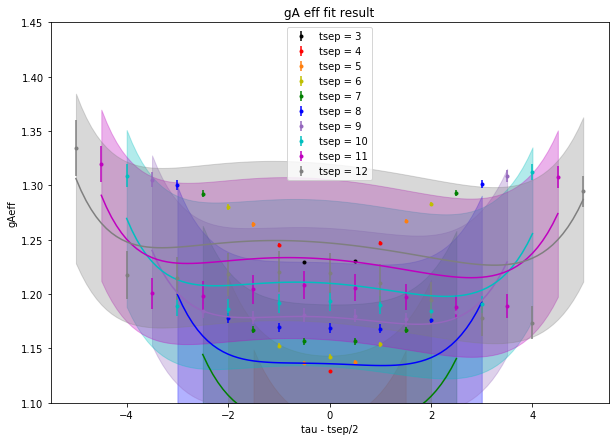

<Figure size 432x288 with 0 Axes>

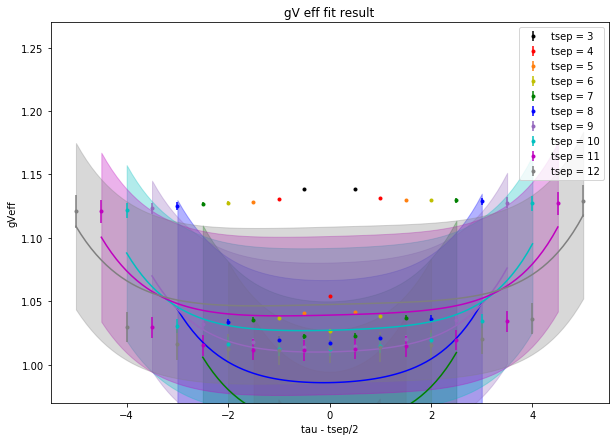

<Figure size 432x288 with 0 Axes>

In [87]:
# Now, plot out the 3-point function
# set the array of tsep, tau pairs
step_up = 10
t_min = 0
t_max = 25
tau_step = 10
legendlabels_3pt = np.array(["tsep = {}".format(i) for i in tsep_vals])

# Create 2-d and 1-d versions of the 3-point (tsep, tau) pairs
t_3pt_fitresult_2d = np.array([ np.array([ [tsep, tau] for tau in np.linspace(1, tsep - 1, (tsep - 2)*step_up +1)]) for tsep in tsep_vals])
t_3pt_fitresult_tsep = np.zeros(np.sum(np.array([len(np.linspace(1, tsep - 1, (tsep - 2)*step_up +1)) for tsep in tsep_vals])))
t_3pt_fitresult_tau = np.zeros(np.sum(np.array([len(np.linspace(1, tsep - 1, (tsep - 2)*step_up +1)) for tsep in tsep_vals])))

k = 0
for tsep in tsep_vals:
    for tau in np.linspace(1, tsep - 1, (tsep - 2)*step_up +1):
        t_3pt_fitresult_tsep[k] = tsep
        t_3pt_fitresult_tau[k] = tau
        k += 1
        
t_3pt_fitresult_1d = np.transpose(np.array([t_3pt_fitresult_tsep, t_3pt_fitresult_tau]))

# Now, calculate gA3 and gA4
model_A3_3pt_1d = C_3pt_A3(t_3pt_fitresult_1d, post_3pt)
model_V4_3pt_1d = C_3pt_V4(t_3pt_fitresult_1d, post_3pt)

# Convert to 2d
model_A3_3pt_2d = convert_1dto2d(t_3pt_fitresult_1d, t_3pt_fitresult_2d, model_A3_3pt_1d)
model_V4_3pt_2d = convert_1dto2d(t_3pt_fitresult_1d, t_3pt_fitresult_2d, model_V4_3pt_1d)

# Now, take the ratio, first take the respective 2-point function
model_ratio_2pt = C_2pt_SS(tsep_vals, post_3pt)

model_A3_ratio_2d = np.array([ np.array([ model_A3_3pt_2d[i][j]/model_ratio_2pt[i] for j in range(len(model_A3_3pt_2d[i]))]) for i in range(len(model_A3_3pt_2d))])
model_V4_ratio_2d = np.array([ np.array([ model_V4_3pt_2d[i][j]/model_ratio_2pt[i] for j in range(len(model_V4_3pt_2d[i]))]) for i in range(len(model_V4_3pt_2d))])

# Now, to prepare for plotting, split the data into mean, upper-bound and lower-bound
model_A3_ratio_2d_mean = np.array([ [ model_A3_ratio_2d[i][j].mean for j in range(len(model_A3_ratio_2d[i]))] for i in range(len(model_A3_ratio_2d)) ])
model_A3_ratio_2d_upbound = np.array([ [ model_A3_ratio_2d[i][j].mean + model_A3_ratio_2d[i][j].sdev for j in range(len(model_A3_ratio_2d[i]))] for i in range(len(model_A3_ratio_2d)) ])
model_A3_ratio_2d_lowbound = np.array([ [ model_A3_ratio_2d[i][j].mean - model_A3_ratio_2d[i][j].sdev for j in range(len(model_A3_ratio_2d[i]))] for i in range(len(model_A3_ratio_2d)) ])

model_V4_ratio_2d_mean = np.array([ [ model_V4_ratio_2d[i][j].mean for j in range(len(model_V4_ratio_2d[i]))] for i in range(len(model_V4_ratio_2d)) ])
model_V4_ratio_2d_upbound = np.array([ [ model_V4_ratio_2d[i][j].mean + model_V4_ratio_2d[i][j].sdev for j in range(len(model_V4_ratio_2d[i]))] for i in range(len(model_V4_ratio_2d)) ])
model_V4_ratio_2d_lowbound = np.array([ [ model_V4_ratio_2d[i][j].mean - model_V4_ratio_2d[i][j].sdev for j in range(len(model_V4_ratio_2d[i]))] for i in range(len(model_V4_ratio_2d)) ])

# Also, convert the 2-d tsep, tau array into an array of tau - tsep/2
t_3pt_tseptau_diff = np.array([ np.array([tau - tsep/2. for tau in np.linspace(1, tsep - 1, (tsep - 2)*step_up +1)]) for tsep in tsep_vals])

# The color pallete for plotting the 3-point correlation function
colors_3pt = np.array(['k', 'r', 'tab:orange', 'y', 'g', 'b', 'tab:purple', 'c', 'm', 'tab:grey'])

# The raw dataset fitted to
x_3pt = np.array([[j - (i+3)/2. for j in range(1, i+tsep_vals[0])] for i in range(len(tsep_vals))])
y_3pt_A3 = np.array([ np.array([gv_avg_data['C_ratio_A3'][i][j].mean for j in range(len(gv_avg_data['C_ratio_A3'][i]))]) for i in range(len(tsep_vals))])
y_3pt_A3_err = np.array([ np.array([gv_avg_data['C_ratio_A3'][i][j].sdev for j in range(len(gv_avg_data['C_ratio_A3'][i]))]) for i in range(len(tsep_vals))])
y_3pt_V4 = np.array([ np.array([gv_avg_data['C_ratio_V4'][i][j].mean for j in range(len(gv_avg_data['C_ratio_V4'][i]))]) for i in range(len(tsep_vals))])
y_3pt_V4_err = np.array([ np.array([gv_avg_data['C_ratio_V4'][i][j].sdev for j in range(len(gv_avg_data['C_ratio_V4'][i]))]) for i in range(len(tsep_vals))])

h5_dm.fit_data_plot("gA eff fit result", "tau - tsep/2", "gAeff", x_3pt, y_3pt_A3, t_3pt_tseptau_diff, model_A3_ratio_2d_mean, model_A3_ratio_2d_upbound, model_A3_ratio_2d_lowbound, colors_3pt, nplots = len(gv_avg_data['C_ratio_A3']), ydat_error=y_3pt_A3_err, datalabels = legendlabels_3pt, ylim=np.array([1.10, 1.45])) 
h5_dm.fit_data_plot("gV eff fit result", "tau - tsep/2", "gVeff", x_3pt, y_3pt_V4, t_3pt_tseptau_diff, model_V4_ratio_2d_mean, model_V4_ratio_2d_upbound, model_V4_ratio_2d_lowbound, colors_3pt, nplots = len(gv_avg_data['C_ratio_V4']), ydat_error=y_3pt_V4_err, datalabels = legendlabels_3pt, ylim=np.array([0.97, 1.27])) 

### Fit and plot the Feynman-Hellman dataset's data, see if it's any different from the sum-subtracted

In [107]:
# Set priors


num_zs = 2
num_states_FH = 2

# prior the fits
tp = gv.BufferDict()

# This is the exponent e_decay_exp such that the increment between two consecutive excited state energies decays as 1/n^e_decay_exp, where n is the order of the excited state energy 
e_decay_exp = 0

tp['E0'] = gv.gvar(0.67, 0.02)
tp['Z0'] = gv.gvar(0.0008, 0.0003)
tp['Ztilde0'] = gv.gvar(0.003, 0.003)

# Define some constants for prioring the higher-order energies
dE0 = 2*mpi
b = 0.7

# Use constant dE to prior the energies
dE0 = 2*mpi
energyvals = np.array([None]*num_zs)
dEvals = np.array([None]*(num_zs - 1))

energyvals[0] = tp['E0'].mean
for k in range(1, num_zs):
    dEvals[k-1] = dE0/np.power(k, e_decay_exp)
    energyvals[k] = energyvals[k-1] + dEvals[k-1]

for n in range(1, num_zs): #num_zs
    tp['Z{}'.format(n)] = gv.gvar(0.0012, 0.0006)
    tp['Ztilde{}'.format(n)] = gv.gvar(0, 0.01)
    
    tp['log(dE{})'.format(n)] = gv.gvar(np.log(dEvals[n-1]), b)
    
# Set the "garbage can" for the Feynman Hellman fit
tp['log(FH_dEmax)'] = gv.gvar(np.log(dEvals[num_states_FH - 2]), b) 
tp['Z_FHmax'] = gv.gvar(0.0012, 0.0006)
tp['Ztilde_FHmax'] = gv.gvar(0, 0.01)

for n in range(num_zs):
    tp["d_gA_ss_{}".format(n)] = gv.gvar(0,1)
    tp["d_gA_ps_{}".format(n)] = gv.gvar(0,1)
    tp["d_gV_ss_{}".format(n)] = gv.gvar(0,1)
    tp["d_gV_ps_{}".format(n)] = gv.gvar(0,1)
    for m in range(num_zs):
        
        tp['gA3_{0}{1}'.format(n, m)] = gv.gvar(1, 2)
        if n == m and n < num_zs-1:
            tp['gV4_{0}{1}'.format(n, m)] = gv.gvar(1, 0.1)
        else:
            tp['gV4_{0}{1}'.format(n, m)] = gv.gvar(0, 2)

tp['gA3_00'] = gv.gvar(1.25, 0.15)
tp['gV4_00'] = gv.gvar(1.07, 0.07)

tp['gA3_FHmaxFHmax'] = gv.gvar(1, 2)
tp['gV4_FHmaxFHmax'] = gv.gvar(0, 2)

for n in range(num_states_FH-1):
    tp['gA3_FHmax{}'.format(n)] = gv.gvar(1, 2)
    tp['gA3_{}FHmax'.format(n)] = gv.gvar(1, 2)
    tp['gV4_FHmax{}'.format(n)] = gv.gvar(0, 2)
    tp['gV4_{}FHmax'.format(n)] = gv.gvar(0, 2)


In [108]:
# Create x- and y-samples for the fit
fit_FHdata = lsqfit.nonlinear_fit(data=(np.array([l for l in tsep_vals[:-1]]), np.array([gv_avg_data['FH'][l] for l in range(np.min(tsep_vals), np.max(tsep_vals))])), prior=tp,fcn=C_FHdata, debug=True)
print(fit_FHdata.format(pstyle='vv'))
post_FHdata = fit_FHdata.p

Least Square Fit:
  chi2/dof [dof] = 0.99 [36]    Q = 0.49    logGBF = 90.49

Parameters:
             E0                 0.67 +- 0.02             [     0.67 +- 0.02 ]  
             Z0   0.000630924 +- 0.000293511             [ 0.0008 +- 0.0003 ]  
        Ztilde0     0.00296342 +- 0.00298178             [   0.003 +- 0.003 ]  
             Z1   -0.00028696 +- 0.000249286             [ 0.0012 +- 0.0006 ]  **
        Ztilde1    -0.00109754 +- 0.00138483             [        0 +- 0.01 ]  
       log(dE1)       -0.259084 +- 0.0748176             [  -0.97551 +- 0.7 ]  *
  log(FH_dEmax)              -0.97551 +- 0.7             [  -0.97551 +- 0.7 ]  
        Z_FHmax             0.0012 +- 0.0006             [ 0.0012 +- 0.0006 ]  
   Ztilde_FHmax          8.81778e-21 +- 0.01             [        0 +- 0.01 ]  
      d_gA_ss_0      7.66632e-08 +- 0.979266             [           0 +- 1 ]  
      d_gA_ps_0      2.66356e-07 +- 0.986107             [           0 +- 1 ]  
      d_gV_ss_0      6.8971

In [109]:
final_posterior = open("FHdata_individual_out.obj", 'wb')
pickle.dump(post_FHdata, final_posterior)
final_posterior.close()

(64, 4)


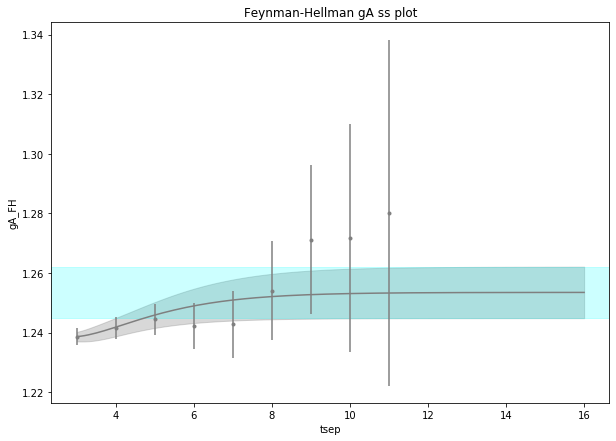

<Figure size 432x288 with 0 Axes>

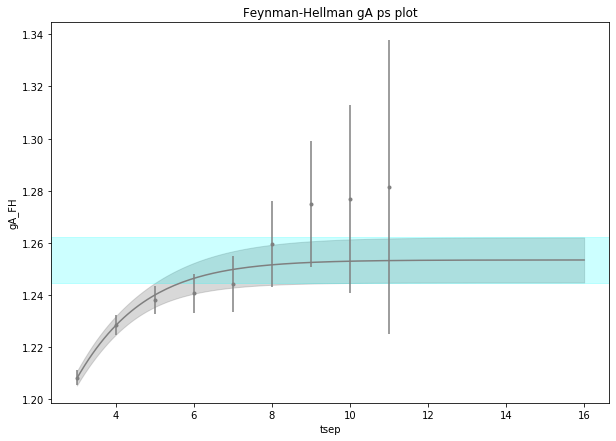

<Figure size 432x288 with 0 Axes>

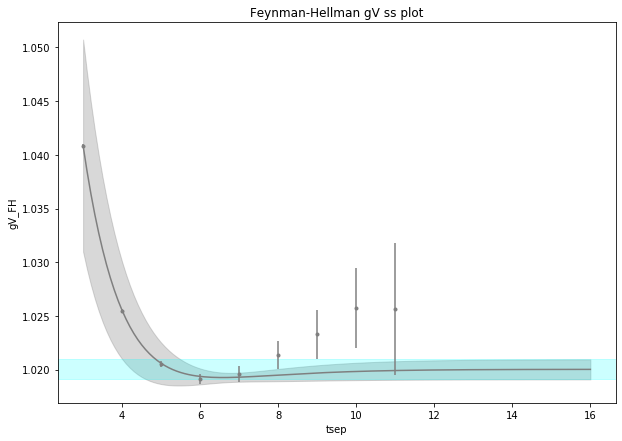

<Figure size 432x288 with 0 Axes>

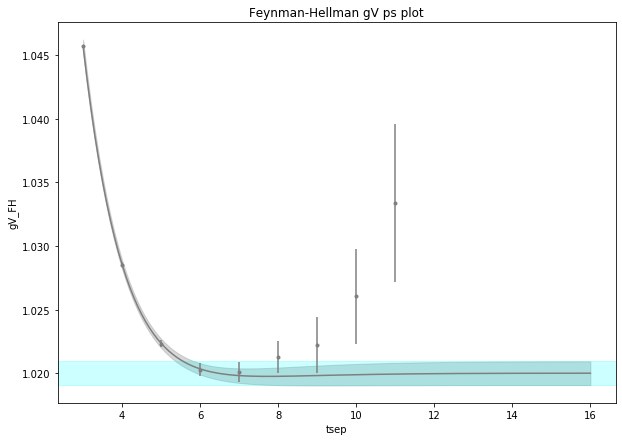

<Figure size 432x288 with 0 Axes>

In [110]:
print(np.shape(gv_avg_data['FH']))
# And finally, plot the Feynman-Hellman fit functions
step_FH = 10

# Set up the fit plotting
t_FH_model = np.linspace(tsep_vals[0], tsep_vals[-1]+4, (tsep_vals[-1]+4 - tsep_vals[0])*step_FH + 1)


#CFH_A3_model = C_FH_A3(t_FH_model, post_CFHV4)
#CFH_V4_model = C_FH_V4(t_FH_model, post_CFHV4)
FH_A3_ss_model = C_FHdata_A3_ss(t_FH_model, post_FHdata)
FH_A3_ps_model = C_FHdata_A3_ps(t_FH_model, post_FHdata)
FH_V4_ss_model = C_FHdata_V4_ss(t_FH_model, post_FHdata)
FH_V4_ps_model = C_FHdata_V4_ps(t_FH_model, post_FHdata)

FH_A3_ss_model_mean = np.array([FH_A3_ss_model[i].mean for i in range(len(FH_A3_ss_model))])
FH_A3_ss_model_upbound = np.array([FH_A3_ss_model[i].mean + FH_A3_ss_model[i].sdev for i in range(len(FH_A3_ss_model))])
FH_A3_ss_model_lowbound = np.array([FH_A3_ss_model[i].mean - FH_A3_ss_model[i].sdev for i in range(len(FH_A3_ss_model))])
FH_A3_ps_model_mean = np.array([FH_A3_ps_model[i].mean for i in range(len(FH_A3_ps_model))])
FH_A3_ps_model_upbound = np.array([FH_A3_ps_model[i].mean + FH_A3_ps_model[i].sdev for i in range(len(FH_A3_ps_model))])
FH_A3_ps_model_lowbound = np.array([FH_A3_ps_model[i].mean - FH_A3_ps_model[i].sdev for i in range(len(FH_A3_ps_model))])
FH_V4_ss_model_mean = np.array([FH_V4_ss_model[i].mean for i in range(len(FH_V4_ss_model))])
FH_V4_ss_model_upbound = np.array([FH_V4_ss_model[i].mean + FH_V4_ss_model[i].sdev for i in range(len(FH_V4_ss_model))])
FH_V4_ss_model_lowbound = np.array([FH_V4_ss_model[i].mean - FH_V4_ss_model[i].sdev for i in range(len(FH_V4_ss_model))])
FH_V4_ps_model_mean = np.array([FH_V4_ps_model[i].mean for i in range(len(FH_V4_ps_model))])
FH_V4_ps_model_upbound = np.array([FH_V4_ps_model[i].mean + FH_V4_ps_model[i].sdev for i in range(len(FH_V4_ps_model))])
FH_V4_ps_model_lowbound = np.array([FH_V4_ps_model[i].mean - FH_V4_ps_model[i].sdev for i in range(len(FH_V4_ps_model))])

# Set up the raw data plotting
x_FHdata = np.array([i for i in tsep_vals[:-1] ])
y_FHdata_A3_ss = np.array([gv_avg_data['FH'][i][0].mean for i in range(np.min(tsep_vals), np.max(tsep_vals))])
y_FHdata_A3_ss_err = np.array([gv_avg_data['FH'][i][0].sdev for i in range(np.min(tsep_vals), np.max(tsep_vals))])
y_FHdata_A3_ps = np.array([gv_avg_data['FH'][i][1].mean for i in range(np.min(tsep_vals), np.max(tsep_vals))])
y_FHdata_A3_ps_err = np.array([gv_avg_data['FH'][i][1].sdev for i in range(np.min(tsep_vals), np.max(tsep_vals))])
y_FHdata_V4_ss = np.array([gv_avg_data['FH'][i][2].mean for i in range(np.min(tsep_vals), np.max(tsep_vals))])
y_FHdata_V4_ss_err = np.array([gv_avg_data['FH'][i][2].sdev for i in range(np.min(tsep_vals), np.max(tsep_vals))])
y_FHdata_V4_ps = np.array([gv_avg_data['FH'][i][3].mean for i in range(np.min(tsep_vals), np.max(tsep_vals))])
y_FHdata_V4_ps_err = np.array([gv_avg_data['FH'][i][3].sdev for i in range(np.min(tsep_vals), np.max(tsep_vals))])

#h5_dm.fit_data_plot("Feynman-Hellman gA plot", "tsep", "gA_FH", x_CFH, y_CFH_A3, t_FH_model, CFH_A3_model_mean, CFH_A3_model_upbound, CFH_A3_model_lowbound, "tab:grey", g00 = post_CFHV4['gA3_00'], ydat_error=y_CFH_A3_err) 
#h5_dm.fit_data_plot("Feynman-Hellman gV plot", "tsep", "gV_FH", x_CFH, y_CFH_V4, t_FH_model, CFH_V4_model_mean, CFH_V4_model_upbound, CFH_V4_model_lowbound, "tab:grey", g00 = post_CFHV4['gV4_00'], ydat_error=y_CFH_V4_err)

h5_dm.fit_data_plot("Feynman-Hellman gA ss plot", "tsep", "gA_FH", x_FHdata, y_FHdata_A3_ss, t_FH_model, FH_A3_ss_model_mean, FH_A3_ss_model_upbound, FH_A3_ss_model_lowbound, "tab:grey", g00 = post_FHdata['gA3_00'], ydat_error=y_FHdata_A3_ss_err) 
h5_dm.fit_data_plot("Feynman-Hellman gA ps plot", "tsep", "gA_FH", x_FHdata, y_FHdata_A3_ps, t_FH_model, FH_A3_ps_model_mean, FH_A3_ps_model_upbound, FH_A3_ps_model_lowbound, "tab:grey", g00 = post_FHdata['gA3_00'], ydat_error=y_FHdata_A3_ps_err) 
h5_dm.fit_data_plot("Feynman-Hellman gV ss plot", "tsep", "gV_FH", x_FHdata, y_FHdata_V4_ss, t_FH_model, FH_V4_ss_model_mean, FH_V4_ss_model_upbound, FH_V4_ss_model_lowbound, "tab:grey", g00 = post_FHdata['gV4_00'], ydat_error=y_FHdata_V4_ss_err)
h5_dm.fit_data_plot("Feynman-Hellman gV ps plot", "tsep", "gV_FH", x_FHdata, y_FHdata_V4_ps, t_FH_model, FH_V4_ps_model_mean, FH_V4_ps_model_upbound, FH_V4_ps_model_lowbound, "tab:grey", g00 = post_FHdata['gV4_00'], ydat_error=y_FHdata_V4_ps_err)



In [95]:
print(y_FHdata_A3_ss)

[1.23862113 1.24154404 1.24438406 1.24204797 1.24280315 1.25409806
 1.27116142 1.27165367 1.28027282]


In [91]:
print(y_FHdata_A3_ss)
print((gv_avg_data['FH_N_A3'][1][0]/gv_avg_data['2pt_D'][1][0]) - (gv_avg_data['FH_N'][0][0]/gv_avg_data['2pt_D'][0][0]))

[-0.89982951  1.31246066  1.23773998  1.23862113  1.24154404  1.24438406
  1.24204797  1.24280315  1.25409806]
-0.8998(76)


#### Now, vary the width of the first excited state, the tau-bounds (calculated as distance from 0 of the minimum and from tsep of the maximum

Set the arrays over which to loop over and the priors and 3-point data-sets to use at each iteration

In [165]:
# Create arrays for the parameters that will be varied
b = np.array([0.1, 0.3, 0.5, 0.7, 1.0])
#tsep_mins = np.array([3, 7, 10])
tau_cuts = np.arange(1,4,1)
n_z_vals = np.arange(3,8,1)
n_FH_vals = np.array([2, 3])

n_zFH_combined = np.arange(6, 16, 1) # these n-values are there to encode both num_zs and n_FH
zFH_splitted = 2 #The number such that n_zFH_combined/2 is num_zs and (n_zFH_combined % 2) + 2 is num_states_FH

In [166]:
# set priors for each dE-set, num-z set, and num-FH-set
priors = []
for i in range(3):
    priors.append([])
    for j in range(len(b)):
        priors[i].append([])
        for k in range(len(n_zFH_combined)):
            priors[i][j].append(gv.BufferDict())
            
            num_zs = n_zFH_combined[k]//2
            num_states_FH = n_zFH_combined[k] % 2 + 2
            e_decay_exp = i
            
            priors[i][j][k]['E0'] = gv.gvar(0.67, 0.02)
            priors[i][j][k]['Z0'] = gv.gvar(0.0008, 0.0003)
            priors[i][j][k]['Ztilde0'] = gv.gvar(0.003, 0.003)

            # Define some constants for prioring the higher-order energies
            dE0 = 2*mpi

            # Use constant dE to prior the energies
            energyvals = np.array([None]*num_zs)
            dEvals = np.array([None]*(num_zs - 1))

            #E0_errbar = 0.8
            energyvals[0] = gv.gvar(0.67, 0.02)
            for n in range(1, num_zs):
                dEvals[n-1] = dE0/np.power(n, e_decay_exp)
                energyvals[n] = energyvals[n-1] + dEvals[n-1]
            
            priors[i][j][k]['log(dE1)'] = gv.gvar(np.log(dEvals[0]), b[j])
            priors[i][j][k]['Z1'] = gv.gvar(0.0012, 0.0006)
            priors[i][j][k]['Ztilde1'] = gv.gvar(0, 0.01)
            
            for n in range(2, num_zs):
                priors[i][j][k]['log(dE{})'.format(n)] = gv.gvar(np.log(dEvals[n-1]), 0.7)
                priors[i][j][k]['Z{}'.format(n)] = gv.gvar(0.0012, 0.0006)
                priors[i][j][k]['Ztilde{}'.format(n)] = gv.gvar(0, 0.01)


            for n in range(num_zs):
                for m in range(num_zs):
        
                    priors[i][j][k]['gA3_{0}{1}'.format(n, m)] = gv.gvar(1, 2)
                    if n == m and n < num_zs-1:
                        priors[i][j][k]['gV4_{0}{1}'.format(n, m)] = gv.gvar(1, 0.1)
                    else:
                        priors[i][j][k]['gV4_{0}{1}'.format(n, m)] = gv.gvar(0, 2)

            priors[i][j][k]['gA3_00'] = gv.gvar(1.25, 0.15)
            priors[i][j][k]['gV4_00'] = gv.gvar(1.07, 0.07)

            # Set the "garbage can" for the Feynman Hellman fit
            #priors[i][j][k]['Z_FHmax'] = gv.gvar(0.0008, 0.0004)
            #if num_states_FH == 2:
                #priors[i][j][k]['log(FH_dEmax)'] = gv.gvar(np.log(dEvals[num_states_FH - 2]), b[j])
            #else:
                #priors[i][j][k]['log(FH_dEmax)'] = gv.gvar(np.log(dEvals[num_states_FH - 2]), 0.7)

            #for n in range(num_states_FH-1):
                #priors[i][j][k]['gA3_FHmax{}'.format(n)] = gv.gvar(1, 2)
                #priors[i][j][k]['gA3_{}FHmax'.format(n)] = gv.gvar(1, 2)
                #priors[i][j][k]['gV4_FHmax{}'.format(n)] = gv.gvar(0, 2)
                #priors[i][j][k]['gV4_{}FHmax'.format(n)] = gv.gvar(0, 2)
    
            #priors[i][j][k]['gA3_FHmaxFHmax'] = gv.gvar(1, 2)
            #priors[i][j][k]['gV4_FHmaxFHmax'] = gv.gvar(0, 2)
            
            

In [167]:
list_LogGBF_a0 = np.array([[[None]*len(n_zFH_combined)]*len(tau_cuts)]*len(b))
list_Q_a0 = np.array([[[None]*len(n_zFH_combined)]*len(tau_cuts)]*len(b))
list_E0_a0 = np.array([[[None]*len(n_zFH_combined)]*len(tau_cuts)]*len(b))
list_gA00_a0 = np.array([[[None]*len(n_zFH_combined)]*len(tau_cuts)]*len(b))
list_gV00_a0 = np.array([[[None]*len(n_zFH_combined)]*len(tau_cuts)]*len(b))

list_LogGBF_a1 = np.array([[[None]*len(n_zFH_combined)]*len(tau_cuts)]*len(b))
list_Q_a1 = np.array([[[None]*len(n_zFH_combined)]*len(tau_cuts)]*len(b))
list_E0_a1 = np.array([[[None]*len(n_zFH_combined)]*len(tau_cuts)]*len(b))
list_gA00_a1 = np.array([[[None]*len(n_zFH_combined)]*len(tau_cuts)]*len(b))
list_gV00_a1 = np.array([[[None]*len(n_zFH_combined)]*len(tau_cuts)]*len(b))

list_LogGBF_a2 = np.array([[[None]*len(n_zFH_combined)]*len(tau_cuts)]*len(b))
list_Q_a2 = np.array([[[None]*len(n_zFH_combined)]*len(tau_cuts)]*len(b))
list_E0_a2 = np.array([[[None]*len(n_zFH_combined)]*len(tau_cuts)]*len(b))
list_gA00_a2 = np.array([[[None]*len(n_zFH_combined)]*len(tau_cuts)]*len(b))
list_gV00_a2 = np.array([[[None]*len(n_zFH_combined)]*len(tau_cuts)]*len(b))

In [168]:
# Create 3-point datasets for each tau-cut data set
tau_cut_to_min_tsep = np.array([3, 4, 6])
x_vals_3fit = []
y_vals_3fit = []

y_3pt_A3_2d = np.array([ [gv_avg_data['3pt_A3'][i][j] for j in range(1, i+tsep_vals[0])] for i in range(len(tsep_vals))])
y_3pt_A3 = convert_2dto1d(t_1d_array, t_2d_array, y_3pt_A3_2d)
y_3pt_V4_2d = np.array([ [gv_avg_data['3pt_V4'][i][j] for j in range(1, i+tsep_vals[0])] for i in range(len(tsep_vals))])
y_3pt_V4 = convert_2dto1d(t_1d_array, t_2d_array, y_3pt_V4_2d)

y_3pt = np.transpose(np.array([[y_3pt_A3], [y_3pt_V4]]), axes=[2,0,1])

for i in range(len(tau_cuts)):
    x_vals_3fit.append([])
    y_vals_3fit.append([])
    
    for k in range(len(t_1d_array)):
        if(t_1d_array[k][0] >= tau_cut_to_min_tsep[i]):
            if(t_1d_array[k][1] >= tau_cuts[i]):
                if(t_1d_array[k][1] <= t_1d_array[k][0] - tau_cuts[i]):
                    x_vals_3fit[i].append(t_1d_array[k].tolist())
                    y_vals_3fit[i].append(y_3pt[k].tolist())
                            
    x_vals_3fit[i] = np.array(x_vals_3fit[i])
    y_vals_3fit[i] = np.array(y_vals_3fit[i])
    

Now that the priors and the data are set, do the fits

In [169]:

for i in range(len(b)):
    for j in range(len(tau_cuts)):
        for k in range(len(n_zFH_combined)):
            num_zs = n_zFH_combined[k]//2
            num_states_FH = n_zFH_combined[k] % 2 + 2
            
            fit_a0 = lsqfit.nonlinear_fit(data=(x_vals_3fit[j], y_vals_3fit[j]), prior=priors[0][i][k],fcn=C_3pt,debug=True)
            fit_a1 = lsqfit.nonlinear_fit(data=(x_vals_3fit[j], y_vals_3fit[j]), prior=priors[1][i][k],fcn=C_3pt,debug=True)
            fit_a2 = lsqfit.nonlinear_fit(data=(x_vals_3fit[j], y_vals_3fit[j]), prior=priors[2][i][k],fcn=C_3pt,debug=True)
            
            print("dE constant, lod(dE1) bound = ", b[i], " tau_cuts = ", tau_cuts[j], " num_zs = ", num_zs, " num_states_FH = ", num_states_FH)
            print(fit_a0.format(pstyle='vv'))    
            list_LogGBF_a0[i][j][k] = fit_a0.logGBF
            list_Q_a0[i][j][k] = fit_a0.Q
            list_E0_a0[i][j][k] = fit_a0.p['E0']
            list_gA00_a0[i][j][k] = fit_a0.p['gA3_00']
            list_gV00_a0[i][j][k] = fit_a0.p['gV4_00']
                
            print("dE proportional to 1/n, log(dE1) bound = ", b[i], " tau_cuts = ", tau_cuts[j], " num_zs = ", num_zs, " num_states_FH = ", num_states_FH)
            print(fit_a1.format(pstyle='vv'))
            list_LogGBF_a1[i][j][k] = fit_a1.logGBF
            list_Q_a1[i][j][k] = fit_a1.Q
            list_E0_a1[i][j][k] = fit_a1.p['E0']
            list_gA00_a1[i][j][k] = fit_a1.p['gA3_00']
            list_gV00_a1[i][j][k] = fit_a2.p['gV4_00']
                
            print("dE proportional to 1/n^2, log(dE1) bound = ", b[i], " tau_cuts = ", tau_cuts[j], " num_zs = ", num_zs, " num_states_FH = ", num_states_FH)
            print(fit_a2.format(pstyle='vv'))
            list_LogGBF_a2[i][j][k] = fit_a2.logGBF
            list_Q_a2[i][j][k] = fit_a2.Q
            list_E0_a2[i][j][k] = fit_a2.p['E0']
            list_gA00_a2[i][j][k] = fit_a2.p['gA3_00']
            list_gV00_a2[i][j][k] = fit_a2.p['gV4_00']
                


<ipython-input-151-3b52adc68b6c>:22: RuntimeWarning: overflow encountered in exp
  result += p['Z{}'.format(n)]*p['gA3_{0}{1}'.format(n, m)]*p['Z{}'.format(m)]*np.exp(-En*tsep)*np.exp(-(Em - En)*tau)
<ipython-input-151-3b52adc68b6c>:22: RuntimeWarning: invalid value encountered in multiply
  result += p['Z{}'.format(n)]*p['gA3_{0}{1}'.format(n, m)]*p['Z{}'.format(m)]*np.exp(-En*tsep)*np.exp(-(Em - En)*tau)
<ipython-input-151-3b52adc68b6c>:57: RuntimeWarning: overflow encountered in exp
  result += p['Z{}'.format(n)]*p['gV4_{0}{1}'.format(n, m)]*p['Z{}'.format(m)]*np.exp(-En*tsep)*np.exp(-(Em - En)*tau)
<ipython-input-151-3b52adc68b6c>:57: RuntimeWarning: invalid value encountered in multiply
  result += p['Z{}'.format(n)]*p['gV4_{0}{1}'.format(n, m)]*p['Z{}'.format(m)]*np.exp(-En*tsep)*np.exp(-(Em - En)*tau)


dE constant, lod(dE1) bound =  0.1  tau_cuts =  1  num_zs =  3  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 19 [130]    Q = 0    logGBF = 2238.2

Parameters:
             E0      0.676962 +- 0.000983802             [     0.67 +- 0.02 ]  
             Z0   0.000786149 +- 2.28746e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0               0.003 +- 0.003             [   0.003 +- 0.003 ]  
       log(dE1)      0.0803766 +- 0.00884436             [  -0.97551 +- 0.1 ]  *****
             Z1     0.00148052 +- 7.7132e-05             [ 0.0012 +- 0.0006 ]  
        Ztilde1          7.71304e-19 +- 0.01             [        0 +- 0.01 ]  
       log(dE2)         1.17318 +- 0.0339535             [  -0.97551 +- 0.7 ]  ***
             Z2   -0.00183019 +- 0.000430324             [ 0.0012 +- 0.0006 ]  *****
        Ztilde2          1.11197e-18 +- 0.01             [        0 +- 0.01 ]  
         gA3_00          1.14098 +- 0.066062             [     1.25 +- 0.15 ]  
         gV4_00  

dE constant, lod(dE1) bound =  0.1  tau_cuts =  1  num_zs =  3  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 19 [130]    Q = 0    logGBF = 2238.2

Parameters:
             E0      0.676962 +- 0.000983802             [     0.67 +- 0.02 ]  
             Z0   0.000786149 +- 2.28746e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0               0.003 +- 0.003             [   0.003 +- 0.003 ]  
       log(dE1)      0.0803766 +- 0.00884436             [  -0.97551 +- 0.1 ]  *****
             Z1     0.00148052 +- 7.7132e-05             [ 0.0012 +- 0.0006 ]  
        Ztilde1          7.71304e-19 +- 0.01             [        0 +- 0.01 ]  
       log(dE2)         1.17318 +- 0.0339535             [  -0.97551 +- 0.7 ]  ***
             Z2   -0.00183019 +- 0.000430324             [ 0.0012 +- 0.0006 ]  *****
        Ztilde2          1.11197e-18 +- 0.01             [        0 +- 0.01 ]  
         gA3_00          1.14098 +- 0.066062             [     1.25 +- 0.15 ]  
         gV4_00  

dE constant, lod(dE1) bound =  0.1  tau_cuts =  1  num_zs =  4  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 2 [130]    Q = 4.4e-11    logGBF = 3304.1

Parameters:
             E0       0.661046 +- 0.00220683             [     0.67 +- 0.02 ]  
             Z0   0.000746737 +- 2.27812e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0               0.003 +- 0.003             [   0.003 +- 0.003 ]  
       log(dE1)       -0.965656 +- 0.0636537             [  -0.97551 +- 0.1 ]  
             Z1   0.000554502 +- 3.95262e-05             [ 0.0012 +- 0.0006 ]  *
        Ztilde1         -9.09126e-22 +- 0.01             [        0 +- 0.01 ]  
       log(dE2)       -0.346234 +- 0.0475261             [  -0.97551 +- 0.7 ]  
             Z2    0.00113211 +- 7.38872e-05             [ 0.0012 +- 0.0006 ]  
        Ztilde2          3.51555e-22 +- 0.01             [        0 +- 0.01 ]  
       log(dE3)         1.42317 +- 0.0677868             [  -0.97551 +- 0.7 ]  ***
             Z3    0.

dE constant, lod(dE1) bound =  0.1  tau_cuts =  1  num_zs =  4  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 2 [130]    Q = 4.4e-11    logGBF = 3304.1

Parameters:
             E0       0.661046 +- 0.00220683             [     0.67 +- 0.02 ]  
             Z0   0.000746737 +- 2.27812e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0               0.003 +- 0.003             [   0.003 +- 0.003 ]  
       log(dE1)       -0.965656 +- 0.0636537             [  -0.97551 +- 0.1 ]  
             Z1   0.000554502 +- 3.95262e-05             [ 0.0012 +- 0.0006 ]  *
        Ztilde1         -9.09126e-22 +- 0.01             [        0 +- 0.01 ]  
       log(dE2)       -0.346234 +- 0.0475261             [  -0.97551 +- 0.7 ]  
             Z2    0.00113211 +- 7.38872e-05             [ 0.0012 +- 0.0006 ]  
        Ztilde2          3.51555e-22 +- 0.01             [        0 +- 0.01 ]  
       log(dE3)         1.42317 +- 0.0677868             [  -0.97551 +- 0.7 ]  ***
             Z3    0.

dE constant, lod(dE1) bound =  0.1  tau_cuts =  1  num_zs =  5  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 1 [130]    Q = 0.41    logGBF = 3335

Parameters:
             E0        0.654594 +- 0.0027431             [     0.67 +- 0.02 ]  
             Z0   0.000716798 +- 2.29287e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0               0.003 +- 0.003             [   0.003 +- 0.003 ]  
       log(dE1)       -0.968459 +- 0.0674665             [  -0.97551 +- 0.1 ]  
             Z1   0.000685859 +- 4.33102e-05             [ 0.0012 +- 0.0006 ]  
        Ztilde1         -2.29855e-20 +- 0.01             [        0 +- 0.01 ]  
       log(dE2)        0.184762 +- 0.0995965             [  -0.97551 +- 0.7 ]  *
             Z2    0.00155877 +- 0.000331557             [ 0.0012 +- 0.0006 ]  
        Ztilde2           9.4203e-21 +- 0.01             [        0 +- 0.01 ]  
       log(dE3)        -0.214879 +- 0.520018             [  -0.97551 +- 0.7 ]  *
             Z3    0.0015339

dE constant, lod(dE1) bound =  0.1  tau_cuts =  1  num_zs =  5  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 1 [130]    Q = 0.41    logGBF = 3335

Parameters:
             E0        0.654594 +- 0.0027431             [     0.67 +- 0.02 ]  
             Z0   0.000716798 +- 2.29287e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0               0.003 +- 0.003             [   0.003 +- 0.003 ]  
       log(dE1)       -0.968459 +- 0.0674665             [  -0.97551 +- 0.1 ]  
             Z1   0.000685859 +- 4.33102e-05             [ 0.0012 +- 0.0006 ]  
        Ztilde1         -2.29855e-20 +- 0.01             [        0 +- 0.01 ]  
       log(dE2)        0.184762 +- 0.0995965             [  -0.97551 +- 0.7 ]  *
             Z2    0.00155877 +- 0.000331557             [ 0.0012 +- 0.0006 ]  
        Ztilde2           9.4203e-21 +- 0.01             [        0 +- 0.01 ]  
       log(dE3)        -0.214879 +- 0.520018             [  -0.97551 +- 0.7 ]  *
             Z3    0.0015339

dE constant, lod(dE1) bound =  0.1  tau_cuts =  1  num_zs =  6  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.87 [130]    Q = 0.85    logGBF = 3312

Parameters:
             E0        0.658303 +- 0.00382353             [     0.67 +- 0.02 ]  
             Z0    0.000727959 +- 2.58427e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0                0.003 +- 0.003             [   0.003 +- 0.003 ]  
       log(dE1)          -0.9635 +- 0.0926086             [  -0.97551 +- 0.1 ]  
             Z1    0.000799758 +- 0.000185312             [ 0.0012 +- 0.0006 ]  
        Ztilde1          -6.95861e-19 +- 0.01             [        0 +- 0.01 ]  
       log(dE2)          -1.21666 +- 0.481796             [  -0.97551 +- 0.7 ]  
             Z2   -0.000419869 +- 0.000309626             [ 0.0012 +- 0.0006 ]  **
        Ztilde2           1.32635e-18 +- 0.01             [        0 +- 0.01 ]  
       log(dE3)         -0.712542 +- 0.431133             [  -0.97551 +- 0.7 ]  
             Z3

dE constant, lod(dE1) bound =  0.1  tau_cuts =  1  num_zs =  6  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.87 [130]    Q = 0.85    logGBF = 3312

Parameters:
             E0        0.658303 +- 0.00382353             [     0.67 +- 0.02 ]  
             Z0    0.000727959 +- 2.58427e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0                0.003 +- 0.003             [   0.003 +- 0.003 ]  
       log(dE1)          -0.9635 +- 0.0926086             [  -0.97551 +- 0.1 ]  
             Z1    0.000799758 +- 0.000185312             [ 0.0012 +- 0.0006 ]  
        Ztilde1          -6.95861e-19 +- 0.01             [        0 +- 0.01 ]  
       log(dE2)          -1.21666 +- 0.481796             [  -0.97551 +- 0.7 ]  
             Z2   -0.000419869 +- 0.000309626             [ 0.0012 +- 0.0006 ]  **
        Ztilde2           1.32635e-18 +- 0.01             [        0 +- 0.01 ]  
       log(dE3)         -0.712542 +- 0.431133             [  -0.97551 +- 0.7 ]  
             Z3

dE constant, lod(dE1) bound =  0.1  tau_cuts =  1  num_zs =  7  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.71 [130]    Q = 0.99    logGBF = 3262.6

Parameters:
             E0       0.661188 +- 0.00535121             [     0.67 +- 0.02 ]  
             Z0   0.000741379 +- 3.23307e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0               0.003 +- 0.003             [   0.003 +- 0.003 ]  
       log(dE1)        -1.02182 +- 0.0954104             [  -0.97551 +- 0.1 ]  
             Z1    0.00105459 +- 0.000400972             [ 0.0012 +- 0.0006 ]  
        Ztilde1          8.00705e-18 +- 0.01             [        0 +- 0.01 ]  
       log(dE2)         -1.69658 +- 0.519602             [  -0.97551 +- 0.7 ]  *
             Z2    0.00145649 +- 0.000507062             [ 0.0012 +- 0.0006 ]  
        Ztilde2         -5.33854e-19 +- 0.01             [        0 +- 0.01 ]  
       log(dE3)        -0.993943 +- 0.551059             [  -0.97551 +- 0.7 ]  
             Z3    0.001

dE constant, lod(dE1) bound =  0.1  tau_cuts =  1  num_zs =  7  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.71 [130]    Q = 0.99    logGBF = 3262.6

Parameters:
             E0       0.661188 +- 0.00535121             [     0.67 +- 0.02 ]  
             Z0   0.000741379 +- 3.23307e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0               0.003 +- 0.003             [   0.003 +- 0.003 ]  
       log(dE1)        -1.02182 +- 0.0954104             [  -0.97551 +- 0.1 ]  
             Z1    0.00105459 +- 0.000400972             [ 0.0012 +- 0.0006 ]  
        Ztilde1          8.00705e-18 +- 0.01             [        0 +- 0.01 ]  
       log(dE2)         -1.69658 +- 0.519602             [  -0.97551 +- 0.7 ]  *
             Z2    0.00145649 +- 0.000507062             [ 0.0012 +- 0.0006 ]  
        Ztilde2         -5.33854e-19 +- 0.01             [        0 +- 0.01 ]  
       log(dE3)        -0.993943 +- 0.551059             [  -0.97551 +- 0.7 ]  
             Z3    0.001

dE constant, lod(dE1) bound =  0.1  tau_cuts =  2  num_zs =  3  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 1.7 [90]    Q = 3.4e-05    logGBF = 2322.1

Parameters:
             E0         0.660538 +- 0.002673             [     0.67 +- 0.02 ]  
             Z0   0.000738832 +- 2.30577e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0               0.003 +- 0.003             [   0.003 +- 0.003 ]  
       log(dE1)       -0.977846 +- 0.0790589             [  -0.97551 +- 0.1 ]  
             Z1   0.000579184 +- 5.28159e-05             [ 0.0012 +- 0.0006 ]  *
        Ztilde1         -1.34902e-21 +- 0.01             [        0 +- 0.01 ]  
       log(dE2)       -0.276409 +- 0.0453767             [  -0.97551 +- 0.7 ]  
             Z2    0.00121695 +- 0.000529744             [ 0.0012 +- 0.0006 ]  
        Ztilde2         -1.34069e-21 +- 0.01             [        0 +- 0.01 ]  
         gA3_00         1.30685 +- 0.0759589             [     1.25 +- 0.15 ]  
         gV4_00        

dE constant, lod(dE1) bound =  0.1  tau_cuts =  2  num_zs =  3  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 1.7 [90]    Q = 3.4e-05    logGBF = 2322.1

Parameters:
             E0         0.660538 +- 0.002673             [     0.67 +- 0.02 ]  
             Z0   0.000738832 +- 2.30577e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0               0.003 +- 0.003             [   0.003 +- 0.003 ]  
       log(dE1)       -0.977846 +- 0.0790589             [  -0.97551 +- 0.1 ]  
             Z1   0.000579184 +- 5.28159e-05             [ 0.0012 +- 0.0006 ]  *
        Ztilde1         -1.34902e-21 +- 0.01             [        0 +- 0.01 ]  
       log(dE2)       -0.276409 +- 0.0453767             [  -0.97551 +- 0.7 ]  
             Z2    0.00121695 +- 0.000529744             [ 0.0012 +- 0.0006 ]  
        Ztilde2         -1.34069e-21 +- 0.01             [        0 +- 0.01 ]  
         gA3_00         1.30685 +- 0.0759589             [     1.25 +- 0.15 ]  
         gV4_00        

dE constant, lod(dE1) bound =  0.1  tau_cuts =  2  num_zs =  4  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.84 [90]    Q = 0.85    logGBF = 2315.9

Parameters:
             E0        0.66045 +- 0.00563584             [     0.67 +- 0.02 ]  
             Z0   0.000729855 +- 3.22737e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0               0.003 +- 0.003             [   0.003 +- 0.003 ]  
       log(dE1)        -1.01995 +- 0.0870893             [  -0.97551 +- 0.1 ]  
             Z1     0.00103657 +- 0.00033177             [ 0.0012 +- 0.0006 ]  
        Ztilde1         -1.32326e-20 +- 0.01             [        0 +- 0.01 ]  
       log(dE2)         -1.57391 +- 0.433699             [  -0.97551 +- 0.7 ]  
             Z2    0.00135543 +- 0.000458257             [ 0.0012 +- 0.0006 ]  
        Ztilde2          2.96081e-20 +- 0.01             [        0 +- 0.01 ]  
       log(dE3)          -1.1287 +- 0.424609             [  -0.97551 +- 0.7 ]  
             Z3    0.00139

dE constant, lod(dE1) bound =  0.1  tau_cuts =  2  num_zs =  4  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.84 [90]    Q = 0.85    logGBF = 2315.9

Parameters:
             E0        0.66045 +- 0.00563584             [     0.67 +- 0.02 ]  
             Z0   0.000729855 +- 3.22737e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0               0.003 +- 0.003             [   0.003 +- 0.003 ]  
       log(dE1)        -1.01995 +- 0.0870893             [  -0.97551 +- 0.1 ]  
             Z1     0.00103657 +- 0.00033177             [ 0.0012 +- 0.0006 ]  
        Ztilde1         -1.32326e-20 +- 0.01             [        0 +- 0.01 ]  
       log(dE2)         -1.57391 +- 0.433699             [  -0.97551 +- 0.7 ]  
             Z2    0.00135543 +- 0.000458257             [ 0.0012 +- 0.0006 ]  
        Ztilde2          2.96081e-20 +- 0.01             [        0 +- 0.01 ]  
       log(dE3)          -1.1287 +- 0.424609             [  -0.97551 +- 0.7 ]  
             Z3    0.00139

dE constant, lod(dE1) bound =  0.1  tau_cuts =  2  num_zs =  5  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.71 [90]    Q = 0.98    logGBF = 2298

Parameters:
             E0       0.660995 +- 0.00529892             [     0.67 +- 0.02 ]  
             Z0   0.000739993 +- 3.14379e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0               0.003 +- 0.003             [   0.003 +- 0.003 ]  
       log(dE1)       -0.985262 +- 0.0939737             [  -0.97551 +- 0.1 ]  
             Z1   0.000959899 +- 0.000328611             [ 0.0012 +- 0.0006 ]  
        Ztilde1          9.15995e-21 +- 0.01             [        0 +- 0.01 ]  
       log(dE2)         -1.49143 +- 0.503762             [  -0.97551 +- 0.7 ]  
             Z2    0.00134799 +- 0.000471178             [ 0.0012 +- 0.0006 ]  
        Ztilde2          2.61117e-21 +- 0.01             [        0 +- 0.01 ]  
       log(dE3)        -0.637471 +- 0.452858             [  -0.97551 +- 0.7 ]  
             Z3    0.0014430

dE constant, lod(dE1) bound =  0.1  tau_cuts =  2  num_zs =  5  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.71 [90]    Q = 0.98    logGBF = 2298

Parameters:
             E0       0.660995 +- 0.00529892             [     0.67 +- 0.02 ]  
             Z0   0.000739993 +- 3.14379e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0               0.003 +- 0.003             [   0.003 +- 0.003 ]  
       log(dE1)       -0.985262 +- 0.0939737             [  -0.97551 +- 0.1 ]  
             Z1   0.000959899 +- 0.000328611             [ 0.0012 +- 0.0006 ]  
        Ztilde1          9.15995e-21 +- 0.01             [        0 +- 0.01 ]  
       log(dE2)         -1.49143 +- 0.503762             [  -0.97551 +- 0.7 ]  
             Z2    0.00134799 +- 0.000471178             [ 0.0012 +- 0.0006 ]  
        Ztilde2          2.61117e-21 +- 0.01             [        0 +- 0.01 ]  
       log(dE3)        -0.637471 +- 0.452858             [  -0.97551 +- 0.7 ]  
             Z3    0.0014430

dE constant, lod(dE1) bound =  0.1  tau_cuts =  2  num_zs =  6  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.68 [90]    Q = 0.99    logGBF = 2278.6

Parameters:
             E0       0.659383 +- 0.00643193             [     0.67 +- 0.02 ]  
             Z0   0.000733563 +- 3.67941e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0               0.003 +- 0.003             [   0.003 +- 0.003 ]  
       log(dE1)        -1.03753 +- 0.0959391             [  -0.97551 +- 0.1 ]  
             Z1    0.00110365 +- 0.000458603             [ 0.0012 +- 0.0006 ]  
        Ztilde1         -2.90725e-20 +- 0.01             [        0 +- 0.01 ]  
       log(dE2)          -1.77703 +- 0.55117             [  -0.97551 +- 0.7 ]  *
             Z2     0.0016841 +- 0.000532643             [ 0.0012 +- 0.0006 ]  
        Ztilde2          3.08279e-21 +- 0.01             [        0 +- 0.01 ]  
       log(dE3)         -1.15734 +- 0.581525             [  -0.97551 +- 0.7 ]  
             Z3    0.0013

dE constant, lod(dE1) bound =  0.1  tau_cuts =  2  num_zs =  6  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.68 [90]    Q = 0.99    logGBF = 2278.6

Parameters:
             E0       0.659383 +- 0.00643193             [     0.67 +- 0.02 ]  
             Z0   0.000733563 +- 3.67941e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0               0.003 +- 0.003             [   0.003 +- 0.003 ]  
       log(dE1)        -1.03753 +- 0.0959391             [  -0.97551 +- 0.1 ]  
             Z1    0.00110365 +- 0.000458603             [ 0.0012 +- 0.0006 ]  
        Ztilde1         -2.90725e-20 +- 0.01             [        0 +- 0.01 ]  
       log(dE2)          -1.77703 +- 0.55117             [  -0.97551 +- 0.7 ]  *
             Z2     0.0016841 +- 0.000532643             [ 0.0012 +- 0.0006 ]  
        Ztilde2          3.08279e-21 +- 0.01             [        0 +- 0.01 ]  
       log(dE3)         -1.15734 +- 0.581525             [  -0.97551 +- 0.7 ]  
             Z3    0.0013

dE constant, lod(dE1) bound =  0.1  tau_cuts =  2  num_zs =  7  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.68 [90]    Q = 0.99    logGBF = 2274.4

Parameters:
             E0       0.659366 +- 0.00655932             [     0.67 +- 0.02 ]  
             Z0   0.000732132 +- 3.76887e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0               0.003 +- 0.003             [   0.003 +- 0.003 ]  
       log(dE1)        -1.04522 +- 0.0955826             [  -0.97551 +- 0.1 ]  
             Z1    0.00111799 +- 0.000474741             [ 0.0012 +- 0.0006 ]  
        Ztilde1          2.69359e-15 +- 0.01             [        0 +- 0.01 ]  
       log(dE2)         -1.81433 +- 0.543176             [  -0.97551 +- 0.7 ]  *
             Z2     0.00173317 +- 0.00053252             [ 0.0012 +- 0.0006 ]  
        Ztilde2          3.73647e-17 +- 0.01             [        0 +- 0.01 ]  
       log(dE3)         -1.24834 +- 0.590651             [  -0.97551 +- 0.7 ]  
             Z3     0.001

dE constant, lod(dE1) bound =  0.1  tau_cuts =  2  num_zs =  7  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.68 [90]    Q = 0.99    logGBF = 2274.4

Parameters:
             E0       0.659366 +- 0.00655932             [     0.67 +- 0.02 ]  
             Z0   0.000732132 +- 3.76887e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0               0.003 +- 0.003             [   0.003 +- 0.003 ]  
       log(dE1)        -1.04522 +- 0.0955826             [  -0.97551 +- 0.1 ]  
             Z1    0.00111799 +- 0.000474741             [ 0.0012 +- 0.0006 ]  
        Ztilde1          2.69359e-15 +- 0.01             [        0 +- 0.01 ]  
       log(dE2)         -1.81433 +- 0.543176             [  -0.97551 +- 0.7 ]  *
             Z2     0.00173317 +- 0.00053252             [ 0.0012 +- 0.0006 ]  
        Ztilde2          3.73647e-17 +- 0.01             [        0 +- 0.01 ]  
       log(dE3)         -1.24834 +- 0.590651             [  -0.97551 +- 0.7 ]  
             Z3     0.001

dE constant, lod(dE1) bound =  0.1  tau_cuts =  3  num_zs =  3  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 1.1 [56]    Q = 0.28    logGBF = 1450.5

Parameters:
             E0       0.657541 +- 0.00365103             [     0.67 +- 0.02 ]  
             Z0   0.000723083 +- 2.47446e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0               0.003 +- 0.003             [   0.003 +- 0.003 ]  
       log(dE1)        -1.03611 +- 0.0916726             [  -0.97551 +- 0.1 ]  
             Z1   0.000637245 +- 6.11954e-05             [ 0.0012 +- 0.0006 ]  
        Ztilde1         -6.06059e-21 +- 0.01             [        0 +- 0.01 ]  
       log(dE2)       0.0228757 +- 0.0863851             [  -0.97551 +- 0.7 ]  *
             Z2    0.00125698 +- 0.000573313             [ 0.0012 +- 0.0006 ]  
        Ztilde2         -2.13174e-21 +- 0.01             [        0 +- 0.01 ]  
         gA3_00         1.29151 +- 0.0755298             [     1.25 +- 0.15 ]  
         gV4_00          1

dE constant, lod(dE1) bound =  0.1  tau_cuts =  3  num_zs =  3  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 1.1 [56]    Q = 0.28    logGBF = 1450.5

Parameters:
             E0       0.657541 +- 0.00365103             [     0.67 +- 0.02 ]  
             Z0   0.000723083 +- 2.47446e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0               0.003 +- 0.003             [   0.003 +- 0.003 ]  
       log(dE1)        -1.03611 +- 0.0916726             [  -0.97551 +- 0.1 ]  
             Z1   0.000637245 +- 6.11954e-05             [ 0.0012 +- 0.0006 ]  
        Ztilde1         -6.06059e-21 +- 0.01             [        0 +- 0.01 ]  
       log(dE2)       0.0228757 +- 0.0863851             [  -0.97551 +- 0.7 ]  *
             Z2    0.00125698 +- 0.000573313             [ 0.0012 +- 0.0006 ]  
        Ztilde2         -2.13174e-21 +- 0.01             [        0 +- 0.01 ]  
         gA3_00         1.29151 +- 0.0755298             [     1.25 +- 0.15 ]  
         gV4_00          1

dE constant, lod(dE1) bound =  0.1  tau_cuts =  3  num_zs =  4  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.58 [56]    Q = 1    logGBF = 1431.3

Parameters:
             E0       0.660036 +- 0.00607085             [     0.67 +- 0.02 ]  
             Z0   0.000740607 +- 3.44282e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0               0.003 +- 0.003             [   0.003 +- 0.003 ]  
       log(dE1)       -0.977871 +- 0.0943116             [  -0.97551 +- 0.1 ]  
             Z1    0.00103705 +- 0.000352636             [ 0.0012 +- 0.0006 ]  
        Ztilde1         -9.65244e-21 +- 0.01             [        0 +- 0.01 ]  
       log(dE2)         -1.33537 +- 0.486851             [  -0.97551 +- 0.7 ]  
             Z2    0.00148763 +- 0.000511126             [ 0.0012 +- 0.0006 ]  
        Ztilde2          4.11994e-21 +- 0.01             [        0 +- 0.01 ]  
       log(dE3)         -0.746231 +- 0.53463             [  -0.97551 +- 0.7 ]  
             Z3     0.0015387

dE constant, lod(dE1) bound =  0.1  tau_cuts =  3  num_zs =  4  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.58 [56]    Q = 1    logGBF = 1431.3

Parameters:
             E0       0.660036 +- 0.00607085             [     0.67 +- 0.02 ]  
             Z0   0.000740607 +- 3.44282e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0               0.003 +- 0.003             [   0.003 +- 0.003 ]  
       log(dE1)       -0.977871 +- 0.0943116             [  -0.97551 +- 0.1 ]  
             Z1    0.00103705 +- 0.000352636             [ 0.0012 +- 0.0006 ]  
        Ztilde1         -9.65244e-21 +- 0.01             [        0 +- 0.01 ]  
       log(dE2)         -1.33537 +- 0.486851             [  -0.97551 +- 0.7 ]  
             Z2    0.00148763 +- 0.000511126             [ 0.0012 +- 0.0006 ]  
        Ztilde2          4.11994e-21 +- 0.01             [        0 +- 0.01 ]  
       log(dE3)         -0.746231 +- 0.53463             [  -0.97551 +- 0.7 ]  
             Z3     0.0015387

dE constant, lod(dE1) bound =  0.1  tau_cuts =  3  num_zs =  5  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.57 [56]    Q = 1    logGBF = 1424.2

Parameters:
             E0       0.658995 +- 0.00649511             [     0.67 +- 0.02 ]  
             Z0   0.000733053 +- 3.63797e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0               0.003 +- 0.003             [   0.003 +- 0.003 ]  
       log(dE1)       -0.995649 +- 0.0965457             [  -0.97551 +- 0.1 ]  
             Z1     0.00114925 +- 0.00043103             [ 0.0012 +- 0.0006 ]  
        Ztilde1         -8.06145e-23 +- 0.01             [        0 +- 0.01 ]  
       log(dE2)         -1.45303 +- 0.527361             [  -0.97551 +- 0.7 ]  
             Z2    0.00142718 +- 0.000536803             [ 0.0012 +- 0.0006 ]  
        Ztilde2         -3.59862e-21 +- 0.01             [        0 +- 0.01 ]  
       log(dE3)        -0.992839 +- 0.635048             [  -0.97551 +- 0.7 ]  
             Z3     0.0013599

dE constant, lod(dE1) bound =  0.1  tau_cuts =  3  num_zs =  5  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.57 [56]    Q = 1    logGBF = 1424.2

Parameters:
             E0       0.658995 +- 0.00649511             [     0.67 +- 0.02 ]  
             Z0   0.000733053 +- 3.63797e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0               0.003 +- 0.003             [   0.003 +- 0.003 ]  
       log(dE1)       -0.995649 +- 0.0965457             [  -0.97551 +- 0.1 ]  
             Z1     0.00114925 +- 0.00043103             [ 0.0012 +- 0.0006 ]  
        Ztilde1         -8.06145e-23 +- 0.01             [        0 +- 0.01 ]  
       log(dE2)         -1.45303 +- 0.527361             [  -0.97551 +- 0.7 ]  
             Z2    0.00142718 +- 0.000536803             [ 0.0012 +- 0.0006 ]  
        Ztilde2         -3.59862e-21 +- 0.01             [        0 +- 0.01 ]  
       log(dE3)        -0.992839 +- 0.635048             [  -0.97551 +- 0.7 ]  
             Z3     0.0013599

dE constant, lod(dE1) bound =  0.1  tau_cuts =  3  num_zs =  6  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.58 [56]    Q = 0.99    logGBF = 1423.7

Parameters:
             E0      0.658832 +- 0.00643708            [     0.67 +- 0.02 ]  
             Z0   0.000732606 +- 3.6041e-05            [ 0.0008 +- 0.0003 ]  
        Ztilde0              0.003 +- 0.003            [   0.003 +- 0.003 ]  
       log(dE1)       -0.991112 +- 0.096331            [  -0.97551 +- 0.1 ]  
             Z1   0.00113557 +- 0.000419161            [ 0.0012 +- 0.0006 ]  
        Ztilde1          1.0425e-16 +- 0.01            [        0 +- 0.01 ]  
       log(dE2)         -1.4123 +- 0.524044            [  -0.97551 +- 0.7 ]  
             Z2   0.00139697 +- 0.000537937            [ 0.0012 +- 0.0006 ]  
        Ztilde2         2.83594e-18 +- 0.01            [        0 +- 0.01 ]  
       log(dE3)       -0.966246 +- 0.627683            [  -0.97551 +- 0.7 ]  
             Z3   0.00139064 +- 0.000564688   

dE constant, lod(dE1) bound =  0.1  tau_cuts =  3  num_zs =  6  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.58 [56]    Q = 0.99    logGBF = 1423.7

Parameters:
             E0      0.658832 +- 0.00643708            [     0.67 +- 0.02 ]  
             Z0   0.000732606 +- 3.6041e-05            [ 0.0008 +- 0.0003 ]  
        Ztilde0              0.003 +- 0.003            [   0.003 +- 0.003 ]  
       log(dE1)       -0.991112 +- 0.096331            [  -0.97551 +- 0.1 ]  
             Z1   0.00113557 +- 0.000419161            [ 0.0012 +- 0.0006 ]  
        Ztilde1          1.0425e-16 +- 0.01            [        0 +- 0.01 ]  
       log(dE2)         -1.4123 +- 0.524044            [  -0.97551 +- 0.7 ]  
             Z2   0.00139697 +- 0.000537937            [ 0.0012 +- 0.0006 ]  
        Ztilde2         2.83594e-18 +- 0.01            [        0 +- 0.01 ]  
       log(dE3)       -0.966246 +- 0.627683            [  -0.97551 +- 0.7 ]  
             Z3   0.00139064 +- 0.000564688   

dE constant, lod(dE1) bound =  0.1  tau_cuts =  3  num_zs =  7  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.59 [56]    Q = 0.99    logGBF = 1423.9

Parameters:
             E0      0.658902 +- 0.00637808            [     0.67 +- 0.02 ]  
             Z0   0.00073327 +- 3.57451e-05            [ 0.0008 +- 0.0003 ]  
        Ztilde0              0.003 +- 0.003            [   0.003 +- 0.003 ]  
       log(dE1)       -0.98902 +- 0.0962247            [  -0.97551 +- 0.1 ]  
             Z1    0.0011253 +- 0.000410855            [ 0.0012 +- 0.0006 ]  
        Ztilde1        -2.87182e-16 +- 0.01            [        0 +- 0.01 ]  
       log(dE2)          -1.389 +- 0.517869            [  -0.97551 +- 0.7 ]  
             Z2   0.00139001 +- 0.000535693            [ 0.0012 +- 0.0006 ]  
        Ztilde2        -3.66408e-18 +- 0.01            [        0 +- 0.01 ]  
       log(dE3)       -0.936863 +- 0.624353            [  -0.97551 +- 0.7 ]  
             Z3    0.0014044 +- 0.000563459   

dE constant, lod(dE1) bound =  0.1  tau_cuts =  3  num_zs =  7  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.59 [56]    Q = 0.99    logGBF = 1423.9

Parameters:
             E0      0.658902 +- 0.00637808            [     0.67 +- 0.02 ]  
             Z0   0.00073327 +- 3.57451e-05            [ 0.0008 +- 0.0003 ]  
        Ztilde0              0.003 +- 0.003            [   0.003 +- 0.003 ]  
       log(dE1)       -0.98902 +- 0.0962247            [  -0.97551 +- 0.1 ]  
             Z1    0.0011253 +- 0.000410855            [ 0.0012 +- 0.0006 ]  
        Ztilde1        -2.87182e-16 +- 0.01            [        0 +- 0.01 ]  
       log(dE2)          -1.389 +- 0.517869            [  -0.97551 +- 0.7 ]  
             Z2   0.00139001 +- 0.000535693            [ 0.0012 +- 0.0006 ]  
        Ztilde2        -3.66408e-18 +- 0.01            [        0 +- 0.01 ]  
       log(dE3)       -0.936863 +- 0.624353            [  -0.97551 +- 0.7 ]  
             Z3    0.0014044 +- 0.000563459   

dE constant, lod(dE1) bound =  0.3  tau_cuts =  1  num_zs =  3  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 19 [130]    Q = 0    logGBF = 2287.5

Parameters:
             E0       0.677077 +- 0.00098178             [     0.67 +- 0.02 ]  
             Z0   0.000787115 +- 2.29276e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0               0.003 +- 0.003             [   0.003 +- 0.003 ]  
       log(dE1)      0.0869927 +- 0.00876647             [  -0.97551 +- 0.3 ]  ***
             Z1    0.00149482 +- 7.81232e-05             [ 0.0012 +- 0.0006 ]  
        Ztilde1          7.25408e-19 +- 0.01             [        0 +- 0.01 ]  
       log(dE2)         1.19901 +- 0.0369654             [  -0.97551 +- 0.7 ]  ***
             Z2   -0.00187198 +- 0.000427416             [ 0.0012 +- 0.0006 ]  *****
        Ztilde2          6.76586e-20 +- 0.01             [        0 +- 0.01 ]  
         gA3_00         1.13916 +- 0.0660287             [     1.25 +- 0.15 ]  
         gV4_00    

dE constant, lod(dE1) bound =  0.3  tau_cuts =  1  num_zs =  3  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 19 [130]    Q = 0    logGBF = 2287.5

Parameters:
             E0       0.677077 +- 0.00098178             [     0.67 +- 0.02 ]  
             Z0   0.000787115 +- 2.29276e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0               0.003 +- 0.003             [   0.003 +- 0.003 ]  
       log(dE1)      0.0869927 +- 0.00876647             [  -0.97551 +- 0.3 ]  ***
             Z1    0.00149482 +- 7.81232e-05             [ 0.0012 +- 0.0006 ]  
        Ztilde1          7.25408e-19 +- 0.01             [        0 +- 0.01 ]  
       log(dE2)         1.19901 +- 0.0369654             [  -0.97551 +- 0.7 ]  ***
             Z2   -0.00187198 +- 0.000427416             [ 0.0012 +- 0.0006 ]  *****
        Ztilde2          6.76586e-20 +- 0.01             [        0 +- 0.01 ]  
         gA3_00         1.13916 +- 0.0660287             [     1.25 +- 0.15 ]  
         gV4_00    

dE constant, lod(dE1) bound =  0.3  tau_cuts =  1  num_zs =  4  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 2 [130]    Q = 4.4e-11    logGBF = 3303.3

Parameters:
             E0        0.66109 +- 0.00222031             [     0.67 +- 0.02 ]  
             Z0    0.000746941 +- 2.2821e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0               0.003 +- 0.003             [   0.003 +- 0.003 ]  
       log(dE1)       -0.959486 +- 0.0794625             [  -0.97551 +- 0.3 ]  
             Z1   0.000555665 +- 4.08195e-05             [ 0.0012 +- 0.0006 ]  *
        Ztilde1          1.63558e-21 +- 0.01             [        0 +- 0.01 ]  
       log(dE2)       -0.350331 +- 0.0571639             [  -0.97551 +- 0.7 ]  
             Z2     0.0011288 +- 7.83195e-05             [ 0.0012 +- 0.0006 ]  
        Ztilde2           1.8465e-22 +- 0.01             [        0 +- 0.01 ]  
       log(dE3)         1.42306 +- 0.0678333             [  -0.97551 +- 0.7 ]  ***
             Z3    0.

dE constant, lod(dE1) bound =  0.3  tau_cuts =  1  num_zs =  4  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 2 [130]    Q = 4.4e-11    logGBF = 3303.3

Parameters:
             E0        0.66109 +- 0.00222031             [     0.67 +- 0.02 ]  
             Z0    0.000746941 +- 2.2821e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0               0.003 +- 0.003             [   0.003 +- 0.003 ]  
       log(dE1)       -0.959486 +- 0.0794625             [  -0.97551 +- 0.3 ]  
             Z1   0.000555665 +- 4.08195e-05             [ 0.0012 +- 0.0006 ]  *
        Ztilde1          1.63558e-21 +- 0.01             [        0 +- 0.01 ]  
       log(dE2)       -0.350331 +- 0.0571639             [  -0.97551 +- 0.7 ]  
             Z2     0.0011288 +- 7.83195e-05             [ 0.0012 +- 0.0006 ]  
        Ztilde2           1.8465e-22 +- 0.01             [        0 +- 0.01 ]  
       log(dE3)         1.42306 +- 0.0678333             [  -0.97551 +- 0.7 ]  ***
             Z3    0.

dE constant, lod(dE1) bound =  0.3  tau_cuts =  1  num_zs =  5  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 1 [130]    Q = 0.41    logGBF = 3334.3

Parameters:
             E0       0.654687 +- 0.00294136             [     0.67 +- 0.02 ]  
             Z0   0.000717231 +- 2.34407e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0               0.003 +- 0.003             [   0.003 +- 0.003 ]  
       log(dE1)        -0.963399 +- 0.087025             [  -0.97551 +- 0.3 ]  
             Z1   0.000686999 +- 4.50626e-05             [ 0.0012 +- 0.0006 ]  
        Ztilde1         -3.05931e-20 +- 0.01             [        0 +- 0.01 ]  
       log(dE2)         0.185174 +- 0.100617             [  -0.97551 +- 0.7 ]  *
             Z2    0.00155166 +- 0.000337727             [ 0.0012 +- 0.0006 ]  
        Ztilde2         -2.17869e-20 +- 0.01             [        0 +- 0.01 ]  
       log(dE3)        -0.224306 +- 0.537708             [  -0.97551 +- 0.7 ]  *
             Z3    0.00153

dE constant, lod(dE1) bound =  0.3  tau_cuts =  1  num_zs =  5  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 1 [130]    Q = 0.41    logGBF = 3334.3

Parameters:
             E0       0.654687 +- 0.00294136             [     0.67 +- 0.02 ]  
             Z0   0.000717231 +- 2.34407e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0               0.003 +- 0.003             [   0.003 +- 0.003 ]  
       log(dE1)        -0.963399 +- 0.087025             [  -0.97551 +- 0.3 ]  
             Z1   0.000686999 +- 4.50626e-05             [ 0.0012 +- 0.0006 ]  
        Ztilde1         -3.05931e-20 +- 0.01             [        0 +- 0.01 ]  
       log(dE2)         0.185174 +- 0.100617             [  -0.97551 +- 0.7 ]  *
             Z2    0.00155166 +- 0.000337727             [ 0.0012 +- 0.0006 ]  
        Ztilde2         -2.17869e-20 +- 0.01             [        0 +- 0.01 ]  
       log(dE3)        -0.224306 +- 0.537708             [  -0.97551 +- 0.7 ]  *
             Z3    0.00153

dE constant, lod(dE1) bound =  0.3  tau_cuts =  1  num_zs =  6  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.87 [130]    Q = 0.85    logGBF = 3312.6

Parameters:
             E0         0.65872 +- 0.00406052             [     0.67 +- 0.02 ]  
             Z0    0.000730169 +- 2.67931e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0                0.003 +- 0.003             [   0.003 +- 0.003 ]  
       log(dE1)         -0.918265 +- 0.182319             [  -0.97551 +- 0.3 ]  
             Z1     0.000842951 +- 0.00025751             [ 0.0012 +- 0.0006 ]  
        Ztilde1          -3.45199e-19 +- 0.01             [        0 +- 0.01 ]  
       log(dE2)          -1.25954 +- 0.510822             [  -0.97551 +- 0.7 ]  
             Z2   -0.000415783 +- 0.000320603             [ 0.0012 +- 0.0006 ]  **
        Ztilde2          -1.25889e-22 +- 0.01             [        0 +- 0.01 ]  
       log(dE3)         -0.718812 +- 0.431309             [  -0.97551 +- 0.7 ]  
             

dE constant, lod(dE1) bound =  0.3  tau_cuts =  1  num_zs =  6  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.87 [130]    Q = 0.85    logGBF = 3312.6

Parameters:
             E0         0.65872 +- 0.00406052             [     0.67 +- 0.02 ]  
             Z0    0.000730169 +- 2.67931e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0                0.003 +- 0.003             [   0.003 +- 0.003 ]  
       log(dE1)         -0.918265 +- 0.182319             [  -0.97551 +- 0.3 ]  
             Z1     0.000842951 +- 0.00025751             [ 0.0012 +- 0.0006 ]  
        Ztilde1          -3.45199e-19 +- 0.01             [        0 +- 0.01 ]  
       log(dE2)          -1.25954 +- 0.510822             [  -0.97551 +- 0.7 ]  
             Z2   -0.000415783 +- 0.000320603             [ 0.0012 +- 0.0006 ]  **
        Ztilde2          -1.25889e-22 +- 0.01             [        0 +- 0.01 ]  
       log(dE3)         -0.718812 +- 0.431309             [  -0.97551 +- 0.7 ]  
             

dE constant, lod(dE1) bound =  0.3  tau_cuts =  1  num_zs =  7  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.7 [130]    Q = 1    logGBF = 3247.7

Parameters:
             E0        0.66091 +- 0.00761264             [     0.67 +- 0.02 ]  
             Z0   0.000742101 +- 4.57327e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0               0.003 +- 0.003             [   0.003 +- 0.003 ]  
       log(dE1)         -1.29305 +- 0.247133             [  -0.97551 +- 0.3 ]  *
             Z1   0.000963878 +- 0.000418205             [ 0.0012 +- 0.0006 ]  
        Ztilde1          6.03271e-18 +- 0.01             [        0 +- 0.01 ]  
       log(dE2)         -1.75859 +- 0.524436             [  -0.97551 +- 0.7 ]  *
             Z2     0.00153234 +- 0.00049576             [ 0.0012 +- 0.0006 ]  
        Ztilde2          2.37057e-21 +- 0.01             [        0 +- 0.01 ]  
       log(dE3)         -1.00443 +- 0.537018             [  -0.97551 +- 0.7 ]  
             Z3    0.001564

dE constant, lod(dE1) bound =  0.3  tau_cuts =  1  num_zs =  7  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.7 [130]    Q = 1    logGBF = 3247.7

Parameters:
             E0        0.66091 +- 0.00761264             [     0.67 +- 0.02 ]  
             Z0   0.000742101 +- 4.57327e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0               0.003 +- 0.003             [   0.003 +- 0.003 ]  
       log(dE1)         -1.29305 +- 0.247133             [  -0.97551 +- 0.3 ]  *
             Z1   0.000963878 +- 0.000418205             [ 0.0012 +- 0.0006 ]  
        Ztilde1          6.03271e-18 +- 0.01             [        0 +- 0.01 ]  
       log(dE2)         -1.75859 +- 0.524436             [  -0.97551 +- 0.7 ]  *
             Z2     0.00153234 +- 0.00049576             [ 0.0012 +- 0.0006 ]  
        Ztilde2          2.37057e-21 +- 0.01             [        0 +- 0.01 ]  
       log(dE3)         -1.00443 +- 0.537018             [  -0.97551 +- 0.7 ]  
             Z3    0.001564

dE constant, lod(dE1) bound =  0.3  tau_cuts =  2  num_zs =  3  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 1.7 [90]    Q = 3.4e-05    logGBF = 2321.4

Parameters:
             E0       0.660524 +- 0.00270129             [     0.67 +- 0.02 ]  
             Z0   0.000738759 +- 2.31373e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0               0.003 +- 0.003             [   0.003 +- 0.003 ]  
       log(dE1)        -0.981458 +- 0.118727             [  -0.97551 +- 0.3 ]  
             Z1    0.000578016 +- 6.0081e-05             [ 0.0012 +- 0.0006 ]  *
        Ztilde1          7.92852e-23 +- 0.01             [        0 +- 0.01 ]  
       log(dE2)       -0.274378 +- 0.0661611             [  -0.97551 +- 0.7 ]  *
             Z2     0.0012182 +- 0.000529741             [ 0.0012 +- 0.0006 ]  
        Ztilde2         -2.54509e-21 +- 0.01             [        0 +- 0.01 ]  
         gA3_00         1.30732 +- 0.0769364             [     1.25 +- 0.15 ]  
         gV4_00       

dE constant, lod(dE1) bound =  0.3  tau_cuts =  2  num_zs =  3  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 1.7 [90]    Q = 3.4e-05    logGBF = 2321.4

Parameters:
             E0       0.660524 +- 0.00270129             [     0.67 +- 0.02 ]  
             Z0   0.000738759 +- 2.31373e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0               0.003 +- 0.003             [   0.003 +- 0.003 ]  
       log(dE1)        -0.981458 +- 0.118727             [  -0.97551 +- 0.3 ]  
             Z1    0.000578016 +- 6.0081e-05             [ 0.0012 +- 0.0006 ]  *
        Ztilde1          7.92852e-23 +- 0.01             [        0 +- 0.01 ]  
       log(dE2)       -0.274378 +- 0.0661611             [  -0.97551 +- 0.7 ]  *
             Z2     0.0012182 +- 0.000529741             [ 0.0012 +- 0.0006 ]  
        Ztilde2         -2.54509e-21 +- 0.01             [        0 +- 0.01 ]  
         gA3_00         1.30732 +- 0.0769364             [     1.25 +- 0.15 ]  
         gV4_00       

dE constant, lod(dE1) bound =  0.3  tau_cuts =  2  num_zs =  4  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.84 [90]    Q = 0.86    logGBF = 2316

Parameters:
             E0       0.660429 +- 0.00605322             [     0.67 +- 0.02 ]  
             Z0   0.000729144 +- 3.43183e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0               0.003 +- 0.003             [   0.003 +- 0.003 ]  
       log(dE1)         -1.11975 +- 0.177623             [  -0.97551 +- 0.3 ]  
             Z1   0.000874401 +- 0.000345516             [ 0.0012 +- 0.0006 ]  
        Ztilde1         -3.29062e-20 +- 0.01             [        0 +- 0.01 ]  
       log(dE2)         -1.44236 +- 0.461556             [  -0.97551 +- 0.7 ]  
             Z2    0.00123631 +- 0.000447003             [ 0.0012 +- 0.0006 ]  
        Ztilde2         -6.68078e-21 +- 0.01             [        0 +- 0.01 ]  
       log(dE3)         -1.07427 +- 0.444484             [  -0.97551 +- 0.7 ]  
             Z3    0.0013642

dE constant, lod(dE1) bound =  0.3  tau_cuts =  2  num_zs =  4  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.84 [90]    Q = 0.86    logGBF = 2316

Parameters:
             E0       0.660429 +- 0.00605322             [     0.67 +- 0.02 ]  
             Z0   0.000729144 +- 3.43183e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0               0.003 +- 0.003             [   0.003 +- 0.003 ]  
       log(dE1)         -1.11975 +- 0.177623             [  -0.97551 +- 0.3 ]  
             Z1   0.000874401 +- 0.000345516             [ 0.0012 +- 0.0006 ]  
        Ztilde1         -3.29062e-20 +- 0.01             [        0 +- 0.01 ]  
       log(dE2)         -1.44236 +- 0.461556             [  -0.97551 +- 0.7 ]  
             Z2    0.00123631 +- 0.000447003             [ 0.0012 +- 0.0006 ]  
        Ztilde2         -6.68078e-21 +- 0.01             [        0 +- 0.01 ]  
       log(dE3)         -1.07427 +- 0.444484             [  -0.97551 +- 0.7 ]  
             Z3    0.0013642

dE constant, lod(dE1) bound =  0.3  tau_cuts =  2  num_zs =  5  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.71 [90]    Q = 0.98    logGBF = 2295.9

Parameters:
             E0       0.660733 +- 0.00562081             [     0.67 +- 0.02 ]  
             Z0   0.000738727 +- 3.28265e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0               0.003 +- 0.003             [   0.003 +- 0.003 ]  
       log(dE1)         -1.03469 +- 0.208537             [  -0.97551 +- 0.3 ]  
             Z1   0.000929407 +- 0.000357004             [ 0.0012 +- 0.0006 ]  
        Ztilde1          1.01467e-19 +- 0.01             [        0 +- 0.01 ]  
       log(dE2)         -1.48006 +- 0.511722             [  -0.97551 +- 0.7 ]  
             Z2    0.00135191 +- 0.000471643             [ 0.0012 +- 0.0006 ]  
        Ztilde2          9.90301e-20 +- 0.01             [        0 +- 0.01 ]  
       log(dE3)        -0.617644 +- 0.455725             [  -0.97551 +- 0.7 ]  
             Z3    0.00143

dE constant, lod(dE1) bound =  0.3  tau_cuts =  2  num_zs =  5  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.71 [90]    Q = 0.98    logGBF = 2295.9

Parameters:
             E0       0.660733 +- 0.00562081             [     0.67 +- 0.02 ]  
             Z0   0.000738727 +- 3.28265e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0               0.003 +- 0.003             [   0.003 +- 0.003 ]  
       log(dE1)         -1.03469 +- 0.208537             [  -0.97551 +- 0.3 ]  
             Z1   0.000929407 +- 0.000357004             [ 0.0012 +- 0.0006 ]  
        Ztilde1          1.01467e-19 +- 0.01             [        0 +- 0.01 ]  
       log(dE2)         -1.48006 +- 0.511722             [  -0.97551 +- 0.7 ]  
             Z2    0.00135191 +- 0.000471643             [ 0.0012 +- 0.0006 ]  
        Ztilde2          9.90301e-20 +- 0.01             [        0 +- 0.01 ]  
       log(dE3)        -0.617644 +- 0.455725             [  -0.97551 +- 0.7 ]  
             Z3    0.00143

dE constant, lod(dE1) bound =  0.3  tau_cuts =  2  num_zs =  6  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.65 [90]    Q = 1    logGBF = 2265.6

Parameters:
             E0       0.658447 +- 0.00933779             [     0.67 +- 0.02 ]  
             Z0   0.000730224 +- 5.61851e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0               0.003 +- 0.003             [   0.003 +- 0.003 ]  
       log(dE1)         -1.36853 +- 0.250373             [  -0.97551 +- 0.3 ]  *
             Z1    0.00098074 +- 0.000464522             [ 0.0012 +- 0.0006 ]  
        Ztilde1         -7.70714e-20 +- 0.01             [        0 +- 0.01 ]  
       log(dE2)         -1.76693 +- 0.544393             [  -0.97551 +- 0.7 ]  *
             Z2    0.00176319 +- 0.000519554             [ 0.0012 +- 0.0006 ]  
        Ztilde2         -1.90454e-21 +- 0.01             [        0 +- 0.01 ]  
       log(dE3)         -1.16617 +- 0.552502             [  -0.97551 +- 0.7 ]  
             Z3     0.00131

dE constant, lod(dE1) bound =  0.3  tau_cuts =  2  num_zs =  6  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.65 [90]    Q = 1    logGBF = 2265.6

Parameters:
             E0       0.658447 +- 0.00933779             [     0.67 +- 0.02 ]  
             Z0   0.000730224 +- 5.61851e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0               0.003 +- 0.003             [   0.003 +- 0.003 ]  
       log(dE1)         -1.36853 +- 0.250373             [  -0.97551 +- 0.3 ]  *
             Z1    0.00098074 +- 0.000464522             [ 0.0012 +- 0.0006 ]  
        Ztilde1         -7.70714e-20 +- 0.01             [        0 +- 0.01 ]  
       log(dE2)         -1.76693 +- 0.544393             [  -0.97551 +- 0.7 ]  *
             Z2    0.00176319 +- 0.000519554             [ 0.0012 +- 0.0006 ]  
        Ztilde2         -1.90454e-21 +- 0.01             [        0 +- 0.01 ]  
       log(dE3)         -1.16617 +- 0.552502             [  -0.97551 +- 0.7 ]  
             Z3     0.00131

dE constant, lod(dE1) bound =  0.3  tau_cuts =  2  num_zs =  7  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.65 [90]    Q = 1    logGBF = 2256.9

Parameters:
             E0        0.658461 +- 0.0104793             [     0.67 +- 0.02 ]  
             Z0   0.000722049 +- 6.70942e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0               0.003 +- 0.003             [   0.003 +- 0.003 ]  
       log(dE1)         -1.43027 +- 0.254542             [  -0.97551 +- 0.3 ]  *
             Z1     0.00104844 +- 0.00048802             [ 0.0012 +- 0.0006 ]  
        Ztilde1         -8.52505e-15 +- 0.01             [        0 +- 0.01 ]  
       log(dE2)         -1.85237 +- 0.529807             [  -0.97551 +- 0.7 ]  *
             Z2    0.00180422 +- 0.000526623             [ 0.0012 +- 0.0006 ]  *
        Ztilde2          2.16017e-17 +- 0.01             [        0 +- 0.01 ]  
       log(dE3)         -1.34444 +- 0.582869             [  -0.97551 +- 0.7 ]  
             Z3    0.00128

dE constant, lod(dE1) bound =  0.3  tau_cuts =  2  num_zs =  7  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.65 [90]    Q = 1    logGBF = 2256.9

Parameters:
             E0        0.658461 +- 0.0104793             [     0.67 +- 0.02 ]  
             Z0   0.000722049 +- 6.70942e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0               0.003 +- 0.003             [   0.003 +- 0.003 ]  
       log(dE1)         -1.43027 +- 0.254542             [  -0.97551 +- 0.3 ]  *
             Z1     0.00104844 +- 0.00048802             [ 0.0012 +- 0.0006 ]  
        Ztilde1         -8.52505e-15 +- 0.01             [        0 +- 0.01 ]  
       log(dE2)         -1.85237 +- 0.529807             [  -0.97551 +- 0.7 ]  *
             Z2    0.00180422 +- 0.000526623             [ 0.0012 +- 0.0006 ]  *
        Ztilde2          2.16017e-17 +- 0.01             [        0 +- 0.01 ]  
       log(dE3)         -1.34444 +- 0.582869             [  -0.97551 +- 0.7 ]  
             Z3    0.00128

dE constant, lod(dE1) bound =  0.3  tau_cuts =  3  num_zs =  3  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 1.1 [56]    Q = 0.32    logGBF = 1450.4

Parameters:
             E0        0.655745 +- 0.0046083             [     0.67 +- 0.02 ]  
             Z0   0.000713634 +- 2.82532e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0               0.003 +- 0.003             [   0.003 +- 0.003 ]  
       log(dE1)         -1.20499 +- 0.190498             [  -0.97551 +- 0.3 ]  
             Z1   0.000596684 +- 6.20151e-05             [ 0.0012 +- 0.0006 ]  *
        Ztilde1         -3.32993e-21 +- 0.01             [        0 +- 0.01 ]  
       log(dE2)       0.0682186 +- 0.0813263             [  -0.97551 +- 0.7 ]  *
             Z2    0.00122274 +- 0.000584695             [ 0.0012 +- 0.0006 ]  
        Ztilde2          5.04716e-22 +- 0.01             [        0 +- 0.01 ]  
         gA3_00         1.30792 +- 0.0794635             [     1.25 +- 0.15 ]  
         gV4_00         1

dE constant, lod(dE1) bound =  0.3  tau_cuts =  3  num_zs =  3  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 1.1 [56]    Q = 0.32    logGBF = 1450.4

Parameters:
             E0        0.655745 +- 0.0046083             [     0.67 +- 0.02 ]  
             Z0   0.000713634 +- 2.82532e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0               0.003 +- 0.003             [   0.003 +- 0.003 ]  
       log(dE1)         -1.20499 +- 0.190498             [  -0.97551 +- 0.3 ]  
             Z1   0.000596684 +- 6.20151e-05             [ 0.0012 +- 0.0006 ]  *
        Ztilde1         -3.32993e-21 +- 0.01             [        0 +- 0.01 ]  
       log(dE2)       0.0682186 +- 0.0813263             [  -0.97551 +- 0.7 ]  *
             Z2    0.00122274 +- 0.000584695             [ 0.0012 +- 0.0006 ]  
        Ztilde2          5.04716e-22 +- 0.01             [        0 +- 0.01 ]  
         gA3_00         1.30792 +- 0.0794635             [     1.25 +- 0.15 ]  
         gV4_00         1

dE constant, lod(dE1) bound =  0.3  tau_cuts =  3  num_zs =  4  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.58 [56]    Q = 1    logGBF = 1430.8

Parameters:
             E0       0.660011 +- 0.00613378             [     0.67 +- 0.02 ]  
             Z0   0.000740526 +- 3.46732e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0               0.003 +- 0.003             [   0.003 +- 0.003 ]  
       log(dE1)        -0.986756 +- 0.207841             [  -0.97551 +- 0.3 ]  
             Z1    0.00102627 +- 0.000407096             [ 0.0012 +- 0.0006 ]  
        Ztilde1         -1.49799e-20 +- 0.01             [        0 +- 0.01 ]  
       log(dE2)         -1.33162 +- 0.492833             [  -0.97551 +- 0.7 ]  
             Z2    0.00148414 +- 0.000515357             [ 0.0012 +- 0.0006 ]  
        Ztilde2         -1.12921e-21 +- 0.01             [        0 +- 0.01 ]  
       log(dE3)        -0.744215 +- 0.541341             [  -0.97551 +- 0.7 ]  
             Z3    0.00153537

dE constant, lod(dE1) bound =  0.3  tau_cuts =  3  num_zs =  4  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.58 [56]    Q = 1    logGBF = 1430.8

Parameters:
             E0       0.660011 +- 0.00613378             [     0.67 +- 0.02 ]  
             Z0   0.000740526 +- 3.46732e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0               0.003 +- 0.003             [   0.003 +- 0.003 ]  
       log(dE1)        -0.986756 +- 0.207841             [  -0.97551 +- 0.3 ]  
             Z1    0.00102627 +- 0.000407096             [ 0.0012 +- 0.0006 ]  
        Ztilde1         -1.49799e-20 +- 0.01             [        0 +- 0.01 ]  
       log(dE2)         -1.33162 +- 0.492833             [  -0.97551 +- 0.7 ]  
             Z2    0.00148414 +- 0.000515357             [ 0.0012 +- 0.0006 ]  
        Ztilde2         -1.12921e-21 +- 0.01             [        0 +- 0.01 ]  
       log(dE3)        -0.744215 +- 0.541341             [  -0.97551 +- 0.7 ]  
             Z3    0.00153537

dE constant, lod(dE1) bound =  0.3  tau_cuts =  3  num_zs =  5  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.56 [56]    Q = 1    logGBF = 1421.1

Parameters:
             E0       0.658484 +- 0.00744654             [     0.67 +- 0.02 ]  
             Z0   0.000729564 +- 4.15118e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0               0.003 +- 0.003             [   0.003 +- 0.003 ]  
       log(dE1)         -1.10965 +- 0.251525             [  -0.97551 +- 0.3 ]  
             Z1    0.00106921 +- 0.000447073             [ 0.0012 +- 0.0006 ]  
        Ztilde1         -8.27001e-21 +- 0.01             [        0 +- 0.01 ]  
       log(dE2)         -1.47087 +- 0.542071             [  -0.97551 +- 0.7 ]  
             Z2    0.00141089 +- 0.000538422             [ 0.0012 +- 0.0006 ]  
        Ztilde2         -4.66673e-21 +- 0.01             [        0 +- 0.01 ]  
       log(dE3)        -0.988876 +- 0.629519             [  -0.97551 +- 0.7 ]  
             Z3    0.00133522

dE constant, lod(dE1) bound =  0.3  tau_cuts =  3  num_zs =  5  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.56 [56]    Q = 1    logGBF = 1421.1

Parameters:
             E0       0.658484 +- 0.00744654             [     0.67 +- 0.02 ]  
             Z0   0.000729564 +- 4.15118e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0               0.003 +- 0.003             [   0.003 +- 0.003 ]  
       log(dE1)         -1.10965 +- 0.251525             [  -0.97551 +- 0.3 ]  
             Z1    0.00106921 +- 0.000447073             [ 0.0012 +- 0.0006 ]  
        Ztilde1         -8.27001e-21 +- 0.01             [        0 +- 0.01 ]  
       log(dE2)         -1.47087 +- 0.542071             [  -0.97551 +- 0.7 ]  
             Z2    0.00141089 +- 0.000538422             [ 0.0012 +- 0.0006 ]  
        Ztilde2         -4.66673e-21 +- 0.01             [        0 +- 0.01 ]  
       log(dE3)        -0.988876 +- 0.629519             [  -0.97551 +- 0.7 ]  
             Z3    0.00133522

dE constant, lod(dE1) bound =  0.3  tau_cuts =  3  num_zs =  6  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.58 [56]    Q = 1    logGBF = 1421.6

Parameters:
             E0       0.658405 +- 0.00715833             [     0.67 +- 0.02 ]  
             Z0   0.000729952 +- 3.97531e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0               0.003 +- 0.003             [   0.003 +- 0.003 ]  
       log(dE1)         -1.07388 +- 0.244624             [  -0.97551 +- 0.3 ]  
             Z1    0.00106869 +- 0.000438405             [ 0.0012 +- 0.0006 ]  
        Ztilde1         -4.28547e-18 +- 0.01             [        0 +- 0.01 ]  
       log(dE2)         -1.42057 +- 0.537533             [  -0.97551 +- 0.7 ]  
             Z2     0.0013795 +- 0.000540116             [ 0.0012 +- 0.0006 ]  
        Ztilde2         -5.22589e-18 +- 0.01             [        0 +- 0.01 ]  
       log(dE3)        -0.959596 +- 0.624445             [  -0.97551 +- 0.7 ]  
             Z3     0.0013668

dE constant, lod(dE1) bound =  0.3  tau_cuts =  3  num_zs =  6  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.58 [56]    Q = 1    logGBF = 1421.6

Parameters:
             E0       0.658405 +- 0.00715833             [     0.67 +- 0.02 ]  
             Z0   0.000729952 +- 3.97531e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0               0.003 +- 0.003             [   0.003 +- 0.003 ]  
       log(dE1)         -1.07388 +- 0.244624             [  -0.97551 +- 0.3 ]  
             Z1    0.00106869 +- 0.000438405             [ 0.0012 +- 0.0006 ]  
        Ztilde1         -4.28547e-18 +- 0.01             [        0 +- 0.01 ]  
       log(dE2)         -1.42057 +- 0.537533             [  -0.97551 +- 0.7 ]  
             Z2     0.0013795 +- 0.000540116             [ 0.0012 +- 0.0006 ]  
        Ztilde2         -5.22589e-18 +- 0.01             [        0 +- 0.01 ]  
       log(dE3)        -0.959596 +- 0.624445             [  -0.97551 +- 0.7 ]  
             Z3     0.0013668

dE constant, lod(dE1) bound =  0.3  tau_cuts =  3  num_zs =  7  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.59 [56]    Q = 0.99    logGBF = 1422.1

Parameters:
             E0      0.658537 +- 0.00698744            [     0.67 +- 0.02 ]  
             Z0   0.000731103 +- 3.8774e-05            [ 0.0008 +- 0.0003 ]  
        Ztilde0              0.003 +- 0.003            [   0.003 +- 0.003 ]  
       log(dE1)        -1.05932 +- 0.241394            [  -0.97551 +- 0.3 ]  
             Z1   0.00106544 +- 0.000432904            [ 0.0012 +- 0.0006 ]  
        Ztilde1         7.28971e-17 +- 0.01            [        0 +- 0.01 ]  
       log(dE2)         -1.39407 +- 0.53027            [  -0.97551 +- 0.7 ]  
             Z2     0.00137203 +- 0.0005382            [ 0.0012 +- 0.0006 ]  
        Ztilde2        -1.12815e-17 +- 0.01            [        0 +- 0.01 ]  
       log(dE3)       -0.932216 +- 0.622361            [  -0.97551 +- 0.7 ]  
             Z3   0.00138058 +- 0.000564573   

dE constant, lod(dE1) bound =  0.3  tau_cuts =  3  num_zs =  7  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.59 [56]    Q = 0.99    logGBF = 1422.1

Parameters:
             E0      0.658537 +- 0.00698744            [     0.67 +- 0.02 ]  
             Z0   0.000731103 +- 3.8774e-05            [ 0.0008 +- 0.0003 ]  
        Ztilde0              0.003 +- 0.003            [   0.003 +- 0.003 ]  
       log(dE1)        -1.05932 +- 0.241394            [  -0.97551 +- 0.3 ]  
             Z1   0.00106544 +- 0.000432904            [ 0.0012 +- 0.0006 ]  
        Ztilde1         7.28971e-17 +- 0.01            [        0 +- 0.01 ]  
       log(dE2)         -1.39407 +- 0.53027            [  -0.97551 +- 0.7 ]  
             Z2     0.00137203 +- 0.0005382            [ 0.0012 +- 0.0006 ]  
        Ztilde2        -1.12815e-17 +- 0.01            [        0 +- 0.01 ]  
       log(dE3)       -0.932216 +- 0.622361            [  -0.97551 +- 0.7 ]  
             Z3   0.00138058 +- 0.000564573   

dE constant, lod(dE1) bound =  0.5  tau_cuts =  1  num_zs =  3  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 19 [130]    Q = 0    logGBF = 2291.1

Parameters:
             E0      0.677085 +- 0.000981626             [     0.67 +- 0.02 ]  
             Z0   0.000787186 +- 2.29316e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0               0.003 +- 0.003             [   0.003 +- 0.003 ]  
       log(dE1)      0.0874848 +- 0.00875926             [  -0.97551 +- 0.5 ]  **
             Z1    0.00149589 +- 7.81978e-05             [ 0.0012 +- 0.0006 ]  
        Ztilde1           6.1618e-19 +- 0.01             [        0 +- 0.01 ]  
       log(dE2)         1.20101 +- 0.0372039             [  -0.97551 +- 0.7 ]  ***
             Z2   -0.00187612 +- 0.000427416             [ 0.0012 +- 0.0006 ]  *****
        Ztilde2          -9.4089e-19 +- 0.01             [        0 +- 0.01 ]  
         gA3_00         1.13902 +- 0.0660262             [     1.25 +- 0.15 ]  
         gV4_00     

dE constant, lod(dE1) bound =  0.5  tau_cuts =  1  num_zs =  3  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 19 [130]    Q = 0    logGBF = 2291.1

Parameters:
             E0      0.677085 +- 0.000981626             [     0.67 +- 0.02 ]  
             Z0   0.000787186 +- 2.29316e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0               0.003 +- 0.003             [   0.003 +- 0.003 ]  
       log(dE1)      0.0874848 +- 0.00875926             [  -0.97551 +- 0.5 ]  **
             Z1    0.00149589 +- 7.81978e-05             [ 0.0012 +- 0.0006 ]  
        Ztilde1           6.1618e-19 +- 0.01             [        0 +- 0.01 ]  
       log(dE2)         1.20101 +- 0.0372039             [  -0.97551 +- 0.7 ]  ***
             Z2   -0.00187612 +- 0.000427416             [ 0.0012 +- 0.0006 ]  *****
        Ztilde2          -9.4089e-19 +- 0.01             [        0 +- 0.01 ]  
         gA3_00         1.13902 +- 0.0660262             [     1.25 +- 0.15 ]  
         gV4_00     

dE constant, lod(dE1) bound =  0.5  tau_cuts =  1  num_zs =  4  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 2 [130]    Q = 4.4e-11    logGBF = 3302.8

Parameters:
             E0       0.661096 +- 0.00222201             [     0.67 +- 0.02 ]  
             Z0   0.000746969 +- 2.28261e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0               0.003 +- 0.003             [   0.003 +- 0.003 ]  
       log(dE1)       -0.958641 +- 0.0812925             [  -0.97551 +- 0.5 ]  
             Z1   0.000555825 +- 4.09922e-05             [ 0.0012 +- 0.0006 ]  *
        Ztilde1          3.30147e-21 +- 0.01             [        0 +- 0.01 ]  
       log(dE2)       -0.350899 +- 0.0583348             [  -0.97551 +- 0.7 ]  
             Z2    0.00112834 +- 7.88968e-05             [ 0.0012 +- 0.0006 ]  
        Ztilde2         -1.64411e-20 +- 0.01             [        0 +- 0.01 ]  
       log(dE3)          1.42303 +- 0.067841             [  -0.97551 +- 0.7 ]  ***
             Z3    0.

dE constant, lod(dE1) bound =  0.5  tau_cuts =  1  num_zs =  4  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 2 [130]    Q = 4.4e-11    logGBF = 3302.8

Parameters:
             E0       0.661096 +- 0.00222201             [     0.67 +- 0.02 ]  
             Z0   0.000746969 +- 2.28261e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0               0.003 +- 0.003             [   0.003 +- 0.003 ]  
       log(dE1)       -0.958641 +- 0.0812925             [  -0.97551 +- 0.5 ]  
             Z1   0.000555825 +- 4.09922e-05             [ 0.0012 +- 0.0006 ]  *
        Ztilde1          3.30147e-21 +- 0.01             [        0 +- 0.01 ]  
       log(dE2)       -0.350899 +- 0.0583348             [  -0.97551 +- 0.7 ]  
             Z2    0.00112834 +- 7.88968e-05             [ 0.0012 +- 0.0006 ]  
        Ztilde2         -1.64411e-20 +- 0.01             [        0 +- 0.01 ]  
       log(dE3)          1.42303 +- 0.067841             [  -0.97551 +- 0.7 ]  ***
             Z3    0.

dE constant, lod(dE1) bound =  0.5  tau_cuts =  1  num_zs =  5  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 1 [130]    Q = 0.41    logGBF = 3333.8

Parameters:
             E0       0.654701 +- 0.00296778             [     0.67 +- 0.02 ]  
             Z0   0.000717293 +- 2.35105e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0               0.003 +- 0.003             [   0.003 +- 0.003 ]  
       log(dE1)       -0.962669 +- 0.0894019             [  -0.97551 +- 0.5 ]  
             Z1   0.000687165 +- 4.53076e-05             [ 0.0012 +- 0.0006 ]  
        Ztilde1          8.24508e-20 +- 0.01             [        0 +- 0.01 ]  
       log(dE2)         0.185231 +- 0.100756             [  -0.97551 +- 0.7 ]  *
             Z2    0.00155062 +- 0.000338652             [ 0.0012 +- 0.0006 ]  
        Ztilde2          9.62723e-21 +- 0.01             [        0 +- 0.01 ]  
       log(dE3)        -0.225666 +- 0.540116             [  -0.97551 +- 0.7 ]  *
             Z3      0.001

dE constant, lod(dE1) bound =  0.5  tau_cuts =  1  num_zs =  5  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 1 [130]    Q = 0.41    logGBF = 3333.8

Parameters:
             E0       0.654701 +- 0.00296778             [     0.67 +- 0.02 ]  
             Z0   0.000717293 +- 2.35105e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0               0.003 +- 0.003             [   0.003 +- 0.003 ]  
       log(dE1)       -0.962669 +- 0.0894019             [  -0.97551 +- 0.5 ]  
             Z1   0.000687165 +- 4.53076e-05             [ 0.0012 +- 0.0006 ]  
        Ztilde1          8.24508e-20 +- 0.01             [        0 +- 0.01 ]  
       log(dE2)         0.185231 +- 0.100756             [  -0.97551 +- 0.7 ]  *
             Z2    0.00155062 +- 0.000338652             [ 0.0012 +- 0.0006 ]  
        Ztilde2          9.62723e-21 +- 0.01             [        0 +- 0.01 ]  
       log(dE3)        -0.225666 +- 0.540116             [  -0.97551 +- 0.7 ]  *
             Z3      0.001

dE constant, lod(dE1) bound =  0.5  tau_cuts =  1  num_zs =  6  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.87 [130]    Q = 0.85    logGBF = 3312.7

Parameters:
             E0         0.65892 +- 0.00412236             [     0.67 +- 0.02 ]  
             Z0    0.000731205 +- 2.70319e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0                0.003 +- 0.003             [   0.003 +- 0.003 ]  
       log(dE1)         -0.897197 +- 0.203223             [  -0.97551 +- 0.5 ]  
             Z1    0.000864825 +- 0.000286468             [ 0.0012 +- 0.0006 ]  
        Ztilde1          -8.76601e-19 +- 0.01             [        0 +- 0.01 ]  
       log(dE2)           -1.28022 +- 0.51988             [  -0.97551 +- 0.7 ]  
             Z2   -0.000415096 +- 0.000325841             [ 0.0012 +- 0.0006 ]  **
        Ztilde2          -1.13649e-20 +- 0.01             [        0 +- 0.01 ]  
       log(dE3)         -0.721238 +- 0.431621             [  -0.97551 +- 0.7 ]  
             

dE constant, lod(dE1) bound =  0.5  tau_cuts =  1  num_zs =  6  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.87 [130]    Q = 0.85    logGBF = 3312.7

Parameters:
             E0         0.65892 +- 0.00412236             [     0.67 +- 0.02 ]  
             Z0    0.000731205 +- 2.70319e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0                0.003 +- 0.003             [   0.003 +- 0.003 ]  
       log(dE1)         -0.897197 +- 0.203223             [  -0.97551 +- 0.5 ]  
             Z1    0.000864825 +- 0.000286468             [ 0.0012 +- 0.0006 ]  
        Ztilde1          -8.76601e-19 +- 0.01             [        0 +- 0.01 ]  
       log(dE2)           -1.28022 +- 0.51988             [  -0.97551 +- 0.7 ]  
             Z2   -0.000415096 +- 0.000325841             [ 0.0012 +- 0.0006 ]  **
        Ztilde2          -1.13649e-20 +- 0.01             [        0 +- 0.01 ]  
       log(dE3)         -0.721238 +- 0.431621             [  -0.97551 +- 0.7 ]  
             

dE constant, lod(dE1) bound =  0.5  tau_cuts =  1  num_zs =  7  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.69 [130]    Q = 1    logGBF = 3230.9

Parameters:
             E0        0.661404 +- 0.0114608             [     0.67 +- 0.02 ]  
             Z0   0.000758775 +- 8.43641e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0               0.003 +- 0.003             [   0.003 +- 0.003 ]  
       log(dE1)          -1.68532 +- 0.38276             [  -0.97551 +- 0.5 ]  *
             Z1      0.00100051 +- 0.0004281             [ 0.0012 +- 0.0006 ]  
        Ztilde1          -5.0834e-18 +- 0.01             [        0 +- 0.01 ]  
       log(dE2)          -1.8041 +- 0.516165             [  -0.97551 +- 0.7 ]  *
             Z2    0.00165047 +- 0.000474253             [ 0.0012 +- 0.0006 ]  
        Ztilde2         -3.63287e-19 +- 0.01             [        0 +- 0.01 ]  
       log(dE3)        -0.982074 +- 0.503077             [  -0.97551 +- 0.7 ]  
             Z3    0.00158

dE constant, lod(dE1) bound =  0.5  tau_cuts =  1  num_zs =  7  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.69 [130]    Q = 1    logGBF = 3230.9

Parameters:
             E0        0.661404 +- 0.0114608             [     0.67 +- 0.02 ]  
             Z0   0.000758775 +- 8.43641e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0               0.003 +- 0.003             [   0.003 +- 0.003 ]  
       log(dE1)          -1.68532 +- 0.38276             [  -0.97551 +- 0.5 ]  *
             Z1      0.00100051 +- 0.0004281             [ 0.0012 +- 0.0006 ]  
        Ztilde1          -5.0834e-18 +- 0.01             [        0 +- 0.01 ]  
       log(dE2)          -1.8041 +- 0.516165             [  -0.97551 +- 0.7 ]  *
             Z2    0.00165047 +- 0.000474253             [ 0.0012 +- 0.0006 ]  
        Ztilde2         -3.63287e-19 +- 0.01             [        0 +- 0.01 ]  
       log(dE3)        -0.982074 +- 0.503077             [  -0.97551 +- 0.7 ]  
             Z3    0.00158

dE constant, lod(dE1) bound =  0.5  tau_cuts =  2  num_zs =  3  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 1.7 [90]    Q = 3.4e-05    logGBF = 2321

Parameters:
             E0        0.66052 +- 0.00270714             [     0.67 +- 0.02 ]  
             Z0   0.000738742 +- 2.31536e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0               0.003 +- 0.003             [   0.003 +- 0.003 ]  
       log(dE1)        -0.982301 +- 0.125203             [  -0.97551 +- 0.5 ]  
             Z1   0.000577745 +- 6.13995e-05             [ 0.0012 +- 0.0006 ]  *
        Ztilde1         -4.81896e-21 +- 0.01             [        0 +- 0.01 ]  
       log(dE2)       -0.273905 +- 0.0695372             [  -0.97551 +- 0.7 ]  *
             Z2    0.00121849 +- 0.000529727             [ 0.0012 +- 0.0006 ]  
        Ztilde2         -2.51373e-21 +- 0.01             [        0 +- 0.01 ]  
         gA3_00         1.30743 +- 0.0771356             [     1.25 +- 0.15 ]  
         gV4_00         

dE constant, lod(dE1) bound =  0.5  tau_cuts =  2  num_zs =  3  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 1.7 [90]    Q = 3.4e-05    logGBF = 2321

Parameters:
             E0        0.66052 +- 0.00270714             [     0.67 +- 0.02 ]  
             Z0   0.000738742 +- 2.31536e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0               0.003 +- 0.003             [   0.003 +- 0.003 ]  
       log(dE1)        -0.982301 +- 0.125203             [  -0.97551 +- 0.5 ]  
             Z1   0.000577745 +- 6.13995e-05             [ 0.0012 +- 0.0006 ]  *
        Ztilde1         -4.81896e-21 +- 0.01             [        0 +- 0.01 ]  
       log(dE2)       -0.273905 +- 0.0695372             [  -0.97551 +- 0.7 ]  *
             Z2    0.00121849 +- 0.000529727             [ 0.0012 +- 0.0006 ]  
        Ztilde2         -2.51373e-21 +- 0.01             [        0 +- 0.01 ]  
         gA3_00         1.30743 +- 0.0771356             [     1.25 +- 0.15 ]  
         gV4_00         

dE constant, lod(dE1) bound =  0.5  tau_cuts =  2  num_zs =  4  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.84 [90]    Q = 0.87    logGBF = 2316.3

Parameters:
             E0       0.660413 +- 0.00625403             [     0.67 +- 0.02 ]  
             Z0   0.000728761 +- 3.53998e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0               0.003 +- 0.003             [   0.003 +- 0.003 ]  
       log(dE1)         -1.17203 +- 0.224554             [  -0.97551 +- 0.5 ]  
             Z1   0.000800137 +- 0.000345555             [ 0.0012 +- 0.0006 ]  
        Ztilde1         -1.82399e-21 +- 0.01             [        0 +- 0.01 ]  
       log(dE2)         -1.36957 +- 0.476497             [  -0.97551 +- 0.7 ]  
             Z2    0.00117605 +- 0.000443124             [ 0.0012 +- 0.0006 ]  
        Ztilde2         -3.10817e-20 +- 0.01             [        0 +- 0.01 ]  
       log(dE3)         -1.06313 +- 0.452305             [  -0.97551 +- 0.7 ]  
             Z3     0.0013

dE constant, lod(dE1) bound =  0.5  tau_cuts =  2  num_zs =  4  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.84 [90]    Q = 0.87    logGBF = 2316.3

Parameters:
             E0       0.660413 +- 0.00625403             [     0.67 +- 0.02 ]  
             Z0   0.000728761 +- 3.53998e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0               0.003 +- 0.003             [   0.003 +- 0.003 ]  
       log(dE1)         -1.17203 +- 0.224554             [  -0.97551 +- 0.5 ]  
             Z1   0.000800137 +- 0.000345555             [ 0.0012 +- 0.0006 ]  
        Ztilde1         -1.82399e-21 +- 0.01             [        0 +- 0.01 ]  
       log(dE2)         -1.36957 +- 0.476497             [  -0.97551 +- 0.7 ]  
             Z2    0.00117605 +- 0.000443124             [ 0.0012 +- 0.0006 ]  
        Ztilde2         -3.10817e-20 +- 0.01             [        0 +- 0.01 ]  
       log(dE3)         -1.06313 +- 0.452305             [  -0.97551 +- 0.7 ]  
             Z3     0.0013

dE constant, lod(dE1) bound =  0.5  tau_cuts =  2  num_zs =  5  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.71 [90]    Q = 0.98    logGBF = 2294.1

Parameters:
             E0       0.660521 +- 0.00588955             [     0.67 +- 0.02 ]  
             Z0   0.000737706 +- 3.40613e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0               0.003 +- 0.003             [   0.003 +- 0.003 ]  
       log(dE1)           -1.07794 +- 0.2594             [  -0.97551 +- 0.5 ]  
             Z1   0.000904945 +- 0.000366659             [ 0.0012 +- 0.0006 ]  
        Ztilde1          1.24703e-19 +- 0.01             [        0 +- 0.01 ]  
       log(dE2)         -1.46858 +- 0.517234             [  -0.97551 +- 0.7 ]  
             Z2    0.00135281 +- 0.000471793             [ 0.0012 +- 0.0006 ]  
        Ztilde2          2.80775e-20 +- 0.01             [        0 +- 0.01 ]  
       log(dE3)        -0.601897 +- 0.454849             [  -0.97551 +- 0.7 ]  
             Z3    0.00143

dE constant, lod(dE1) bound =  0.5  tau_cuts =  2  num_zs =  5  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.71 [90]    Q = 0.98    logGBF = 2294.1

Parameters:
             E0       0.660521 +- 0.00588955             [     0.67 +- 0.02 ]  
             Z0   0.000737706 +- 3.40613e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0               0.003 +- 0.003             [   0.003 +- 0.003 ]  
       log(dE1)           -1.07794 +- 0.2594             [  -0.97551 +- 0.5 ]  
             Z1   0.000904945 +- 0.000366659             [ 0.0012 +- 0.0006 ]  
        Ztilde1          1.24703e-19 +- 0.01             [        0 +- 0.01 ]  
       log(dE2)         -1.46858 +- 0.517234             [  -0.97551 +- 0.7 ]  
             Z2    0.00135281 +- 0.000471793             [ 0.0012 +- 0.0006 ]  
        Ztilde2          2.80775e-20 +- 0.01             [        0 +- 0.01 ]  
       log(dE3)        -0.601897 +- 0.454849             [  -0.97551 +- 0.7 ]  
             Z3    0.00143

dE constant, lod(dE1) bound =  0.5  tau_cuts =  2  num_zs =  6  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.63 [90]    Q = 1    logGBF = 2256.2

Parameters:
             E0         0.658736 +- 0.012633             [     0.67 +- 0.02 ]  
             Z0   0.000739777 +- 9.15831e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0               0.003 +- 0.003             [   0.003 +- 0.003 ]  
       log(dE1)         -1.71113 +- 0.392669             [  -0.97551 +- 0.5 ]  *
             Z1   0.000945821 +- 0.000463574             [ 0.0012 +- 0.0006 ]  
        Ztilde1          1.20989e-19 +- 0.01             [        0 +- 0.01 ]  
       log(dE2)         -1.74872 +- 0.537324             [  -0.97551 +- 0.7 ]  *
             Z2    0.00179726 +- 0.000507102             [ 0.0012 +- 0.0006 ]  
        Ztilde2          7.21192e-19 +- 0.01             [        0 +- 0.01 ]  
       log(dE3)         -1.15569 +- 0.517223             [  -0.97551 +- 0.7 ]  
             Z3    0.001313

dE constant, lod(dE1) bound =  0.5  tau_cuts =  2  num_zs =  6  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.63 [90]    Q = 1    logGBF = 2256.2

Parameters:
             E0         0.658736 +- 0.012633             [     0.67 +- 0.02 ]  
             Z0   0.000739777 +- 9.15831e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0               0.003 +- 0.003             [   0.003 +- 0.003 ]  
       log(dE1)         -1.71113 +- 0.392669             [  -0.97551 +- 0.5 ]  *
             Z1   0.000945821 +- 0.000463574             [ 0.0012 +- 0.0006 ]  
        Ztilde1          1.20989e-19 +- 0.01             [        0 +- 0.01 ]  
       log(dE2)         -1.74872 +- 0.537324             [  -0.97551 +- 0.7 ]  *
             Z2    0.00179726 +- 0.000507102             [ 0.0012 +- 0.0006 ]  
        Ztilde2          7.21192e-19 +- 0.01             [        0 +- 0.01 ]  
       log(dE3)         -1.15569 +- 0.517223             [  -0.97551 +- 0.7 ]  
             Z3    0.001313

dE constant, lod(dE1) bound =  0.5  tau_cuts =  2  num_zs =  7  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.62 [90]    Q = 1    logGBF = 2244.5

Parameters:
             E0        0.657927 +- 0.0144665             [     0.67 +- 0.02 ]  
             Z0   0.000709739 +- 0.000118772             [ 0.0008 +- 0.0003 ]  
        Ztilde0               0.003 +- 0.003             [   0.003 +- 0.003 ]  
       log(dE1)         -1.83267 +- 0.415516             [  -0.97551 +- 0.5 ]  *
             Z1    0.00105572 +- 0.000486304             [ 0.0012 +- 0.0006 ]  
        Ztilde1         -5.58992e-16 +- 0.01             [        0 +- 0.01 ]  
       log(dE2)         -1.84503 +- 0.515264             [  -0.97551 +- 0.7 ]  *
             Z2    0.00181294 +- 0.000519084             [ 0.0012 +- 0.0006 ]  *
        Ztilde2          1.80073e-17 +- 0.01             [        0 +- 0.01 ]  
       log(dE3)         -1.36009 +- 0.572295             [  -0.97551 +- 0.7 ]  
             Z3    0.00131

dE constant, lod(dE1) bound =  0.5  tau_cuts =  2  num_zs =  7  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.62 [90]    Q = 1    logGBF = 2244.5

Parameters:
             E0        0.657927 +- 0.0144665             [     0.67 +- 0.02 ]  
             Z0   0.000709739 +- 0.000118772             [ 0.0008 +- 0.0003 ]  
        Ztilde0               0.003 +- 0.003             [   0.003 +- 0.003 ]  
       log(dE1)         -1.83267 +- 0.415516             [  -0.97551 +- 0.5 ]  *
             Z1    0.00105572 +- 0.000486304             [ 0.0012 +- 0.0006 ]  
        Ztilde1         -5.58992e-16 +- 0.01             [        0 +- 0.01 ]  
       log(dE2)         -1.84503 +- 0.515264             [  -0.97551 +- 0.7 ]  *
             Z2    0.00181294 +- 0.000519084             [ 0.0012 +- 0.0006 ]  *
        Ztilde2          1.80073e-17 +- 0.01             [        0 +- 0.01 ]  
       log(dE3)         -1.36009 +- 0.572295             [  -0.97551 +- 0.7 ]  
             Z3    0.00131

dE constant, lod(dE1) bound =  0.5  tau_cuts =  3  num_zs =  3  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 1.1 [56]    Q = 0.33    logGBF = 1450

Parameters:
             E0       0.654942 +- 0.00513384             [     0.67 +- 0.02 ]  
             Z0   0.000709161 +- 3.06273e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0               0.003 +- 0.003             [   0.003 +- 0.003 ]  
       log(dE1)         -1.27887 +- 0.228104             [  -0.97551 +- 0.5 ]  
             Z1   0.000584374 +- 6.04882e-05             [ 0.0012 +- 0.0006 ]  *
        Ztilde1          -5.3582e-22 +- 0.01             [        0 +- 0.01 ]  
       log(dE2)        0.0837228 +- 0.079454             [  -0.97551 +- 0.7 ]  *
             Z2    0.00123354 +- 0.000587703             [ 0.0012 +- 0.0006 ]  
        Ztilde2          7.13266e-22 +- 0.01             [        0 +- 0.01 ]  
         gA3_00          1.31637 +- 0.082394             [     1.25 +- 0.15 ]  
         gV4_00          1.

dE constant, lod(dE1) bound =  0.5  tau_cuts =  3  num_zs =  3  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 1.1 [56]    Q = 0.33    logGBF = 1450

Parameters:
             E0       0.654942 +- 0.00513384             [     0.67 +- 0.02 ]  
             Z0   0.000709161 +- 3.06273e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0               0.003 +- 0.003             [   0.003 +- 0.003 ]  
       log(dE1)         -1.27887 +- 0.228104             [  -0.97551 +- 0.5 ]  
             Z1   0.000584374 +- 6.04882e-05             [ 0.0012 +- 0.0006 ]  *
        Ztilde1          -5.3582e-22 +- 0.01             [        0 +- 0.01 ]  
       log(dE2)        0.0837228 +- 0.079454             [  -0.97551 +- 0.7 ]  *
             Z2    0.00123354 +- 0.000587703             [ 0.0012 +- 0.0006 ]  
        Ztilde2          7.13266e-22 +- 0.01             [        0 +- 0.01 ]  
         gA3_00          1.31637 +- 0.082394             [     1.25 +- 0.15 ]  
         gV4_00          1.

dE constant, lod(dE1) bound =  0.5  tau_cuts =  3  num_zs =  4  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.58 [56]    Q = 1    logGBF = 1430.5

Parameters:
             E0      0.659998 +- 0.00616858            [     0.67 +- 0.02 ]  
             Z0   0.000740482 +- 3.4811e-05            [ 0.0008 +- 0.0003 ]  
        Ztilde0              0.003 +- 0.003            [   0.003 +- 0.003 ]  
       log(dE1)       -0.991734 +- 0.251375            [  -0.97551 +- 0.5 ]  
             Z1   0.00102031 +- 0.000434257            [ 0.0012 +- 0.0006 ]  
        Ztilde1        -5.45316e-21 +- 0.01            [        0 +- 0.01 ]  
       log(dE2)         -1.3295 +- 0.496366            [  -0.97551 +- 0.7 ]  
             Z2    0.00148219 +- 0.00051772            [ 0.0012 +- 0.0006 ]  
        Ztilde2         2.15238e-20 +- 0.01            [        0 +- 0.01 ]  
       log(dE3)       -0.743084 +- 0.545234            [  -0.97551 +- 0.7 ]  
             Z3   0.00153352 +- 0.000553676      

dE constant, lod(dE1) bound =  0.5  tau_cuts =  3  num_zs =  4  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.58 [56]    Q = 1    logGBF = 1430.5

Parameters:
             E0      0.659998 +- 0.00616858            [     0.67 +- 0.02 ]  
             Z0   0.000740482 +- 3.4811e-05            [ 0.0008 +- 0.0003 ]  
        Ztilde0              0.003 +- 0.003            [   0.003 +- 0.003 ]  
       log(dE1)       -0.991734 +- 0.251375            [  -0.97551 +- 0.5 ]  
             Z1   0.00102031 +- 0.000434257            [ 0.0012 +- 0.0006 ]  
        Ztilde1        -5.45316e-21 +- 0.01            [        0 +- 0.01 ]  
       log(dE2)         -1.3295 +- 0.496366            [  -0.97551 +- 0.7 ]  
             Z2    0.00148219 +- 0.00051772            [ 0.0012 +- 0.0006 ]  
        Ztilde2         2.15238e-20 +- 0.01            [        0 +- 0.01 ]  
       log(dE3)       -0.743084 +- 0.545234            [  -0.97551 +- 0.7 ]  
             Z3   0.00153352 +- 0.000553676      

dE constant, lod(dE1) bound =  0.5  tau_cuts =  3  num_zs =  5  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.56 [56]    Q = 1    logGBF = 1413.6

Parameters:
             E0       0.658461 +- 0.00959079             [     0.67 +- 0.02 ]  
             Z0   0.000726719 +- 5.59661e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0               0.003 +- 0.003             [   0.003 +- 0.003 ]  
       log(dE1)         -1.36656 +- 0.392198             [  -0.97551 +- 0.5 ]  
             Z1   0.000987641 +- 0.000459502             [ 0.0012 +- 0.0006 ]  
        Ztilde1          1.30328e-21 +- 0.01             [        0 +- 0.01 ]  
       log(dE2)         -1.53604 +- 0.558116             [  -0.97551 +- 0.7 ]  
             Z2    0.00145958 +- 0.000532239             [ 0.0012 +- 0.0006 ]  
        Ztilde2         -4.42501e-21 +- 0.01             [        0 +- 0.01 ]  
       log(dE3)        -0.998812 +- 0.616944             [  -0.97551 +- 0.7 ]  
             Z3     0.0013345

dE constant, lod(dE1) bound =  0.5  tau_cuts =  3  num_zs =  5  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.56 [56]    Q = 1    logGBF = 1413.6

Parameters:
             E0       0.658461 +- 0.00959079             [     0.67 +- 0.02 ]  
             Z0   0.000726719 +- 5.59661e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0               0.003 +- 0.003             [   0.003 +- 0.003 ]  
       log(dE1)         -1.36656 +- 0.392198             [  -0.97551 +- 0.5 ]  
             Z1   0.000987641 +- 0.000459502             [ 0.0012 +- 0.0006 ]  
        Ztilde1          1.30328e-21 +- 0.01             [        0 +- 0.01 ]  
       log(dE2)         -1.53604 +- 0.558116             [  -0.97551 +- 0.7 ]  
             Z2    0.00145958 +- 0.000532239             [ 0.0012 +- 0.0006 ]  
        Ztilde2         -4.42501e-21 +- 0.01             [        0 +- 0.01 ]  
       log(dE3)        -0.998812 +- 0.616944             [  -0.97551 +- 0.7 ]  
             Z3     0.0013345

dE constant, lod(dE1) bound =  0.5  tau_cuts =  3  num_zs =  6  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.58 [56]    Q = 1    logGBF = 1418.1

Parameters:
             E0       0.657938 +- 0.00822379             [     0.67 +- 0.02 ]  
             Z0   0.000726281 +- 4.61785e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0               0.003 +- 0.003             [   0.003 +- 0.003 ]  
       log(dE1)         -1.20164 +- 0.365485             [  -0.97551 +- 0.5 ]  
             Z1    0.00099625 +- 0.000445446             [ 0.0012 +- 0.0006 ]  
        Ztilde1          2.00191e-17 +- 0.01             [        0 +- 0.01 ]  
       log(dE2)          -1.4478 +- 0.555747             [  -0.97551 +- 0.7 ]  
             Z2    0.00137981 +- 0.000538735             [ 0.0012 +- 0.0006 ]  
        Ztilde2           8.5809e-19 +- 0.01             [        0 +- 0.01 ]  
       log(dE3)        -0.949384 +- 0.616553             [  -0.97551 +- 0.7 ]  
             Z3    0.00134252

dE constant, lod(dE1) bound =  0.5  tau_cuts =  3  num_zs =  6  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.58 [56]    Q = 1    logGBF = 1418.1

Parameters:
             E0       0.657938 +- 0.00822379             [     0.67 +- 0.02 ]  
             Z0   0.000726281 +- 4.61785e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0               0.003 +- 0.003             [   0.003 +- 0.003 ]  
       log(dE1)         -1.20164 +- 0.365485             [  -0.97551 +- 0.5 ]  
             Z1    0.00099625 +- 0.000445446             [ 0.0012 +- 0.0006 ]  
        Ztilde1          2.00191e-17 +- 0.01             [        0 +- 0.01 ]  
       log(dE2)          -1.4478 +- 0.555747             [  -0.97551 +- 0.7 ]  
             Z2    0.00137981 +- 0.000538735             [ 0.0012 +- 0.0006 ]  
        Ztilde2           8.5809e-19 +- 0.01             [        0 +- 0.01 ]  
       log(dE3)        -0.949384 +- 0.616553             [  -0.97551 +- 0.7 ]  
             Z3    0.00134252

dE constant, lod(dE1) bound =  0.5  tau_cuts =  3  num_zs =  7  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.59 [56]    Q = 0.99    logGBF = 1419.8

Parameters:
             E0        0.65815 +- 0.00775196             [     0.67 +- 0.02 ]  
             Z0   0.000728433 +- 4.30794e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0               0.003 +- 0.003             [   0.003 +- 0.003 ]  
       log(dE1)         -1.15034 +- 0.348292             [  -0.97551 +- 0.5 ]  
             Z1      0.00100473 +- 0.0004417             [ 0.0012 +- 0.0006 ]  
        Ztilde1          -8.7647e-17 +- 0.01             [        0 +- 0.01 ]  
       log(dE2)         -1.40835 +- 0.545297             [  -0.97551 +- 0.7 ]  
             Z2    0.00136209 +- 0.000538148             [ 0.0012 +- 0.0006 ]  
        Ztilde2          8.75736e-18 +- 0.01             [        0 +- 0.01 ]  
       log(dE3)        -0.923749 +- 0.617702             [  -0.97551 +- 0.7 ]  
             Z3      0.001

dE constant, lod(dE1) bound =  0.5  tau_cuts =  3  num_zs =  7  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.59 [56]    Q = 0.99    logGBF = 1419.8

Parameters:
             E0        0.65815 +- 0.00775196             [     0.67 +- 0.02 ]  
             Z0   0.000728433 +- 4.30794e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0               0.003 +- 0.003             [   0.003 +- 0.003 ]  
       log(dE1)         -1.15034 +- 0.348292             [  -0.97551 +- 0.5 ]  
             Z1      0.00100473 +- 0.0004417             [ 0.0012 +- 0.0006 ]  
        Ztilde1          -8.7647e-17 +- 0.01             [        0 +- 0.01 ]  
       log(dE2)         -1.40835 +- 0.545297             [  -0.97551 +- 0.7 ]  
             Z2    0.00136209 +- 0.000538148             [ 0.0012 +- 0.0006 ]  
        Ztilde2          8.75736e-18 +- 0.01             [        0 +- 0.01 ]  
       log(dE3)        -0.923749 +- 0.617702             [  -0.97551 +- 0.7 ]  
             Z3      0.001

dE constant, lod(dE1) bound =  0.7  tau_cuts =  1  num_zs =  3  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 19 [130]    Q = 0    logGBF = 2291.8

Parameters:
             E0      0.677087 +- 0.000981584             [     0.67 +- 0.02 ]  
             Z0   0.000787206 +- 2.29327e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0               0.003 +- 0.003             [   0.003 +- 0.003 ]  
       log(dE1)      0.0876191 +- 0.00875726             [  -0.97551 +- 0.7 ]  *
             Z1    0.00149619 +- 7.82184e-05             [ 0.0012 +- 0.0006 ]  
        Ztilde1         -4.76767e-20 +- 0.01             [        0 +- 0.01 ]  
       log(dE2)         1.20157 +- 0.0372694             [  -0.97551 +- 0.7 ]  ***
             Z2   -0.00187729 +- 0.000427423             [ 0.0012 +- 0.0006 ]  *****
        Ztilde2         -2.01763e-19 +- 0.01             [        0 +- 0.01 ]  
         gA3_00         1.13898 +- 0.0660255             [     1.25 +- 0.15 ]  
         gV4_00      

dE constant, lod(dE1) bound =  0.7  tau_cuts =  1  num_zs =  3  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 19 [130]    Q = 0    logGBF = 2291.8

Parameters:
             E0      0.677087 +- 0.000981584             [     0.67 +- 0.02 ]  
             Z0   0.000787206 +- 2.29327e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0               0.003 +- 0.003             [   0.003 +- 0.003 ]  
       log(dE1)      0.0876191 +- 0.00875726             [  -0.97551 +- 0.7 ]  *
             Z1    0.00149619 +- 7.82184e-05             [ 0.0012 +- 0.0006 ]  
        Ztilde1         -4.76767e-20 +- 0.01             [        0 +- 0.01 ]  
       log(dE2)         1.20157 +- 0.0372694             [  -0.97551 +- 0.7 ]  ***
             Z2   -0.00187729 +- 0.000427423             [ 0.0012 +- 0.0006 ]  *****
        Ztilde2         -2.01763e-19 +- 0.01             [        0 +- 0.01 ]  
         gA3_00         1.13898 +- 0.0660255             [     1.25 +- 0.15 ]  
         gV4_00      

dE constant, lod(dE1) bound =  0.7  tau_cuts =  1  num_zs =  4  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 2 [130]    Q = 4.4e-11    logGBF = 3302.5

Parameters:
             E0        0.661097 +- 0.0022225             [     0.67 +- 0.02 ]  
             Z0   0.000746977 +- 2.28275e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0               0.003 +- 0.003             [   0.003 +- 0.003 ]  
       log(dE1)       -0.958393 +- 0.0818189             [  -0.97551 +- 0.7 ]  
             Z1   0.000555872 +- 4.10428e-05             [ 0.0012 +- 0.0006 ]  *
        Ztilde1          1.25141e-22 +- 0.01             [        0 +- 0.01 ]  
       log(dE2)       -0.351064 +- 0.0586734             [  -0.97551 +- 0.7 ]  
             Z2    0.00112821 +- 7.90655e-05             [ 0.0012 +- 0.0006 ]  
        Ztilde2          6.50155e-22 +- 0.01             [        0 +- 0.01 ]  
       log(dE3)         1.42303 +- 0.0678428             [  -0.97551 +- 0.7 ]  ***
             Z3    0.

dE constant, lod(dE1) bound =  0.7  tau_cuts =  1  num_zs =  4  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 2 [130]    Q = 4.4e-11    logGBF = 3302.5

Parameters:
             E0        0.661097 +- 0.0022225             [     0.67 +- 0.02 ]  
             Z0   0.000746977 +- 2.28275e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0               0.003 +- 0.003             [   0.003 +- 0.003 ]  
       log(dE1)       -0.958393 +- 0.0818189             [  -0.97551 +- 0.7 ]  
             Z1   0.000555872 +- 4.10428e-05             [ 0.0012 +- 0.0006 ]  *
        Ztilde1          1.25141e-22 +- 0.01             [        0 +- 0.01 ]  
       log(dE2)       -0.351064 +- 0.0586734             [  -0.97551 +- 0.7 ]  
             Z2    0.00112821 +- 7.90655e-05             [ 0.0012 +- 0.0006 ]  
        Ztilde2          6.50155e-22 +- 0.01             [        0 +- 0.01 ]  
       log(dE3)         1.42303 +- 0.0678428             [  -0.97551 +- 0.7 ]  ***
             Z3    0.

dE constant, lod(dE1) bound =  0.7  tau_cuts =  1  num_zs =  5  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 1 [130]    Q = 0.41    logGBF = 3333.5

Parameters:
             E0       0.654705 +- 0.00297551             [     0.67 +- 0.02 ]  
             Z0   0.000717312 +- 2.35311e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0               0.003 +- 0.003             [   0.003 +- 0.003 ]  
       log(dE1)       -0.962452 +- 0.0900901             [  -0.97551 +- 0.7 ]  
             Z1   0.000687214 +- 4.53799e-05             [ 0.0012 +- 0.0006 ]  
        Ztilde1          1.13391e-20 +- 0.01             [        0 +- 0.01 ]  
       log(dE2)         0.185248 +- 0.100797             [  -0.97551 +- 0.7 ]  *
             Z2    0.00155031 +- 0.000338929             [ 0.0012 +- 0.0006 ]  
        Ztilde2          2.65236e-20 +- 0.01             [        0 +- 0.01 ]  
       log(dE3)        -0.226075 +- 0.540823             [  -0.97551 +- 0.7 ]  *
             Z3    0.00154

dE constant, lod(dE1) bound =  0.7  tau_cuts =  1  num_zs =  5  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 1 [130]    Q = 0.41    logGBF = 3333.5

Parameters:
             E0       0.654705 +- 0.00297551             [     0.67 +- 0.02 ]  
             Z0   0.000717312 +- 2.35311e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0               0.003 +- 0.003             [   0.003 +- 0.003 ]  
       log(dE1)       -0.962452 +- 0.0900901             [  -0.97551 +- 0.7 ]  
             Z1   0.000687214 +- 4.53799e-05             [ 0.0012 +- 0.0006 ]  
        Ztilde1          1.13391e-20 +- 0.01             [        0 +- 0.01 ]  
       log(dE2)         0.185248 +- 0.100797             [  -0.97551 +- 0.7 ]  *
             Z2    0.00155031 +- 0.000338929             [ 0.0012 +- 0.0006 ]  
        Ztilde2          2.65236e-20 +- 0.01             [        0 +- 0.01 ]  
       log(dE3)        -0.226075 +- 0.540823             [  -0.97551 +- 0.7 ]  *
             Z3    0.00154

dE constant, lod(dE1) bound =  0.7  tau_cuts =  1  num_zs =  6  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.87 [130]    Q = 0.85    logGBF = 3312.6

Parameters:
             E0        0.658998 +- 0.00413972             [     0.67 +- 0.02 ]  
             Z0    0.000731608 +- 2.70975e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0                0.003 +- 0.003             [   0.003 +- 0.003 ]  
       log(dE1)          -0.88902 +- 0.209608             [  -0.97551 +- 0.7 ]  
             Z1    0.000873631 +- 0.000297175             [ 0.0012 +- 0.0006 ]  
        Ztilde1           4.49184e-19 +- 0.01             [        0 +- 0.01 ]  
       log(dE2)          -1.28833 +- 0.522729             [  -0.97551 +- 0.7 ]  
             Z2   -0.000415051 +- 0.000327904             [ 0.0012 +- 0.0006 ]  **
        Ztilde2            7.4835e-19 +- 0.01             [        0 +- 0.01 ]  
       log(dE3)         -0.722123 +- 0.431794             [  -0.97551 +- 0.7 ]  
             

dE constant, lod(dE1) bound =  0.7  tau_cuts =  1  num_zs =  6  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.87 [130]    Q = 0.85    logGBF = 3312.6

Parameters:
             E0        0.658998 +- 0.00413972             [     0.67 +- 0.02 ]  
             Z0    0.000731608 +- 2.70975e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0                0.003 +- 0.003             [   0.003 +- 0.003 ]  
       log(dE1)          -0.88902 +- 0.209608             [  -0.97551 +- 0.7 ]  
             Z1    0.000873631 +- 0.000297175             [ 0.0012 +- 0.0006 ]  
        Ztilde1           4.49184e-19 +- 0.01             [        0 +- 0.01 ]  
       log(dE2)          -1.28833 +- 0.522729             [  -0.97551 +- 0.7 ]  
             Z2   -0.000415051 +- 0.000327904             [ 0.0012 +- 0.0006 ]  **
        Ztilde2            7.4835e-19 +- 0.01             [        0 +- 0.01 ]  
       log(dE3)         -0.722123 +- 0.431794             [  -0.97551 +- 0.7 ]  
             

dE constant, lod(dE1) bound =  0.7  tau_cuts =  1  num_zs =  7  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.68 [130]    Q = 1    logGBF = 3223.2

Parameters:
             E0        0.661566 +- 0.0137416             [     0.67 +- 0.02 ]  
             Z0   0.000786088 +- 0.000128878             [ 0.0008 +- 0.0003 ]  
        Ztilde0               0.003 +- 0.003             [   0.003 +- 0.003 ]  
       log(dE1)         -1.98115 +- 0.475901             [  -0.97551 +- 0.7 ]  *
             Z1    0.00106891 +- 0.000440935             [ 0.0012 +- 0.0006 ]  
        Ztilde1          6.56388e-20 +- 0.01             [        0 +- 0.01 ]  
       log(dE2)         -1.77792 +- 0.507623             [  -0.97551 +- 0.7 ]  *
             Z2    0.00166934 +- 0.000465714             [ 0.0012 +- 0.0006 ]  
        Ztilde2          1.53745e-19 +- 0.01             [        0 +- 0.01 ]  
       log(dE3)        -0.989984 +- 0.488235             [  -0.97551 +- 0.7 ]  
             Z3    0.00156

dE constant, lod(dE1) bound =  0.7  tau_cuts =  1  num_zs =  7  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.68 [130]    Q = 1    logGBF = 3223.2

Parameters:
             E0        0.661566 +- 0.0137416             [     0.67 +- 0.02 ]  
             Z0   0.000786088 +- 0.000128878             [ 0.0008 +- 0.0003 ]  
        Ztilde0               0.003 +- 0.003             [   0.003 +- 0.003 ]  
       log(dE1)         -1.98115 +- 0.475901             [  -0.97551 +- 0.7 ]  *
             Z1    0.00106891 +- 0.000440935             [ 0.0012 +- 0.0006 ]  
        Ztilde1          6.56388e-20 +- 0.01             [        0 +- 0.01 ]  
       log(dE2)         -1.77792 +- 0.507623             [  -0.97551 +- 0.7 ]  *
             Z2    0.00166934 +- 0.000465714             [ 0.0012 +- 0.0006 ]  
        Ztilde2          1.53745e-19 +- 0.01             [        0 +- 0.01 ]  
       log(dE3)        -0.989984 +- 0.488235             [  -0.97551 +- 0.7 ]  
             Z3    0.00156

dE constant, lod(dE1) bound =  0.7  tau_cuts =  2  num_zs =  3  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 1.7 [90]    Q = 3.4e-05    logGBF = 2320.7

Parameters:
             E0         0.660519 +- 0.002709             [     0.67 +- 0.02 ]  
             Z0   0.000738737 +- 2.31588e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0               0.003 +- 0.003             [   0.003 +- 0.003 ]  
       log(dE1)        -0.982574 +- 0.127183             [  -0.97551 +- 0.7 ]  
             Z1   0.000577657 +- 6.18079e-05             [ 0.0012 +- 0.0006 ]  *
        Ztilde1          2.82601e-21 +- 0.01             [        0 +- 0.01 ]  
       log(dE2)       -0.273753 +- 0.0705675             [  -0.97551 +- 0.7 ]  *
             Z2    0.00121858 +- 0.000529721             [ 0.0012 +- 0.0006 ]  
        Ztilde2          3.36283e-22 +- 0.01             [        0 +- 0.01 ]  
         gA3_00         1.30747 +- 0.0771988             [     1.25 +- 0.15 ]  
         gV4_00       

dE constant, lod(dE1) bound =  0.7  tau_cuts =  2  num_zs =  3  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 1.7 [90]    Q = 3.4e-05    logGBF = 2320.7

Parameters:
             E0         0.660519 +- 0.002709             [     0.67 +- 0.02 ]  
             Z0   0.000738737 +- 2.31588e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0               0.003 +- 0.003             [   0.003 +- 0.003 ]  
       log(dE1)        -0.982574 +- 0.127183             [  -0.97551 +- 0.7 ]  
             Z1   0.000577657 +- 6.18079e-05             [ 0.0012 +- 0.0006 ]  *
        Ztilde1          2.82601e-21 +- 0.01             [        0 +- 0.01 ]  
       log(dE2)       -0.273753 +- 0.0705675             [  -0.97551 +- 0.7 ]  *
             Z2    0.00121858 +- 0.000529721             [ 0.0012 +- 0.0006 ]  
        Ztilde2          3.36283e-22 +- 0.01             [        0 +- 0.01 ]  
         gA3_00         1.30747 +- 0.0771988             [     1.25 +- 0.15 ]  
         gV4_00       

dE constant, lod(dE1) bound =  0.7  tau_cuts =  2  num_zs =  4  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.83 [90]    Q = 0.87    logGBF = 2316.4

Parameters:
             E0        0.66039 +- 0.00636949             [     0.67 +- 0.02 ]  
             Z0   0.000728471 +- 3.60552e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0               0.003 +- 0.003             [   0.003 +- 0.003 ]  
       log(dE1)         -1.20297 +- 0.253648             [  -0.97551 +- 0.7 ]  
             Z1   0.000760666 +- 0.000342961             [ 0.0012 +- 0.0006 ]  
        Ztilde1          2.44499e-20 +- 0.01             [        0 +- 0.01 ]  
       log(dE2)         -1.32616 +- 0.484985             [  -0.97551 +- 0.7 ]  
             Z2    0.00114355 +- 0.000439998             [ 0.0012 +- 0.0006 ]  
        Ztilde2          8.96527e-21 +- 0.01             [        0 +- 0.01 ]  
       log(dE3)         -1.06132 +- 0.456556             [  -0.97551 +- 0.7 ]  
             Z3       0.00

dE constant, lod(dE1) bound =  0.7  tau_cuts =  2  num_zs =  4  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.83 [90]    Q = 0.87    logGBF = 2316.4

Parameters:
             E0        0.66039 +- 0.00636949             [     0.67 +- 0.02 ]  
             Z0   0.000728471 +- 3.60552e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0               0.003 +- 0.003             [   0.003 +- 0.003 ]  
       log(dE1)         -1.20297 +- 0.253648             [  -0.97551 +- 0.7 ]  
             Z1   0.000760666 +- 0.000342961             [ 0.0012 +- 0.0006 ]  
        Ztilde1          2.44499e-20 +- 0.01             [        0 +- 0.01 ]  
       log(dE2)         -1.32616 +- 0.484985             [  -0.97551 +- 0.7 ]  
             Z2    0.00114355 +- 0.000439998             [ 0.0012 +- 0.0006 ]  
        Ztilde2          8.96527e-21 +- 0.01             [        0 +- 0.01 ]  
       log(dE3)         -1.06132 +- 0.456556             [  -0.97551 +- 0.7 ]  
             Z3       0.00

dE constant, lod(dE1) bound =  0.7  tau_cuts =  2  num_zs =  5  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.71 [90]    Q = 0.98    logGBF = 2293

Parameters:
             E0       0.660398 +- 0.00605546             [     0.67 +- 0.02 ]  
             Z0   0.000737115 +- 3.48585e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0               0.003 +- 0.003             [   0.003 +- 0.003 ]  
       log(dE1)          -1.10508 +- 0.28494             [  -0.97551 +- 0.7 ]  
             Z1   0.000890431 +- 0.000369567             [ 0.0012 +- 0.0006 ]  
        Ztilde1          5.32522e-21 +- 0.01             [        0 +- 0.01 ]  
       log(dE2)          -1.4607 +- 0.520423             [  -0.97551 +- 0.7 ]  
             Z2    0.00135204 +- 0.000472075             [ 0.0012 +- 0.0006 ]  
        Ztilde2         -3.77457e-20 +- 0.01             [        0 +- 0.01 ]  
       log(dE3)        -0.592632 +- 0.453715             [  -0.97551 +- 0.7 ]  
             Z3    0.0014359

dE constant, lod(dE1) bound =  0.7  tau_cuts =  2  num_zs =  5  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.71 [90]    Q = 0.98    logGBF = 2293

Parameters:
             E0       0.660398 +- 0.00605546             [     0.67 +- 0.02 ]  
             Z0   0.000737115 +- 3.48585e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0               0.003 +- 0.003             [   0.003 +- 0.003 ]  
       log(dE1)          -1.10508 +- 0.28494             [  -0.97551 +- 0.7 ]  
             Z1   0.000890431 +- 0.000369567             [ 0.0012 +- 0.0006 ]  
        Ztilde1          5.32522e-21 +- 0.01             [        0 +- 0.01 ]  
       log(dE2)          -1.4607 +- 0.520423             [  -0.97551 +- 0.7 ]  
             Z2    0.00135204 +- 0.000472075             [ 0.0012 +- 0.0006 ]  
        Ztilde2         -3.77457e-20 +- 0.01             [        0 +- 0.01 ]  
       log(dE3)        -0.592632 +- 0.453715             [  -0.97551 +- 0.7 ]  
             Z3    0.0014359

dE constant, lod(dE1) bound =  0.7  tau_cuts =  2  num_zs =  6  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.61 [90]    Q = 1    logGBF = 2250.1

Parameters:
             E0        0.658837 +- 0.0146493             [     0.67 +- 0.02 ]  
             Z0   0.000755485 +- 0.000130866             [ 0.0008 +- 0.0003 ]  
        Ztilde0               0.003 +- 0.003             [   0.003 +- 0.003 ]  
       log(dE1)         -2.00267 +- 0.516124             [  -0.97551 +- 0.7 ]  *
             Z1   0.000970795 +- 0.000468094             [ 0.0012 +- 0.0006 ]  
        Ztilde1          4.59112e-20 +- 0.01             [        0 +- 0.01 ]  
       log(dE2)         -1.72407 +- 0.526098             [  -0.97551 +- 0.7 ]  *
             Z2    0.00180744 +- 0.000497401             [ 0.0012 +- 0.0006 ]  *
        Ztilde2          6.55887e-20 +- 0.01             [        0 +- 0.01 ]  
       log(dE3)         -1.15425 +- 0.496279             [  -0.97551 +- 0.7 ]  
             Z3    0.00131

dE constant, lod(dE1) bound =  0.7  tau_cuts =  2  num_zs =  6  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.61 [90]    Q = 1    logGBF = 2250.1

Parameters:
             E0        0.658837 +- 0.0146493             [     0.67 +- 0.02 ]  
             Z0   0.000755485 +- 0.000130866             [ 0.0008 +- 0.0003 ]  
        Ztilde0               0.003 +- 0.003             [   0.003 +- 0.003 ]  
       log(dE1)         -2.00267 +- 0.516124             [  -0.97551 +- 0.7 ]  *
             Z1   0.000970795 +- 0.000468094             [ 0.0012 +- 0.0006 ]  
        Ztilde1          4.59112e-20 +- 0.01             [        0 +- 0.01 ]  
       log(dE2)         -1.72407 +- 0.526098             [  -0.97551 +- 0.7 ]  *
             Z2    0.00180744 +- 0.000497401             [ 0.0012 +- 0.0006 ]  *
        Ztilde2          6.55887e-20 +- 0.01             [        0 +- 0.01 ]  
       log(dE3)         -1.15425 +- 0.496279             [  -0.97551 +- 0.7 ]  
             Z3    0.00131

dE constant, lod(dE1) bound =  0.7  tau_cuts =  2  num_zs =  7  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.6 [90]    Q = 1    logGBF = 2238.3

Parameters:
             E0        0.657964 +- 0.0158629             [     0.67 +- 0.02 ]  
             Z0   0.000711144 +- 0.000161027             [ 0.0008 +- 0.0003 ]  
        Ztilde0               0.003 +- 0.003             [   0.003 +- 0.003 ]  
       log(dE1)         -2.13698 +- 0.549202             [  -0.97551 +- 0.7 ]  *
             Z1    0.00110599 +- 0.000486266             [ 0.0012 +- 0.0006 ]  
        Ztilde1          3.67668e-15 +- 0.01             [        0 +- 0.01 ]  
       log(dE2)         -1.81154 +- 0.501983             [  -0.97551 +- 0.7 ]  *
             Z2    0.00180053 +- 0.000514585             [ 0.0012 +- 0.0006 ]  *
        Ztilde2           8.8808e-18 +- 0.01             [        0 +- 0.01 ]  
       log(dE3)         -1.36509 +- 0.568838             [  -0.97551 +- 0.7 ]  
             Z3    0.001329

dE constant, lod(dE1) bound =  0.7  tau_cuts =  2  num_zs =  7  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.6 [90]    Q = 1    logGBF = 2238.3

Parameters:
             E0        0.657964 +- 0.0158629             [     0.67 +- 0.02 ]  
             Z0   0.000711144 +- 0.000161027             [ 0.0008 +- 0.0003 ]  
        Ztilde0               0.003 +- 0.003             [   0.003 +- 0.003 ]  
       log(dE1)         -2.13698 +- 0.549202             [  -0.97551 +- 0.7 ]  *
             Z1    0.00110599 +- 0.000486266             [ 0.0012 +- 0.0006 ]  
        Ztilde1          3.67668e-15 +- 0.01             [        0 +- 0.01 ]  
       log(dE2)         -1.81154 +- 0.501983             [  -0.97551 +- 0.7 ]  *
             Z2    0.00180053 +- 0.000514585             [ 0.0012 +- 0.0006 ]  *
        Ztilde2           8.8808e-18 +- 0.01             [        0 +- 0.01 ]  
       log(dE3)         -1.36509 +- 0.568838             [  -0.97551 +- 0.7 ]  
             Z3    0.001329

dE constant, lod(dE1) bound =  0.7  tau_cuts =  3  num_zs =  3  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 1.1 [56]    Q = 0.34    logGBF = 1449.7

Parameters:
             E0       0.654598 +- 0.00538413             [     0.67 +- 0.02 ]  
             Z0    0.00070719 +- 3.18528e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0               0.003 +- 0.003             [   0.003 +- 0.003 ]  
       log(dE1)         -1.31083 +- 0.244778             [  -0.97551 +- 0.7 ]  
             Z1   0.000579772 +- 5.98747e-05             [ 0.0012 +- 0.0006 ]  *
        Ztilde1         -2.89674e-21 +- 0.01             [        0 +- 0.01 ]  
       log(dE2)         0.089717 +- 0.078749             [  -0.97551 +- 0.7 ]  *
             Z2    0.00124463 +- 0.000588585             [ 0.0012 +- 0.0006 ]  
        Ztilde2         -1.04725e-21 +- 0.01             [        0 +- 0.01 ]  
         gA3_00         1.32027 +- 0.0840154             [     1.25 +- 0.15 ]  
         gV4_00         1

dE constant, lod(dE1) bound =  0.7  tau_cuts =  3  num_zs =  3  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 1.1 [56]    Q = 0.34    logGBF = 1449.7

Parameters:
             E0       0.654598 +- 0.00538413             [     0.67 +- 0.02 ]  
             Z0    0.00070719 +- 3.18528e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0               0.003 +- 0.003             [   0.003 +- 0.003 ]  
       log(dE1)         -1.31083 +- 0.244778             [  -0.97551 +- 0.7 ]  
             Z1   0.000579772 +- 5.98747e-05             [ 0.0012 +- 0.0006 ]  *
        Ztilde1         -2.89674e-21 +- 0.01             [        0 +- 0.01 ]  
       log(dE2)         0.089717 +- 0.078749             [  -0.97551 +- 0.7 ]  *
             Z2    0.00124463 +- 0.000588585             [ 0.0012 +- 0.0006 ]  
        Ztilde2         -1.04725e-21 +- 0.01             [        0 +- 0.01 ]  
         gA3_00         1.32027 +- 0.0840154             [     1.25 +- 0.15 ]  
         gV4_00         1

dE constant, lod(dE1) bound =  0.7  tau_cuts =  3  num_zs =  4  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.58 [56]    Q = 1    logGBF = 1430.2

Parameters:
             E0        0.659991 +- 0.0061845             [     0.67 +- 0.02 ]  
             Z0   0.000740463 +- 3.48745e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0               0.003 +- 0.003             [   0.003 +- 0.003 ]  
       log(dE1)        -0.994027 +- 0.269489             [  -0.97551 +- 0.7 ]  
             Z1    0.00101758 +- 0.000446168             [ 0.0012 +- 0.0006 ]  
        Ztilde1         -7.62367e-21 +- 0.01             [        0 +- 0.01 ]  
       log(dE2)         -1.32852 +- 0.498045             [  -0.97551 +- 0.7 ]  
             Z2     0.0014813 +- 0.000518811             [ 0.0012 +- 0.0006 ]  
        Ztilde2         -5.97098e-21 +- 0.01             [        0 +- 0.01 ]  
       log(dE3)        -0.742543 +- 0.547063             [  -0.97551 +- 0.7 ]  
             Z3    0.00153267

dE constant, lod(dE1) bound =  0.7  tau_cuts =  3  num_zs =  4  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.58 [56]    Q = 1    logGBF = 1430.2

Parameters:
             E0        0.659991 +- 0.0061845             [     0.67 +- 0.02 ]  
             Z0   0.000740463 +- 3.48745e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0               0.003 +- 0.003             [   0.003 +- 0.003 ]  
       log(dE1)        -0.994027 +- 0.269489             [  -0.97551 +- 0.7 ]  
             Z1    0.00101758 +- 0.000446168             [ 0.0012 +- 0.0006 ]  
        Ztilde1         -7.62367e-21 +- 0.01             [        0 +- 0.01 ]  
       log(dE2)         -1.32852 +- 0.498045             [  -0.97551 +- 0.7 ]  
             Z2     0.0014813 +- 0.000518811             [ 0.0012 +- 0.0006 ]  
        Ztilde2         -5.97098e-21 +- 0.01             [        0 +- 0.01 ]  
       log(dE3)        -0.742543 +- 0.547063             [  -0.97551 +- 0.7 ]  
             Z3    0.00153267

dE constant, lod(dE1) bound =  0.7  tau_cuts =  3  num_zs =  5  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.55 [56]    Q = 1    logGBF = 1404.3

Parameters:
             E0        0.661926 +- 0.0133687             [     0.67 +- 0.02 ]  
             Z0   0.000754131 +- 0.000100455             [ 0.0008 +- 0.0003 ]  
        Ztilde0               0.003 +- 0.003             [   0.003 +- 0.003 ]  
       log(dE1)         -1.72198 +- 0.490603             [  -0.97551 +- 0.7 ]  *
             Z1    0.00100229 +- 0.000477261             [ 0.0012 +- 0.0006 ]  
        Ztilde1          4.50663e-20 +- 0.01             [        0 +- 0.01 ]  
       log(dE2)         -1.58981 +- 0.547149             [  -0.97551 +- 0.7 ]  
             Z2    0.00153328 +- 0.000521788             [ 0.0012 +- 0.0006 ]  
        Ztilde2          2.20502e-20 +- 0.01             [        0 +- 0.01 ]  
       log(dE3)         -1.08237 +- 0.614848             [  -0.97551 +- 0.7 ]  
             Z3    0.0013841

dE constant, lod(dE1) bound =  0.7  tau_cuts =  3  num_zs =  5  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.55 [56]    Q = 1    logGBF = 1404.3

Parameters:
             E0        0.661926 +- 0.0133687             [     0.67 +- 0.02 ]  
             Z0   0.000754131 +- 0.000100455             [ 0.0008 +- 0.0003 ]  
        Ztilde0               0.003 +- 0.003             [   0.003 +- 0.003 ]  
       log(dE1)         -1.72198 +- 0.490603             [  -0.97551 +- 0.7 ]  *
             Z1    0.00100229 +- 0.000477261             [ 0.0012 +- 0.0006 ]  
        Ztilde1          4.50663e-20 +- 0.01             [        0 +- 0.01 ]  
       log(dE2)         -1.58981 +- 0.547149             [  -0.97551 +- 0.7 ]  
             Z2    0.00153328 +- 0.000521788             [ 0.0012 +- 0.0006 ]  
        Ztilde2          2.20502e-20 +- 0.01             [        0 +- 0.01 ]  
       log(dE3)         -1.08237 +- 0.614848             [  -0.97551 +- 0.7 ]  
             Z3    0.0013841

dE constant, lod(dE1) bound =  0.7  tau_cuts =  3  num_zs =  6  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.57 [56]    Q = 1    logGBF = 1397.7

Parameters:
             E0       0.662082 +- 0.0143076            [     0.67 +- 0.02 ]  
             Z0   0.00075651 +- 0.000121346            [ 0.0008 +- 0.0003 ]  
        Ztilde0              0.003 +- 0.003            [   0.003 +- 0.003 ]  
       log(dE1)        -1.82524 +- 0.523267            [  -0.97551 +- 0.7 ]  *
             Z1   0.00103187 +- 0.000490045            [ 0.0012 +- 0.0006 ]  
        Ztilde1         3.27824e-15 +- 0.01            [        0 +- 0.01 ]  
       log(dE2)         -1.6538 +- 0.556894            [  -0.97551 +- 0.7 ]  
             Z2   0.00155211 +- 0.000525716            [ 0.0012 +- 0.0006 ]  
        Ztilde2        -6.27573e-18 +- 0.01            [        0 +- 0.01 ]  
       log(dE3)         -1.17975 +- 0.61237            [  -0.97551 +- 0.7 ]  
             Z3   0.00136243 +- 0.000563119     

dE constant, lod(dE1) bound =  0.7  tau_cuts =  3  num_zs =  6  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.57 [56]    Q = 1    logGBF = 1397.7

Parameters:
             E0       0.662082 +- 0.0143076            [     0.67 +- 0.02 ]  
             Z0   0.00075651 +- 0.000121346            [ 0.0008 +- 0.0003 ]  
        Ztilde0              0.003 +- 0.003            [   0.003 +- 0.003 ]  
       log(dE1)        -1.82524 +- 0.523267            [  -0.97551 +- 0.7 ]  *
             Z1   0.00103187 +- 0.000490045            [ 0.0012 +- 0.0006 ]  
        Ztilde1         3.27824e-15 +- 0.01            [        0 +- 0.01 ]  
       log(dE2)         -1.6538 +- 0.556894            [  -0.97551 +- 0.7 ]  
             Z2   0.00155211 +- 0.000525716            [ 0.0012 +- 0.0006 ]  
        Ztilde2        -6.27573e-18 +- 0.01            [        0 +- 0.01 ]  
       log(dE3)         -1.17975 +- 0.61237            [  -0.97551 +- 0.7 ]  
             Z3   0.00136243 +- 0.000563119     

dE constant, lod(dE1) bound =  0.7  tau_cuts =  3  num_zs =  7  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.59 [56]    Q = 0.99    logGBF = 1408.3

Parameters:
             E0        0.658946 +- 0.0112126             [     0.67 +- 0.02 ]  
             Z0   0.000729673 +- 7.21596e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0               0.003 +- 0.003             [   0.003 +- 0.003 ]  
       log(dE1)          -1.5513 +- 0.506184             [  -0.97551 +- 0.7 ]  
             Z1    0.00091908 +- 0.000451294             [ 0.0012 +- 0.0006 ]  
        Ztilde1          1.17999e-17 +- 0.01             [        0 +- 0.01 ]  
       log(dE2)         -1.51415 +- 0.564544             [  -0.97551 +- 0.7 ]  
             Z2    0.00148217 +- 0.000519694             [ 0.0012 +- 0.0006 ]  
        Ztilde2          1.93382e-17 +- 0.01             [        0 +- 0.01 ]  
       log(dE3)        -0.931057 +- 0.583852             [  -0.97551 +- 0.7 ]  
             Z3    0.00132

dE constant, lod(dE1) bound =  0.7  tau_cuts =  3  num_zs =  7  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.59 [56]    Q = 0.99    logGBF = 1408.3

Parameters:
             E0        0.658946 +- 0.0112126             [     0.67 +- 0.02 ]  
             Z0   0.000729673 +- 7.21596e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0               0.003 +- 0.003             [   0.003 +- 0.003 ]  
       log(dE1)          -1.5513 +- 0.506184             [  -0.97551 +- 0.7 ]  
             Z1    0.00091908 +- 0.000451294             [ 0.0012 +- 0.0006 ]  
        Ztilde1          1.17999e-17 +- 0.01             [        0 +- 0.01 ]  
       log(dE2)         -1.51415 +- 0.564544             [  -0.97551 +- 0.7 ]  
             Z2    0.00148217 +- 0.000519694             [ 0.0012 +- 0.0006 ]  
        Ztilde2          1.93382e-17 +- 0.01             [        0 +- 0.01 ]  
       log(dE3)        -0.931057 +- 0.583852             [  -0.97551 +- 0.7 ]  
             Z3    0.00132

dE constant, lod(dE1) bound =  1.0  tau_cuts =  1  num_zs =  3  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 19 [130]    Q = 0    logGBF = 2292.1

Parameters:
             E0      0.677088 +- 0.000981562             [     0.67 +- 0.02 ]  
             Z0   0.000787217 +- 2.29333e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0               0.003 +- 0.003             [   0.003 +- 0.003 ]  
       log(dE1)       0.0876898 +- 0.0087562             [    -0.97551 +- 1 ]  *
             Z1    0.00149635 +- 7.82295e-05             [ 0.0012 +- 0.0006 ]  
        Ztilde1          3.55022e-19 +- 0.01             [        0 +- 0.01 ]  
       log(dE2)         1.20186 +- 0.0373039             [  -0.97551 +- 0.7 ]  ***
             Z2   -0.00187796 +- 0.000427439             [ 0.0012 +- 0.0006 ]  *****
        Ztilde2          3.81635e-19 +- 0.01             [        0 +- 0.01 ]  
         gA3_00         1.13896 +- 0.0660252             [     1.25 +- 0.15 ]  
         gV4_00      

dE constant, lod(dE1) bound =  1.0  tau_cuts =  1  num_zs =  3  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 19 [130]    Q = 0    logGBF = 2292.1

Parameters:
             E0      0.677088 +- 0.000981562             [     0.67 +- 0.02 ]  
             Z0   0.000787217 +- 2.29333e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0               0.003 +- 0.003             [   0.003 +- 0.003 ]  
       log(dE1)       0.0876898 +- 0.0087562             [    -0.97551 +- 1 ]  *
             Z1    0.00149635 +- 7.82295e-05             [ 0.0012 +- 0.0006 ]  
        Ztilde1          3.55022e-19 +- 0.01             [        0 +- 0.01 ]  
       log(dE2)         1.20186 +- 0.0373039             [  -0.97551 +- 0.7 ]  ***
             Z2   -0.00187796 +- 0.000427439             [ 0.0012 +- 0.0006 ]  *****
        Ztilde2          3.81635e-19 +- 0.01             [        0 +- 0.01 ]  
         gA3_00         1.13896 +- 0.0660252             [     1.25 +- 0.15 ]  
         gV4_00      

dE constant, lod(dE1) bound =  1.0  tau_cuts =  1  num_zs =  4  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 2 [130]    Q = 4.4e-11    logGBF = 3302.1

Parameters:
             E0       0.661098 +- 0.00222276             [     0.67 +- 0.02 ]  
             Z0   0.000746982 +- 2.28283e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0               0.003 +- 0.003             [   0.003 +- 0.003 ]  
       log(dE1)       -0.958257 +- 0.0821028             [    -0.97551 +- 1 ]  
             Z1   0.000555897 +- 4.10703e-05             [ 0.0012 +- 0.0006 ]  *
        Ztilde1          2.98027e-21 +- 0.01             [        0 +- 0.01 ]  
       log(dE2)       -0.351156 +- 0.0588568             [  -0.97551 +- 0.7 ]  
             Z2    0.00112813 +- 7.91569e-05             [ 0.0012 +- 0.0006 ]  
        Ztilde2         -6.04824e-21 +- 0.01             [        0 +- 0.01 ]  
       log(dE3)         1.42302 +- 0.0678444             [  -0.97551 +- 0.7 ]  ***
             Z3    0.

dE constant, lod(dE1) bound =  1.0  tau_cuts =  1  num_zs =  4  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 2 [130]    Q = 4.4e-11    logGBF = 3302.1

Parameters:
             E0       0.661098 +- 0.00222276             [     0.67 +- 0.02 ]  
             Z0   0.000746982 +- 2.28283e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0               0.003 +- 0.003             [   0.003 +- 0.003 ]  
       log(dE1)       -0.958257 +- 0.0821028             [    -0.97551 +- 1 ]  
             Z1   0.000555897 +- 4.10703e-05             [ 0.0012 +- 0.0006 ]  *
        Ztilde1          2.98027e-21 +- 0.01             [        0 +- 0.01 ]  
       log(dE2)       -0.351156 +- 0.0588568             [  -0.97551 +- 0.7 ]  
             Z2    0.00112813 +- 7.91569e-05             [ 0.0012 +- 0.0006 ]  
        Ztilde2         -6.04824e-21 +- 0.01             [        0 +- 0.01 ]  
       log(dE3)         1.42302 +- 0.0678444             [  -0.97551 +- 0.7 ]  ***
             Z3    0.

dE constant, lod(dE1) bound =  1.0  tau_cuts =  1  num_zs =  5  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 1 [130]    Q = 0.41    logGBF = 3333.2

Parameters:
             E0       0.654707 +- 0.00297971             [     0.67 +- 0.02 ]  
             Z0   0.000717322 +- 2.35422e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0               0.003 +- 0.003             [   0.003 +- 0.003 ]  
       log(dE1)        -0.962333 +- 0.090462             [    -0.97551 +- 1 ]  
             Z1   0.000687241 +- 4.54192e-05             [ 0.0012 +- 0.0006 ]  
        Ztilde1          8.94868e-20 +- 0.01             [        0 +- 0.01 ]  
       log(dE2)         0.185257 +- 0.100819             [  -0.97551 +- 0.7 ]  *
             Z2    0.00155014 +- 0.000339078             [ 0.0012 +- 0.0006 ]  
        Ztilde2            3.939e-20 +- 0.01             [        0 +- 0.01 ]  
       log(dE3)        -0.226291 +- 0.541206             [  -0.97551 +- 0.7 ]  *
             Z3    0.00154

dE constant, lod(dE1) bound =  1.0  tau_cuts =  1  num_zs =  5  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 1 [130]    Q = 0.41    logGBF = 3333.2

Parameters:
             E0       0.654707 +- 0.00297971             [     0.67 +- 0.02 ]  
             Z0   0.000717322 +- 2.35422e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0               0.003 +- 0.003             [   0.003 +- 0.003 ]  
       log(dE1)        -0.962333 +- 0.090462             [    -0.97551 +- 1 ]  
             Z1   0.000687241 +- 4.54192e-05             [ 0.0012 +- 0.0006 ]  
        Ztilde1          8.94868e-20 +- 0.01             [        0 +- 0.01 ]  
       log(dE2)         0.185257 +- 0.100819             [  -0.97551 +- 0.7 ]  *
             Z2    0.00155014 +- 0.000339078             [ 0.0012 +- 0.0006 ]  
        Ztilde2            3.939e-20 +- 0.01             [        0 +- 0.01 ]  
       log(dE3)        -0.226291 +- 0.541206             [  -0.97551 +- 0.7 ]  *
             Z3    0.00154

dE constant, lod(dE1) bound =  1.0  tau_cuts =  1  num_zs =  6  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.87 [130]    Q = 0.85    logGBF = 3312.4

Parameters:
             E0        0.659045 +- 0.00414856             [     0.67 +- 0.02 ]  
             Z0    0.000731848 +- 2.71305e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0                0.003 +- 0.003             [   0.003 +- 0.003 ]  
       log(dE1)          -0.884136 +- 0.21306             [    -0.97551 +- 1 ]  
             Z1    0.000878974 +- 0.000303458             [ 0.0012 +- 0.0006 ]  
        Ztilde1           6.78235e-19 +- 0.01             [        0 +- 0.01 ]  
       log(dE2)          -1.29319 +- 0.524269             [  -0.97551 +- 0.7 ]  
             Z2   -0.000415089 +- 0.000329143             [ 0.0012 +- 0.0006 ]  **
        Ztilde2           4.33393e-20 +- 0.01             [        0 +- 0.01 ]  
       log(dE3)          -0.722632 +- 0.43191             [  -0.97551 +- 0.7 ]  
             

dE constant, lod(dE1) bound =  1.0  tau_cuts =  1  num_zs =  6  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.87 [130]    Q = 0.85    logGBF = 3312.4

Parameters:
             E0        0.659045 +- 0.00414856             [     0.67 +- 0.02 ]  
             Z0    0.000731848 +- 2.71305e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0                0.003 +- 0.003             [   0.003 +- 0.003 ]  
       log(dE1)          -0.884136 +- 0.21306             [    -0.97551 +- 1 ]  
             Z1    0.000878974 +- 0.000303458             [ 0.0012 +- 0.0006 ]  
        Ztilde1           6.78235e-19 +- 0.01             [        0 +- 0.01 ]  
       log(dE2)          -1.29319 +- 0.524269             [  -0.97551 +- 0.7 ]  
             Z2   -0.000415089 +- 0.000329143             [ 0.0012 +- 0.0006 ]  **
        Ztilde2           4.33393e-20 +- 0.01             [        0 +- 0.01 ]  
       log(dE3)          -0.722632 +- 0.43191             [  -0.97551 +- 0.7 ]  
             

dE constant, lod(dE1) bound =  1.0  tau_cuts =  1  num_zs =  7  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.67 [130]    Q = 1    logGBF = 3219.5

Parameters:
             E0         0.660988 +- 0.014851             [     0.67 +- 0.02 ]  
             Z0   0.000817364 +- 0.000169748             [ 0.0008 +- 0.0003 ]  
        Ztilde0               0.003 +- 0.003             [   0.003 +- 0.003 ]  
       log(dE1)         -2.22695 +- 0.554216             [    -0.97551 +- 1 ]  *
             Z1    0.00112466 +- 0.000449061             [ 0.0012 +- 0.0006 ]  
        Ztilde1          1.24324e-18 +- 0.01             [        0 +- 0.01 ]  
       log(dE2)           -1.7337 +- 0.50302             [  -0.97551 +- 0.7 ]  *
             Z2     0.00164207 +- 0.00046335             [ 0.0012 +- 0.0006 ]  
        Ztilde2          1.02167e-18 +- 0.01             [        0 +- 0.01 ]  
       log(dE3)         -1.02096 +- 0.485263             [  -0.97551 +- 0.7 ]  
             Z3    0.00154

dE constant, lod(dE1) bound =  1.0  tau_cuts =  1  num_zs =  7  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.67 [130]    Q = 1    logGBF = 3219.5

Parameters:
             E0         0.660988 +- 0.014851             [     0.67 +- 0.02 ]  
             Z0   0.000817364 +- 0.000169748             [ 0.0008 +- 0.0003 ]  
        Ztilde0               0.003 +- 0.003             [   0.003 +- 0.003 ]  
       log(dE1)         -2.22695 +- 0.554216             [    -0.97551 +- 1 ]  *
             Z1    0.00112466 +- 0.000449061             [ 0.0012 +- 0.0006 ]  
        Ztilde1          1.24324e-18 +- 0.01             [        0 +- 0.01 ]  
       log(dE2)           -1.7337 +- 0.50302             [  -0.97551 +- 0.7 ]  *
             Z2     0.00164207 +- 0.00046335             [ 0.0012 +- 0.0006 ]  
        Ztilde2          1.02167e-18 +- 0.01             [        0 +- 0.01 ]  
       log(dE3)         -1.02096 +- 0.485263             [  -0.97551 +- 0.7 ]  
             Z3    0.00154

dE constant, lod(dE1) bound =  1.0  tau_cuts =  2  num_zs =  3  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 1.7 [90]    Q = 3.4e-05    logGBF = 2320.3

Parameters:
             E0       0.660519 +- 0.00271004             [     0.67 +- 0.02 ]  
             Z0   0.000738733 +- 2.31617e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0               0.003 +- 0.003             [   0.003 +- 0.003 ]  
       log(dE1)         -0.98273 +- 0.128275             [    -0.97551 +- 1 ]  
             Z1   0.000577607 +- 6.20338e-05             [ 0.0012 +- 0.0006 ]  *
        Ztilde1          1.22883e-21 +- 0.01             [        0 +- 0.01 ]  
       log(dE2)       -0.273665 +- 0.0711345             [  -0.97551 +- 0.7 ]  *
             Z2    0.00121864 +- 0.000529718             [ 0.0012 +- 0.0006 ]  
        Ztilde2          7.87558e-24 +- 0.01             [        0 +- 0.01 ]  
         gA3_00         1.30749 +- 0.0772341             [     1.25 +- 0.15 ]  
         gV4_00       

dE constant, lod(dE1) bound =  1.0  tau_cuts =  2  num_zs =  3  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 1.7 [90]    Q = 3.4e-05    logGBF = 2320.3

Parameters:
             E0       0.660519 +- 0.00271004             [     0.67 +- 0.02 ]  
             Z0   0.000738733 +- 2.31617e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0               0.003 +- 0.003             [   0.003 +- 0.003 ]  
       log(dE1)         -0.98273 +- 0.128275             [    -0.97551 +- 1 ]  
             Z1   0.000577607 +- 6.20338e-05             [ 0.0012 +- 0.0006 ]  *
        Ztilde1          1.22883e-21 +- 0.01             [        0 +- 0.01 ]  
       log(dE2)       -0.273665 +- 0.0711345             [  -0.97551 +- 0.7 ]  *
             Z2    0.00121864 +- 0.000529718             [ 0.0012 +- 0.0006 ]  
        Ztilde2          7.87558e-24 +- 0.01             [        0 +- 0.01 ]  
         gA3_00         1.30749 +- 0.0772341             [     1.25 +- 0.15 ]  
         gV4_00       

dE constant, lod(dE1) bound =  1.0  tau_cuts =  2  num_zs =  4  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.83 [90]    Q = 0.87    logGBF = 2316.5

Parameters:
             E0       0.660361 +- 0.00647149             [     0.67 +- 0.02 ]  
             Z0   0.000728168 +- 3.66561e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0               0.003 +- 0.003             [   0.003 +- 0.003 ]  
       log(dE1)         -1.23051 +- 0.280316             [    -0.97551 +- 1 ]  
             Z1   0.000728502 +- 0.000338962             [ 0.0012 +- 0.0006 ]  
        Ztilde1         -1.67552e-20 +- 0.01             [        0 +- 0.01 ]  
       log(dE2)         -1.28795 +- 0.491882             [  -0.97551 +- 0.7 ]  
             Z2      0.001117 +- 0.000436426             [ 0.0012 +- 0.0006 ]  
        Ztilde2          6.03138e-21 +- 0.01             [        0 +- 0.01 ]  
       log(dE3)         -1.06206 +- 0.460188             [  -0.97551 +- 0.7 ]  
             Z3    0.00133

dE constant, lod(dE1) bound =  1.0  tau_cuts =  2  num_zs =  4  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.83 [90]    Q = 0.87    logGBF = 2316.5

Parameters:
             E0       0.660361 +- 0.00647149             [     0.67 +- 0.02 ]  
             Z0   0.000728168 +- 3.66561e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0               0.003 +- 0.003             [   0.003 +- 0.003 ]  
       log(dE1)         -1.23051 +- 0.280316             [    -0.97551 +- 1 ]  
             Z1   0.000728502 +- 0.000338962             [ 0.0012 +- 0.0006 ]  
        Ztilde1         -1.67552e-20 +- 0.01             [        0 +- 0.01 ]  
       log(dE2)         -1.28795 +- 0.491882             [  -0.97551 +- 0.7 ]  
             Z2      0.001117 +- 0.000436426             [ 0.0012 +- 0.0006 ]  
        Ztilde2          6.03138e-21 +- 0.01             [        0 +- 0.01 ]  
       log(dE3)         -1.06206 +- 0.460188             [  -0.97551 +- 0.7 ]  
             Z3    0.00133

dE constant, lod(dE1) bound =  1.0  tau_cuts =  2  num_zs =  5  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.71 [90]    Q = 0.98    logGBF = 2292

Parameters:
             E0       0.660304 +- 0.00618891             [     0.67 +- 0.02 ]  
             Z0   0.000736668 +- 3.55198e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0               0.003 +- 0.003             [   0.003 +- 0.003 ]  
       log(dE1)         -1.12708 +- 0.303917             [    -0.97551 +- 1 ]  
             Z1   0.000879064 +- 0.000370891             [ 0.0012 +- 0.0006 ]  
        Ztilde1         -3.51331e-19 +- 0.01             [        0 +- 0.01 ]  
       log(dE2)         -1.45394 +- 0.522952             [  -0.97551 +- 0.7 ]  
             Z2    0.00135063 +- 0.000472469             [ 0.0012 +- 0.0006 ]  
        Ztilde2         -2.63206e-20 +- 0.01             [        0 +- 0.01 ]  
       log(dE3)         -0.585409 +- 0.45267             [  -0.97551 +- 0.7 ]  
             Z3    0.0014358

dE constant, lod(dE1) bound =  1.0  tau_cuts =  2  num_zs =  5  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.71 [90]    Q = 0.98    logGBF = 2292

Parameters:
             E0       0.660304 +- 0.00618891             [     0.67 +- 0.02 ]  
             Z0   0.000736668 +- 3.55198e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0               0.003 +- 0.003             [   0.003 +- 0.003 ]  
       log(dE1)         -1.12708 +- 0.303917             [    -0.97551 +- 1 ]  
             Z1   0.000879064 +- 0.000370891             [ 0.0012 +- 0.0006 ]  
        Ztilde1         -3.51331e-19 +- 0.01             [        0 +- 0.01 ]  
       log(dE2)         -1.45394 +- 0.522952             [  -0.97551 +- 0.7 ]  
             Z2    0.00135063 +- 0.000472469             [ 0.0012 +- 0.0006 ]  
        Ztilde2         -2.63206e-20 +- 0.01             [        0 +- 0.01 ]  
       log(dE3)         -0.585409 +- 0.45267             [  -0.97551 +- 0.7 ]  
             Z3    0.0014358

dE constant, lod(dE1) bound =  1.0  tau_cuts =  2  num_zs =  6  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.6 [90]    Q = 1    logGBF = 2246.1

Parameters:
             E0       0.658634 +- 0.0155526            [     0.67 +- 0.02 ]  
             Z0    0.00077927 +- 0.00017021            [ 0.0008 +- 0.0003 ]  
        Ztilde0              0.003 +- 0.003            [   0.003 +- 0.003 ]  
       log(dE1)          -2.282 +- 0.641872            [    -0.97551 +- 1 ]  *
             Z1   0.00101624 +- 0.000472234            [ 0.0012 +- 0.0006 ]  
        Ztilde1        -1.56906e-19 +- 0.01            [        0 +- 0.01 ]  
       log(dE2)        -1.68378 +- 0.515251            [  -0.97551 +- 0.7 ]  *
             Z2    0.00179131 +- 0.00049071            [ 0.0012 +- 0.0006 ]  
        Ztilde2         1.77045e-20 +- 0.01            [        0 +- 0.01 ]  
       log(dE3)         -1.16197 +- 0.48603            [  -0.97551 +- 0.7 ]  
             Z3   0.00130936 +- 0.000498689     

dE constant, lod(dE1) bound =  1.0  tau_cuts =  2  num_zs =  6  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.6 [90]    Q = 1    logGBF = 2246.1

Parameters:
             E0       0.658634 +- 0.0155526            [     0.67 +- 0.02 ]  
             Z0    0.00077927 +- 0.00017021            [ 0.0008 +- 0.0003 ]  
        Ztilde0              0.003 +- 0.003            [   0.003 +- 0.003 ]  
       log(dE1)          -2.282 +- 0.641872            [    -0.97551 +- 1 ]  *
             Z1   0.00101624 +- 0.000472234            [ 0.0012 +- 0.0006 ]  
        Ztilde1        -1.56906e-19 +- 0.01            [        0 +- 0.01 ]  
       log(dE2)        -1.68378 +- 0.515251            [  -0.97551 +- 0.7 ]  *
             Z2    0.00179131 +- 0.00049071            [ 0.0012 +- 0.0006 ]  
        Ztilde2         1.77045e-20 +- 0.01            [        0 +- 0.01 ]  
       log(dE3)         -1.16197 +- 0.48603            [  -0.97551 +- 0.7 ]  
             Z3   0.00130936 +- 0.000498689     

dE constant, lod(dE1) bound =  1.0  tau_cuts =  2  num_zs =  7  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.58 [90]    Q = 1    logGBF = 2234.1

Parameters:
             E0         0.658209 +- 0.016348             [     0.67 +- 0.02 ]  
             Z0   0.000734309 +- 0.000200596             [ 0.0008 +- 0.0003 ]  
        Ztilde0               0.003 +- 0.003             [   0.003 +- 0.003 ]  
       log(dE1)         -2.42604 +- 0.689566             [    -0.97551 +- 1 ]  *
             Z1    0.00117261 +- 0.000487139             [ 0.0012 +- 0.0006 ]  
        Ztilde1          1.34956e-15 +- 0.01             [        0 +- 0.01 ]  
       log(dE2)         -1.77369 +- 0.494174             [  -0.97551 +- 0.7 ]  *
             Z2    0.00176675 +- 0.000514002             [ 0.0012 +- 0.0006 ]  
        Ztilde2          2.18797e-17 +- 0.01             [        0 +- 0.01 ]  
       log(dE3)         -1.37408 +- 0.567899             [  -0.97551 +- 0.7 ]  
             Z3    0.001347

dE constant, lod(dE1) bound =  1.0  tau_cuts =  2  num_zs =  7  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.58 [90]    Q = 1    logGBF = 2234.1

Parameters:
             E0         0.658209 +- 0.016348             [     0.67 +- 0.02 ]  
             Z0   0.000734309 +- 0.000200596             [ 0.0008 +- 0.0003 ]  
        Ztilde0               0.003 +- 0.003             [   0.003 +- 0.003 ]  
       log(dE1)         -2.42604 +- 0.689566             [    -0.97551 +- 1 ]  *
             Z1    0.00117261 +- 0.000487139             [ 0.0012 +- 0.0006 ]  
        Ztilde1          1.34956e-15 +- 0.01             [        0 +- 0.01 ]  
       log(dE2)         -1.77369 +- 0.494174             [  -0.97551 +- 0.7 ]  *
             Z2    0.00176675 +- 0.000514002             [ 0.0012 +- 0.0006 ]  
        Ztilde2          2.18797e-17 +- 0.01             [        0 +- 0.01 ]  
       log(dE3)         -1.37408 +- 0.567899             [  -0.97551 +- 0.7 ]  
             Z3    0.001347

dE constant, lod(dE1) bound =  1.0  tau_cuts =  3  num_zs =  3  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 1.1 [56]    Q = 0.34    logGBF = 1449.3

Parameters:
             E0       0.654376 +- 0.00555573             [     0.67 +- 0.02 ]  
             Z0   0.000705898 +- 3.27255e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0               0.003 +- 0.003             [   0.003 +- 0.003 ]  
       log(dE1)         -1.33176 +- 0.255983             [    -0.97551 +- 1 ]  
             Z1   0.000576945 +- 5.95345e-05             [ 0.0012 +- 0.0006 ]  *
        Ztilde1           4.2544e-21 +- 0.01             [        0 +- 0.01 ]  
       log(dE2)       0.0934169 +- 0.0783293             [  -0.97551 +- 0.7 ]  *
             Z2    0.00125427 +- 0.000588998             [ 0.0012 +- 0.0006 ]  
        Ztilde2          3.02062e-21 +- 0.01             [        0 +- 0.01 ]  
         gA3_00           1.32292 +- 0.08522             [     1.25 +- 0.15 ]  
         gV4_00         1

dE constant, lod(dE1) bound =  1.0  tau_cuts =  3  num_zs =  3  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 1.1 [56]    Q = 0.34    logGBF = 1449.3

Parameters:
             E0       0.654376 +- 0.00555573             [     0.67 +- 0.02 ]  
             Z0   0.000705898 +- 3.27255e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0               0.003 +- 0.003             [   0.003 +- 0.003 ]  
       log(dE1)         -1.33176 +- 0.255983             [    -0.97551 +- 1 ]  
             Z1   0.000576945 +- 5.95345e-05             [ 0.0012 +- 0.0006 ]  *
        Ztilde1           4.2544e-21 +- 0.01             [        0 +- 0.01 ]  
       log(dE2)       0.0934169 +- 0.0783293             [  -0.97551 +- 0.7 ]  *
             Z2    0.00125427 +- 0.000588998             [ 0.0012 +- 0.0006 ]  
        Ztilde2          3.02062e-21 +- 0.01             [        0 +- 0.01 ]  
         gA3_00           1.32292 +- 0.08522             [     1.25 +- 0.15 ]  
         gV4_00         1

dE constant, lod(dE1) bound =  1.0  tau_cuts =  3  num_zs =  4  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.58 [56]    Q = 1    logGBF = 1429.8

Parameters:
             E0        0.659987 +- 0.006195            [     0.67 +- 0.02 ]  
             Z0   0.00074045 +- 3.49166e-05            [ 0.0008 +- 0.0003 ]  
        Ztilde0              0.003 +- 0.003            [   0.003 +- 0.003 ]  
       log(dE1)       -0.995544 +- 0.280993            [    -0.97551 +- 1 ]  
             Z1   0.00101579 +- 0.000453876            [ 0.0012 +- 0.0006 ]  
        Ztilde1        -1.12551e-21 +- 0.01            [        0 +- 0.01 ]  
       log(dE2)        -1.32787 +- 0.499174            [  -0.97551 +- 0.7 ]  
             Z2   0.00148072 +- 0.000519536            [ 0.0012 +- 0.0006 ]  
        Ztilde2        -7.79059e-21 +- 0.01            [        0 +- 0.01 ]  
       log(dE3)        -0.742192 +- 0.54829            [  -0.97551 +- 0.7 ]  
             Z3    0.00153211 +- 0.00055475      

dE constant, lod(dE1) bound =  1.0  tau_cuts =  3  num_zs =  4  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.58 [56]    Q = 1    logGBF = 1429.8

Parameters:
             E0        0.659987 +- 0.006195            [     0.67 +- 0.02 ]  
             Z0   0.00074045 +- 3.49166e-05            [ 0.0008 +- 0.0003 ]  
        Ztilde0              0.003 +- 0.003            [   0.003 +- 0.003 ]  
       log(dE1)       -0.995544 +- 0.280993            [    -0.97551 +- 1 ]  
             Z1   0.00101579 +- 0.000453876            [ 0.0012 +- 0.0006 ]  
        Ztilde1        -1.12551e-21 +- 0.01            [        0 +- 0.01 ]  
       log(dE2)        -1.32787 +- 0.499174            [  -0.97551 +- 0.7 ]  
             Z2   0.00148072 +- 0.000519536            [ 0.0012 +- 0.0006 ]  
        Ztilde2        -7.79059e-21 +- 0.01            [        0 +- 0.01 ]  
       log(dE3)        -0.742192 +- 0.54829            [  -0.97551 +- 0.7 ]  
             Z3    0.00153211 +- 0.00055475      

dE constant, lod(dE1) bound =  1.0  tau_cuts =  3  num_zs =  5  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.53 [56]    Q = 1    logGBF = 1400.7

Parameters:
             E0        0.66415 +- 0.0149276            [     0.67 +- 0.02 ]  
             Z0   0.00078846 +- 0.000142675            [ 0.0008 +- 0.0003 ]  
        Ztilde0              0.003 +- 0.003            [   0.003 +- 0.003 ]  
       log(dE1)        -1.97483 +- 0.603586            [    -0.97551 +- 1 ]  
             Z1    0.00102318 +- 0.00048248            [ 0.0012 +- 0.0006 ]  
        Ztilde1          2.6269e-20 +- 0.01            [        0 +- 0.01 ]  
       log(dE2)        -1.57595 +- 0.543453            [  -0.97551 +- 0.7 ]  
             Z2    0.00150862 +- 0.00052205            [ 0.0012 +- 0.0006 ]  
        Ztilde2        -4.26067e-20 +- 0.01            [        0 +- 0.01 ]  
       log(dE3)        -1.12965 +- 0.614502            [  -0.97551 +- 0.7 ]  
             Z3   0.00139961 +- 0.000550074      

dE constant, lod(dE1) bound =  1.0  tau_cuts =  3  num_zs =  5  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.53 [56]    Q = 1    logGBF = 1400.7

Parameters:
             E0        0.66415 +- 0.0149276            [     0.67 +- 0.02 ]  
             Z0   0.00078846 +- 0.000142675            [ 0.0008 +- 0.0003 ]  
        Ztilde0              0.003 +- 0.003            [   0.003 +- 0.003 ]  
       log(dE1)        -1.97483 +- 0.603586            [    -0.97551 +- 1 ]  
             Z1    0.00102318 +- 0.00048248            [ 0.0012 +- 0.0006 ]  
        Ztilde1          2.6269e-20 +- 0.01            [        0 +- 0.01 ]  
       log(dE2)        -1.57595 +- 0.543453            [  -0.97551 +- 0.7 ]  
             Z2    0.00150862 +- 0.00052205            [ 0.0012 +- 0.0006 ]  
        Ztilde2        -4.26067e-20 +- 0.01            [        0 +- 0.01 ]  
       log(dE3)        -1.12965 +- 0.614502            [  -0.97551 +- 0.7 ]  
             Z3   0.00139961 +- 0.000550074      

dE constant, lod(dE1) bound =  1.0  tau_cuts =  3  num_zs =  6  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.55 [56]    Q = 1    logGBF = 1389.7

Parameters:
             E0        0.663438 +- 0.0159801             [     0.67 +- 0.02 ]  
             Z0   0.000789768 +- 0.000190271             [ 0.0008 +- 0.0003 ]  
        Ztilde0               0.003 +- 0.003             [   0.003 +- 0.003 ]  
       log(dE1)         -2.27836 +- 0.738222             [    -0.97551 +- 1 ]  *
             Z1    0.00116064 +- 0.000502086             [ 0.0012 +- 0.0006 ]  
        Ztilde1          2.69117e-16 +- 0.01             [        0 +- 0.01 ]  
       log(dE2)         -1.72129 +- 0.544537             [  -0.97551 +- 0.7 ]  *
             Z2    0.00149459 +- 0.000532072             [ 0.0012 +- 0.0006 ]  
        Ztilde2          5.39256e-18 +- 0.01             [        0 +- 0.01 ]  
       log(dE3)          -1.31166 +- 0.60524             [  -0.97551 +- 0.7 ]  
             Z3    0.001363

dE constant, lod(dE1) bound =  1.0  tau_cuts =  3  num_zs =  6  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.55 [56]    Q = 1    logGBF = 1389.7

Parameters:
             E0        0.663438 +- 0.0159801             [     0.67 +- 0.02 ]  
             Z0   0.000789768 +- 0.000190271             [ 0.0008 +- 0.0003 ]  
        Ztilde0               0.003 +- 0.003             [   0.003 +- 0.003 ]  
       log(dE1)         -2.27836 +- 0.738222             [    -0.97551 +- 1 ]  *
             Z1    0.00116064 +- 0.000502086             [ 0.0012 +- 0.0006 ]  
        Ztilde1          2.69117e-16 +- 0.01             [        0 +- 0.01 ]  
       log(dE2)         -1.72129 +- 0.544537             [  -0.97551 +- 0.7 ]  *
             Z2    0.00149459 +- 0.000532072             [ 0.0012 +- 0.0006 ]  
        Ztilde2          5.39256e-18 +- 0.01             [        0 +- 0.01 ]  
       log(dE3)          -1.31166 +- 0.60524             [  -0.97551 +- 0.7 ]  
             Z3    0.001363

dE constant, lod(dE1) bound =  1.0  tau_cuts =  3  num_zs =  7  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.57 [56]    Q = 1    logGBF = 1390

Parameters:
             E0        0.663764 +- 0.0157809             [     0.67 +- 0.02 ]  
             Z0   0.000798363 +- 0.000181238             [ 0.0008 +- 0.0003 ]  
        Ztilde0               0.003 +- 0.003             [   0.003 +- 0.003 ]  
       log(dE1)         -2.22341 +- 0.708264             [    -0.97551 +- 1 ]  *
             Z1    0.00112539 +- 0.000498185             [ 0.0012 +- 0.0006 ]  
        Ztilde1         -7.68062e-17 +- 0.01             [        0 +- 0.01 ]  
       log(dE2)         -1.68071 +- 0.544653             [  -0.97551 +- 0.7 ]  *
             Z2     0.0015041 +- 0.000525817             [ 0.0012 +- 0.0006 ]  
        Ztilde2         -9.07984e-18 +- 0.01             [        0 +- 0.01 ]  
       log(dE3)         -1.24878 +- 0.595986             [  -0.97551 +- 0.7 ]  
             Z3    0.00133831

dE constant, lod(dE1) bound =  1.0  tau_cuts =  3  num_zs =  7  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.57 [56]    Q = 1    logGBF = 1390

Parameters:
             E0        0.663764 +- 0.0157809             [     0.67 +- 0.02 ]  
             Z0   0.000798363 +- 0.000181238             [ 0.0008 +- 0.0003 ]  
        Ztilde0               0.003 +- 0.003             [   0.003 +- 0.003 ]  
       log(dE1)         -2.22341 +- 0.708264             [    -0.97551 +- 1 ]  *
             Z1    0.00112539 +- 0.000498185             [ 0.0012 +- 0.0006 ]  
        Ztilde1         -7.68062e-17 +- 0.01             [        0 +- 0.01 ]  
       log(dE2)         -1.68071 +- 0.544653             [  -0.97551 +- 0.7 ]  *
             Z2     0.0015041 +- 0.000525817             [ 0.0012 +- 0.0006 ]  
        Ztilde2         -9.07984e-18 +- 0.01             [        0 +- 0.01 ]  
       log(dE3)         -1.24878 +- 0.595986             [  -0.97551 +- 0.7 ]  
             Z3    0.00133831

Now that the fitting is done, store the results

In [170]:
# Automate the read-out and read-in of the files
def dataset_to_CSV(file, dataset):
    for i in range(len(b)):
        for j in range(len(tau_cuts)):
            file.write("{}".format(dataset[i][j][0]))
            for k in range(1, len(n_zFH_combined)):
                file.write(", {}".format(dataset[i][j][k]))
                
            file.write("; ")
            
        file.write("\n")
    file.close()

def CSV_to_dataset(file):
    outdata = np.array([[[None]*len(n_zFH_combined)]*len(tau_cuts)]*len(b))
    
    i = 0
    j = 0
    for line in file:
        sublines = line.split(";")[:-1]
        for subline in sublines:
            vals = subline.split(',')
            
            for k in range(len(vals)):
                outdata[i][j][k] = float(vals[k])
                
            j += 1
            
        i += 1
        j = 0
        
    return outdata

In [171]:
# Write to file
F_logGBF_a0 = open("lone3pt_logGBF_a0_data.csv","w")
F_Q_a0 = open("lone3pt_Q_a0_data.csv","w")
F_E0_a0 = open("lone3pt_E0_a0_data.csv","w")
F_E0_err_a0 = open("lone3pt_E0_err_a0_data.csv","w")
F_gA00_a0 = open("lone3pt_gA00_a0_data.csv","w")
F_gA00_err_a0 = open("lone3pt_gA00_err_a0_data.csv","w")
F_gV00_a0 = open("lone3pt_gV00_a0_data.csv","w")
F_gV00_err_a0 = open("lone3pt_gV00_err_a0_data.csv","w")

F_logGBF_a1 = open("lone3pt_logGBF_a1_data.csv","w")
F_Q_a1 = open("lone3pt_Q_a1_data.csv","w")
F_E0_a1 = open("lone3pt_E0_a1_data.csv","w")
F_E0_err_a1 = open("lone3pt_E0_err_a1_data.csv","w")
F_gA00_a1 = open("lone3pt_gA00_a1_data.csv","w")
F_gA00_err_a1 = open("lone3pt_gA00_err_a1_data.csv","w")
F_gV00_a1 = open("lone3pt_gV00_a1_data.csv","w")
F_gV00_err_a1 = open("lone3pt_gV00_err_a1_data.csv","w")

F_logGBF_a2 = open("lone3pt_logGBF_a2_data.csv","w")
F_Q_a2 = open("lone3pt_Q_a2_data.csv","w")
F_E0_a2 = open("lone3pt_E0_a2_data.csv","w")
F_E0_err_a2 = open("lone3pt_E0_err_a2_data.csv","w")
F_gA00_a2 = open("lone3pt_gA00_a2_data.csv","w")
F_gA00_err_a2 = open("lone3pt_gA00_err_a2_data.csv","w")
F_gV00_a2 = open("lone3pt_gV00_a2_data.csv","w")
F_gV00_err_a2 = open("lone3pt_gV00_err_a2_data.csv","w")

dataset_to_CSV(F_logGBF_a0, list_LogGBF_a0)
dataset_to_CSV(F_Q_a0, list_Q_a0)
dataset_to_CSV(F_E0_a0, np.array([ [ [list_E0_a0[i][j][k].mean for k in range(len(n_zFH_combined))] for j in range(len(tau_cuts))] for i in range(len(b))]))
dataset_to_CSV(F_E0_err_a0, np.array([ [ [list_E0_a0[i][j][k].sdev for k in range(len(n_zFH_combined))] for j in range(len(tau_cuts))] for i in range(len(b))]))
dataset_to_CSV(F_gA00_a0, np.array([ [ [list_gA00_a0[i][j][k].mean for k in range(len(n_zFH_combined))] for j in range(len(tau_cuts))] for i in range(len(b))]))
dataset_to_CSV(F_gA00_err_a0, np.array([ [ [list_gA00_a0[i][j][k].sdev for k in range(len(n_zFH_combined))] for j in range(len(tau_cuts))] for i in range(len(b))]))
dataset_to_CSV(F_gV00_a0, np.array([ [ [list_gV00_a0[i][j][k].mean for k in range(len(n_zFH_combined))] for j in range(len(tau_cuts))] for i in range(len(b))]))
dataset_to_CSV(F_gV00_err_a0, np.array([ [ [list_gV00_a0[i][j][k].sdev for k in range(len(n_zFH_combined))] for j in range(len(tau_cuts))] for i in range(len(b))]))

dataset_to_CSV(F_logGBF_a1, list_LogGBF_a1)
dataset_to_CSV(F_Q_a1, list_Q_a1)
dataset_to_CSV(F_E0_a1, np.array([ [ [list_E0_a1[i][j][k].mean for k in range(len(n_zFH_combined))] for j in range(len(tau_cuts))] for i in range(len(b))]))
dataset_to_CSV(F_E0_err_a1, np.array([ [ [list_E0_a1[i][j][k].sdev for k in range(len(n_zFH_combined))] for j in range(len(tau_cuts))] for i in range(len(b))]))
dataset_to_CSV(F_gA00_a1, np.array([ [ [list_gA00_a1[i][j][k].mean for k in range(len(n_zFH_combined))] for j in range(len(tau_cuts))] for i in range(len(b))]))
dataset_to_CSV(F_gA00_err_a1, np.array([ [ [list_gA00_a1[i][j][k].sdev for k in range(len(n_zFH_combined))] for j in range(len(tau_cuts))] for i in range(len(b))]))
dataset_to_CSV(F_gV00_a1, np.array([ [ [list_gV00_a1[i][j][k].mean for k in range(len(n_zFH_combined))] for j in range(len(tau_cuts))] for i in range(len(b))]))
dataset_to_CSV(F_gV00_err_a1, np.array([ [ [list_gV00_a1[i][j][k].sdev for k in range(len(n_zFH_combined))] for j in range(len(tau_cuts))] for i in range(len(b))]))

dataset_to_CSV(F_logGBF_a2, list_LogGBF_a2)
dataset_to_CSV(F_Q_a2, list_Q_a2)
dataset_to_CSV(F_E0_a2, np.array([ [ [list_E0_a2[i][j][k].mean for k in range(len(n_zFH_combined))] for j in range(len(tau_cuts))] for i in range(len(b))]))
dataset_to_CSV(F_E0_err_a2, np.array([ [ [list_E0_a2[i][j][k].sdev for k in range(len(n_zFH_combined))] for j in range(len(tau_cuts))] for i in range(len(b))]))
dataset_to_CSV(F_gA00_a2, np.array([ [ [list_gA00_a2[i][j][k].mean for k in range(len(n_zFH_combined))] for j in range(len(tau_cuts))] for i in range(len(b))]))
dataset_to_CSV(F_gA00_err_a2, np.array([ [ [list_gA00_a2[i][j][k].sdev for k in range(len(n_zFH_combined))] for j in range(len(tau_cuts))] for i in range(len(b))]))
dataset_to_CSV(F_gV00_a2, np.array([ [ [list_gV00_a2[i][j][k].mean for k in range(len(n_zFH_combined))] for j in range(len(tau_cuts))] for i in range(len(b))]))
dataset_to_CSV(F_gV00_err_a2, np.array([ [ [list_gV00_a2[i][j][k].sdev for k in range(len(n_zFH_combined))] for j in range(len(tau_cuts))] for i in range(len(b))]))

In [172]:
F_logGBF_a0_read = open("lone3pt_logGBF_a0_data.csv","r")
F_Q_a0_read = open("lone3pt_Q_a0_data.csv","r")
F_E0_a0_read = open("lone3pt_E0_a0_data.csv","r")
F_E0_err_a0_read = open("lone3pt_E0_err_a0_data.csv","r")
F_gA00_a0_read = open("lone3pt_gA00_a0_data.csv","r")
F_gA00_err_a0_read = open("lone3pt_gA00_err_a0_data.csv","r")
F_gV00_a0_read = open("lone3pt_gV00_a0_data.csv","r")
F_gV00_err_a0_read = open("lone3pt_gV00_err_a0_data.csv","r")

F_logGBF_a1_read = open("lone3pt_logGBF_a1_data.csv","r")
F_Q_a1_read = open("lone3pt_Q_a1_data.csv","r")
F_E0_a1_read = open("lone3pt_E0_a1_data.csv","r")
F_E0_err_a1_read = open("lone3pt_E0_err_a1_data.csv","r")
F_gA00_a1_read = open("lone3pt_gA00_a1_data.csv","r")
F_gA00_err_a1_read = open("lone3pt_gA00_err_a1_data.csv","r")
F_gV00_a1_read = open("lone3pt_gV00_a1_data.csv","r")
F_gV00_err_a1_read = open("lone3pt_gV00_err_a1_data.csv","r")

F_logGBF_a2_read = open("lone3pt_logGBF_a2_data.csv","r")
F_Q_a2_read = open("lone3pt_Q_a2_data.csv","r")
F_E0_a2_read = open("lone3pt_E0_a2_data.csv","r")
F_E0_err_a2_read = open("lone3pt_E0_err_a2_data.csv","r")
F_gA00_a2_read = open("lone3pt_gA00_a2_data.csv","r")
F_gA00_err_a2_read = open("lone3pt_gA00_err_a2_data.csv","r")
F_gV00_a2_read = open("lone3pt_gV00_a2_data.csv","r")
F_gV00_err_a2_read = open("lone3pt_gV00_err_a2_data.csv","r")

list_logGBF_a0_read = CSV_to_dataset(F_logGBF_a0_read)
list_Q_a0_read = CSV_to_dataset(F_Q_a0_read)
list_E0_mean_a0_read = CSV_to_dataset(F_E0_a0_read)
list_E0_err_a0_read = CSV_to_dataset(F_E0_err_a0_read)
list_gA00_mean_a0_read = CSV_to_dataset(F_gA00_a0_read)
list_gA00_err_a0_read = CSV_to_dataset(F_gA00_err_a0_read)
list_gV00_mean_a0_read = CSV_to_dataset(F_gV00_a0_read)
list_gV00_err_a0_read = CSV_to_dataset(F_gV00_err_a0_read)

list_logGBF_a1_read = CSV_to_dataset(F_logGBF_a1_read)
list_Q_a1_read = CSV_to_dataset(F_Q_a1_read)
list_E0_mean_a1_read = CSV_to_dataset(F_E0_a1_read)
list_E0_err_a1_read = CSV_to_dataset(F_E0_err_a1_read)
list_gA00_mean_a1_read = CSV_to_dataset(F_gA00_a1_read)
list_gA00_err_a1_read = CSV_to_dataset(F_gA00_err_a1_read)
list_gV00_mean_a1_read = CSV_to_dataset(F_gV00_a1_read)
list_gV00_err_a1_read = CSV_to_dataset(F_gV00_err_a1_read)

list_logGBF_a2_read = CSV_to_dataset(F_logGBF_a2_read)
list_Q_a2_read = CSV_to_dataset(F_Q_a2_read)
list_E0_mean_a2_read = CSV_to_dataset(F_E0_a2_read)
list_E0_err_a2_read = CSV_to_dataset(F_E0_err_a2_read)
list_gA00_mean_a2_read = CSV_to_dataset(F_gA00_a2_read)
list_gA00_err_a2_read = CSV_to_dataset(F_gA00_err_a2_read)
list_gV00_mean_a2_read = CSV_to_dataset(F_gV00_a2_read)
list_gV00_err_a2_read = CSV_to_dataset(F_gV00_err_a2_read)

list_E0_a0_read = np.array([[[None]*len(n_zFH_combined)]*len(tau_cuts)]*len(b))
list_gA00_a0_read = np.array([[[None]*len(n_zFH_combined)]*len(tau_cuts)]*len(b))
list_gV00_a0_read = np.array([[[None]*len(n_zFH_combined)]*len(tau_cuts)]*len(b))

list_E0_a1_read = np.array([[[None]*len(n_zFH_combined)]*len(tau_cuts)]*len(b))
list_gA00_a1_read = np.array([[[None]*len(n_zFH_combined)]*len(tau_cuts)]*len(b))
list_gV00_a1_read = np.array([[[None]*len(n_zFH_combined)]*len(tau_cuts)]*len(b))

list_E0_a2_read = np.array([[[None]*len(n_zFH_combined)]*len(tau_cuts)]*len(b))
list_gA00_a2_read = np.array([[[None]*len(n_zFH_combined)]*len(tau_cuts)]*len(b))
list_gV00_a2_read = np.array([[[None]*len(n_zFH_combined)]*len(tau_cuts)]*len(b))



for i in range(len(b)):
    for j in range(len(tau_cuts)):
        for k in range(len(n_zFH_combined)):
            list_E0_a0_read[i][j][k] = gv.gvar(list_E0_mean_a0_read[i][j][k], list_E0_err_a0_read[i][j][k])
            list_gA00_a0_read[i][j][k] = gv.gvar(list_gA00_mean_a0_read[i][j][k], list_gA00_err_a0_read[i][j][k])
            list_gV00_a0_read[i][j][k] = gv.gvar(list_gV00_mean_a0_read[i][j][k], list_gV00_err_a0_read[i][j][k])
            
            list_E0_a1_read[i][j][k] = gv.gvar(list_E0_mean_a1_read[i][j][k], list_E0_err_a1_read[i][j][k])
            list_gA00_a1_read[i][j][k] = gv.gvar(list_gA00_mean_a1_read[i][j][k], list_gA00_err_a1_read[i][j][k])
            list_gV00_a1_read[i][j][k] = gv.gvar(list_gV00_mean_a1_read[i][j][k], list_gV00_err_a1_read[i][j][k])
            
            list_E0_a2_read[i][j][k] = gv.gvar(list_E0_mean_a2_read[i][j][k], list_E0_err_a2_read[i][j][k])
            list_gA00_a2_read[i][j][k] = gv.gvar(list_gA00_mean_a2_read[i][j][k], list_gA00_err_a2_read[i][j][k])
            list_gV00_a2_read[i][j][k] = gv.gvar(list_gV00_mean_a2_read[i][j][k], list_gV00_err_a2_read[i][j][k])



Now that the storage is taken care of, re-arrange the results from a 3-d array of {log(dE1) width; tau cuts; [num_zs, num_states_FH]} into a 2-d array of {[log(dE1) width, tau cuts]; [num_zs, num_states_FH]} and calculate Bayes factors.

In [173]:
# First, create a max logGBF array over tau cuts to calculate the Bayes factor
log_GBF_max_a0 = np.array([np.max(list_logGBF_a0_read[:,i,:]) for i in range(len(tau_cuts))])

log_GBF_max_a1 = np.array([np.max(list_logGBF_a1_read[:,i,:]) for i in range(len(tau_cuts))])

log_GBF_max_a2 = np.array([np.max(list_logGBF_a2_read[:,i,:]) for i in range(len(tau_cuts))])

log_GBF_max = np.array([np.max(np.array([log_GBF_max_a0[i], log_GBF_max_a1[i], log_GBF_max_a2[i]])) for i in range(len(tau_cuts))])

In [174]:
# Now, calculate the Bayes factor
list_BF_a0_read = np.exp(np.array([ [ [list_logGBF_a0_read[i][j][k] - log_GBF_max[j] for k in range(len(n_zFH_combined)) ] for j in range(len(tau_cuts)) ] for i in range(len(b)) ]))
list_BF_a1_read = np.exp(np.array([ [ [list_logGBF_a1_read[i][j][k] - log_GBF_max[j] for k in range(len(n_zFH_combined)) ] for j in range(len(tau_cuts)) ] for i in range(len(b)) ]))
list_BF_a2_read = np.exp(np.array([ [ [list_logGBF_a2_read[i][j][k] - log_GBF_max[j] for k in range(len(n_zFH_combined)) ] for j in range(len(tau_cuts)) ] for i in range(len(b)) ]))

In [175]:
# Define a function to reshape the arrays
def shape3d_to_2d(arr_in):
    arr_out = np.array([[ None for j in range(len(arr_in[0][0])) ] for i in range(len(arr_in)*len(arr_in[0]))])
    
    for i in range(len(arr_in)):
        for j in range(len(arr_in[0])):
            for k in range(len(arr_in[0][0])):
                arr_out[len(arr_in)*j + i][k] = arr_in[i][j][k]
    
    return arr_out


In [176]:
# Now, flatten the arrays
Q_a0_graph = shape3d_to_2d(list_Q_a0_read)
BF_a0_graph = shape3d_to_2d(list_BF_a0_read)
E0_a0_graph = shape3d_to_2d(list_E0_a0_read)
gA00_a0_graph = shape3d_to_2d(list_gA00_a0_read)
gV00_a0_graph = shape3d_to_2d(list_gV00_a0_read)

Q_a1_graph = shape3d_to_2d(list_Q_a1_read)
BF_a1_graph = shape3d_to_2d(list_BF_a1_read)
E0_a1_graph = shape3d_to_2d(list_E0_a1_read)
gA00_a1_graph = shape3d_to_2d(list_gA00_a1_read)
gV00_a1_graph = shape3d_to_2d(list_gV00_a1_read)

Q_a2_graph = shape3d_to_2d(list_Q_a2_read)
BF_a2_graph = shape3d_to_2d(list_BF_a2_read)
E0_a2_graph = shape3d_to_2d(list_E0_a2_read)
gA00_a2_graph = shape3d_to_2d(list_gA00_a2_read)
gV00_a2_graph = shape3d_to_2d(list_gV00_a2_read)

### Now, create a graph of E0, gA00, gV00, Bayes Factor, and Q

Do it for dE constant, dE 1/n, dE 1/n^2

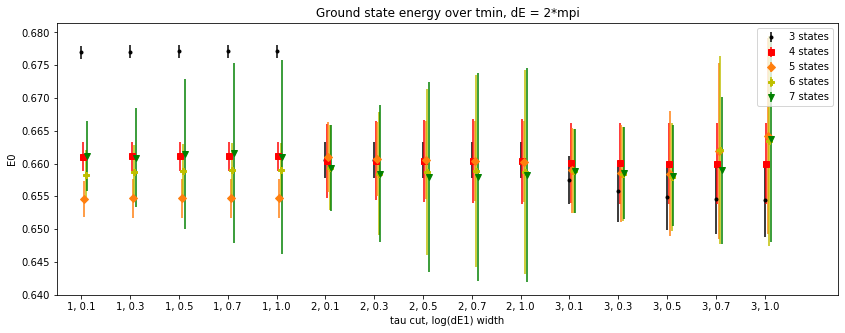

<Figure size 432x288 with 0 Axes>

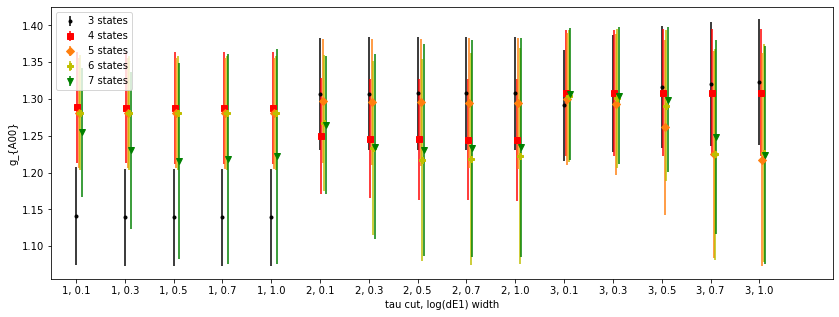

<Figure size 432x288 with 0 Axes>

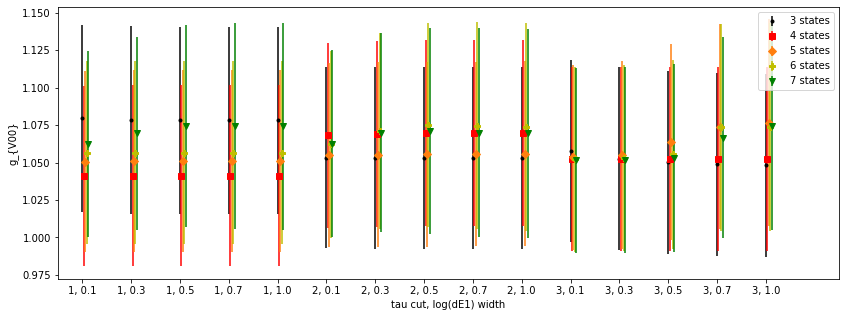

<Figure size 432x288 with 0 Axes>

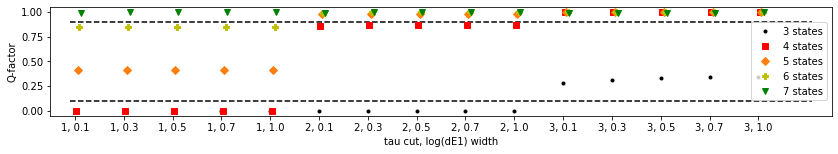

<Figure size 432x288 with 0 Axes>

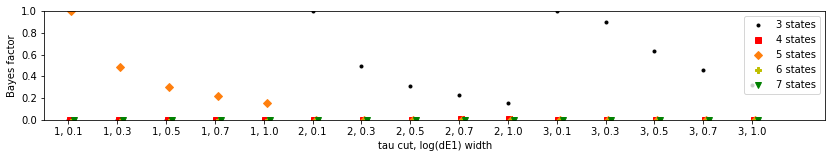

<Figure size 432x288 with 0 Axes>

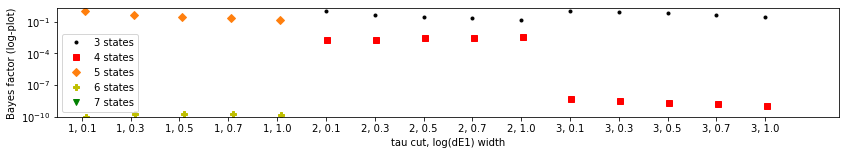

In [185]:
# First, define colors, markers, and legend labels to be used for each number of states
ax_markers = np.array(['.', 's', 'D', 'P', 'v', 'h', 'X', '^'])
ax_colors = np.array(['k', 'r', 'tab:orange', 'y', 'g', 'b', 'tab:purple', 'c'])
ax_labels = np.array(["3 states", "4 states", "5 states", "6 states", "7 states"])





# Set an x-array to map the results to the graph
ax_ensemble_to_x_map = np.arange(0, 15, 1)
xticlocs = np.arange(0, 15, 1)
xticklabels = np.array(["1, 0.1", \
                        "1, 0.3", \
                        "1, 0.5", \
                        "1, 0.7", \
                        "1, 1.0", \
                        "2, 0.1", \
                        "2, 0.3", \
                        "2, 0.5", \
                        "2, 0.7", \
                        "2, 1.0", \
                        "3, 0.1", \
                        "3, 0.3", \
                        "3, 0.5", \
                        "3, 0.7", \
                        "3, 1.0"])



# Now create an "upper bound" and "lower bound" plot on Q
samp_line = np.linspace(-0.1,15.1,500)
Q_01_line = np.linspace(0.1,0.1,500)
Q_09_line = np.linspace(0.9,0.9,500)

# Next, create the figure
#E0
plt.figure(figsize = (14,5))
plt.xlim([-0.5, 15.5])
plt.xticks(ticks = xticlocs, labels=xticklabels)
plt.xlabel("tau cut, log(dE1) width")

# Now loop over the number of states used in 3-point
for k in range(len(n_z_vals)):
    plt.errorbar(ax_ensemble_to_x_map + k*0.03, [E0_a0_graph[i][k*2].mean for i in range(len(ax_ensemble_to_x_map))], yerr = [E0_a0_graph[i][k*2].sdev for i in range(len(ax_ensemble_to_x_map))], fmt='.', marker = ax_markers[k], color = ax_colors[k], label = ax_labels[k])
    
plt.title("Ground state energy over tmin, dE = 2*mpi")
plt.ylabel("E0")

plt.legend()
plt.show()

plt.clf()

# Next, create the figure
#gA00
plt.figure(figsize = (14,5))
plt.xlim([-0.5, 15.5])
plt.xticks(ticks = xticlocs, labels=xticklabels)
plt.xlabel("tau cut, log(dE1) width")

for k in range(len(n_z_vals)):
    plt.errorbar(ax_ensemble_to_x_map + k*0.03, [gA00_a0_graph[i][k*2].mean for i in range(len(ax_ensemble_to_x_map))], yerr = [gA00_a0_graph[i][k*2].sdev for i in range(len(ax_ensemble_to_x_map))], fmt='.', marker = ax_markers[k], color = ax_colors[k], label = ax_labels[k])
    
plt.legend()
plt.ylabel("g_{A00}")
plt.show()

plt.clf()

# Next, create the figure
#gV00
plt.figure(figsize = (14,5))
plt.xlim([-0.5, 15.5])
plt.xticks(ticks = xticlocs, labels=xticklabels)
plt.xlabel("tau cut, log(dE1) width")

for k in range(len(n_z_vals)):
    plt.errorbar(ax_ensemble_to_x_map + k*0.03, [gV00_a0_graph[i][k*2].mean for i in range(len(ax_ensemble_to_x_map))], yerr = [gV00_a0_graph[i][k*2].sdev for i in range(len(ax_ensemble_to_x_map))], fmt='.', marker = ax_markers[k], color = ax_colors[k], label = ax_labels[k])
    
plt.legend()
plt.ylabel("g_{V00}")
plt.show()

plt.clf()

# Next, create the figure
#Q-factor
plt.figure(figsize = (14,2))
plt.xlim([-0.5, 15.5])
plt.xticks(ticks = xticlocs, labels=xticklabels)
plt.xlabel("tau cut, log(dE1) width")

for k in range(len(n_z_vals)):
    plt.errorbar(ax_ensemble_to_x_map + k*0.03, [Q_a0_graph[i][k*2] for i in range(len(ax_ensemble_to_x_map))], fmt='.', marker = ax_markers[k], color = ax_colors[k], label = ax_labels[k])
plt.plot(samp_line, Q_01_line, "k--")
plt.plot(samp_line, Q_09_line, "k--")
    
plt.legend()
plt.ylabel("Q-factor")
plt.show()

plt.clf()

# Next, create the figure
#Bayes factor
plt.figure(figsize = (14,2))
plt.xlim([-0.5, 15.5])
plt.xticks(ticks = xticlocs, labels=xticklabels)
plt.xlabel("tau cut, log(dE1) width")

for k in range(len(n_z_vals)):
    plt.errorbar(ax_ensemble_to_x_map + k*0.03, [BF_a0_graph[i][k*2] for i in range(len(ax_ensemble_to_x_map))], fmt='.', marker = ax_markers[k], color = ax_colors[k], label = ax_labels[k])

plt.ylim(0, 1.00)
    
plt.legend()
plt.ylabel("Bayes factor")
plt.show()

plt.clf()

# Next, create the figure
#Bayes factor
plt.figure(figsize = (14,2))
plt.xlim([-0.5, 15.5])
plt.xticks(ticks = xticlocs, labels=xticklabels)
plt.xlabel("tau cut, log(dE1) width")

for k in range(len(n_z_vals)):
    plt.semilogy(ax_ensemble_to_x_map + k*0.03, [BF_a0_graph[i][k*2] for i in range(len(ax_ensemble_to_x_map))], '.', marker = ax_markers[k], color = ax_colors[k], label = ax_labels[k])
    #plt.semilogy(tmin+ i*0.03, [BF_tmin_bmax_a1[i][k] for k in range(len(tmin))], '.', marker = a1_markers[i], color = a1_colors[i], label = "{0} excited states".format(np.min(num_fitsamples) + i))
    
plt.ylim(1e-10, 2.00)
    
plt.legend()
plt.ylabel("Bayes factor (log-plot)")
plt.show()

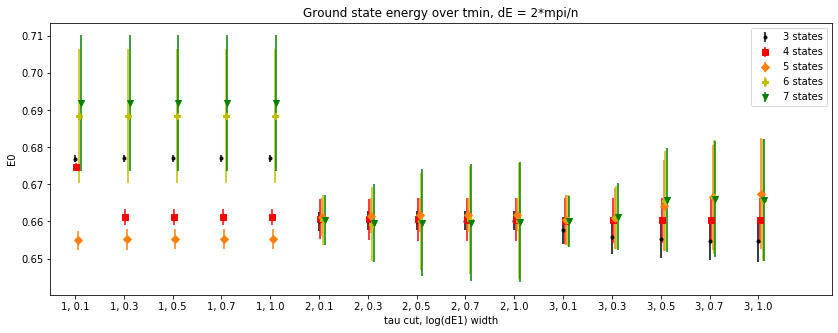

<Figure size 432x288 with 0 Axes>

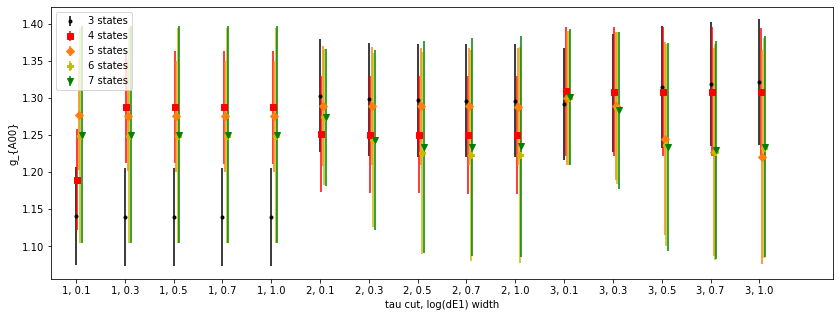

<Figure size 432x288 with 0 Axes>

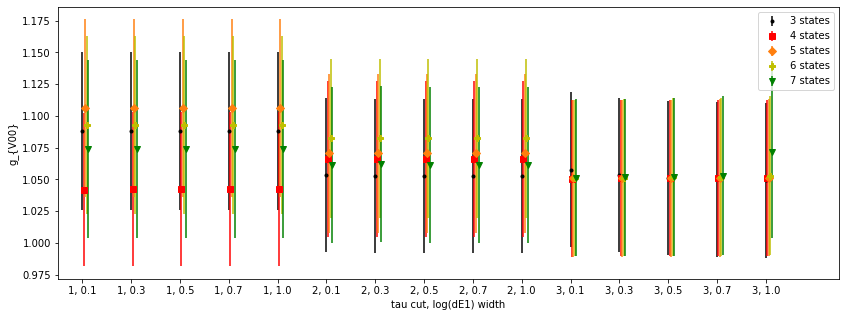

<Figure size 432x288 with 0 Axes>

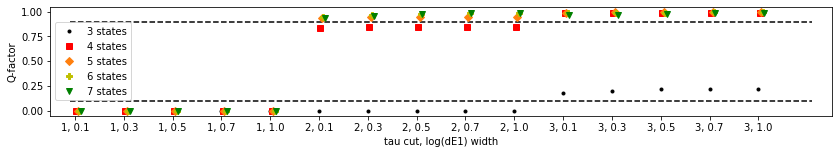

<Figure size 432x288 with 0 Axes>

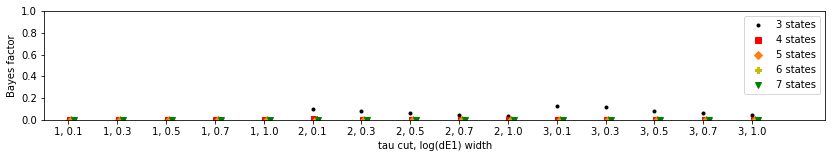

<Figure size 432x288 with 0 Axes>

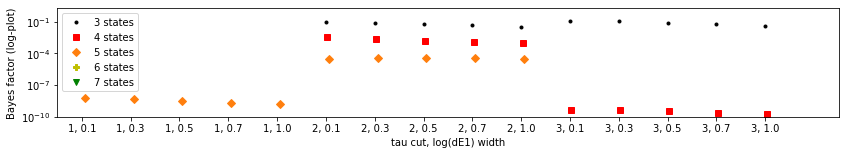

In [186]:
# Now, 1/n
# Next, create the figure
#E0
plt.figure(figsize = (14,5))
plt.xlim([-0.5, 15.5])
plt.xticks(ticks = xticlocs, labels=xticklabels)
plt.xlabel("tau cut, log(dE1) width")

# Now loop over the number of states used in 3-point
for k in range(len(n_z_vals)):
    plt.errorbar(ax_ensemble_to_x_map + k*0.03, [E0_a1_graph[i][k*2].mean for i in range(len(ax_ensemble_to_x_map))], yerr = [E0_a1_graph[i][k*2].sdev for i in range(len(ax_ensemble_to_x_map))], fmt='.', marker = ax_markers[k], color = ax_colors[k], label = ax_labels[k])
    
plt.title("Ground state energy over tmin, dE = 2*mpi/n")
plt.ylabel("E0")

plt.legend()
plt.show()

plt.clf()

# Next, create the figure
#gA00
plt.figure(figsize = (14,5))
plt.xlim([-0.5, 15.5])
plt.xticks(ticks = xticlocs, labels=xticklabels)
plt.xlabel("tau cut, log(dE1) width")

for k in range(len(n_z_vals)):
    plt.errorbar(ax_ensemble_to_x_map + k*0.03, [gA00_a1_graph[i][k*2].mean for i in range(len(ax_ensemble_to_x_map))], yerr = [gA00_a1_graph[i][k*2].sdev for i in range(len(ax_ensemble_to_x_map))], fmt='.', marker = ax_markers[k], color = ax_colors[k], label = ax_labels[k])
    
plt.legend()
plt.ylabel("g_{A00}")
plt.show()

plt.clf()

# Next, create the figure
#gV00
plt.figure(figsize = (14,5))
plt.xlim([-0.5, 15.5])
plt.xticks(ticks = xticlocs, labels=xticklabels)
plt.xlabel("tau cut, log(dE1) width")

for k in range(len(n_z_vals)):
    plt.errorbar(ax_ensemble_to_x_map + k*0.03, [gV00_a1_graph[i][k*2].mean for i in range(len(ax_ensemble_to_x_map))], yerr = [gV00_a1_graph[i][k*2].sdev for i in range(len(ax_ensemble_to_x_map))], fmt='.', marker = ax_markers[k], color = ax_colors[k], label = ax_labels[k])
    
plt.legend()
plt.ylabel("g_{V00}")
plt.show()

plt.clf()

# Next, create the figure
#Q-factor
plt.figure(figsize = (14,2))
plt.xlim([-0.5, 15.5])
plt.xticks(ticks = xticlocs, labels=xticklabels)
plt.xlabel("tau cut, log(dE1) width")

for k in range(len(n_z_vals)):
    plt.errorbar(ax_ensemble_to_x_map + k*0.03, [Q_a1_graph[i][k*2] for i in range(len(ax_ensemble_to_x_map))], fmt='.', marker = ax_markers[k], color = ax_colors[k], label = ax_labels[k])
plt.plot(samp_line, Q_01_line, "k--")
plt.plot(samp_line, Q_09_line, "k--")
    
plt.legend()
plt.ylabel("Q-factor")
plt.show()

plt.clf()

# Next, create the figure
#Bayes factor
plt.figure(figsize = (14,2))
plt.xlim([-0.5, 15.5])
plt.xticks(ticks = xticlocs, labels=xticklabels)
plt.xlabel("tau cut, log(dE1) width")

for k in range(len(n_z_vals)):
    plt.errorbar(ax_ensemble_to_x_map + k*0.03, [BF_a1_graph[i][k*2] for i in range(len(ax_ensemble_to_x_map))], fmt='.', marker = ax_markers[k], color = ax_colors[k], label = ax_labels[k])

plt.ylim(0, 1.00)
    
plt.legend()
plt.ylabel("Bayes factor")
plt.show()

plt.clf()

# Next, create the figure
#Bayes factor
plt.figure(figsize = (14,2))
plt.xlim([-0.5, 15.5])
plt.xticks(ticks = xticlocs, labels=xticklabels)
plt.xlabel("tau cut, log(dE1) width")

for k in range(len(n_z_vals)):
    plt.semilogy(ax_ensemble_to_x_map + k*0.03, [BF_a1_graph[i][k*2] for i in range(len(ax_ensemble_to_x_map))], '.', marker = ax_markers[k], color = ax_colors[k], label = ax_labels[k])
    #plt.semilogy(tmin+ i*0.03, [BF_tmin_bmax_a1[i][k] for k in range(len(tmin))], '.', marker = a1_markers[i], color = a1_colors[i], label = "{0} excited states".format(np.min(num_fitsamples) + i))
    
plt.ylim(1e-10, 2.00)
    
plt.legend()
plt.ylabel("Bayes factor (log-plot)")
plt.show()

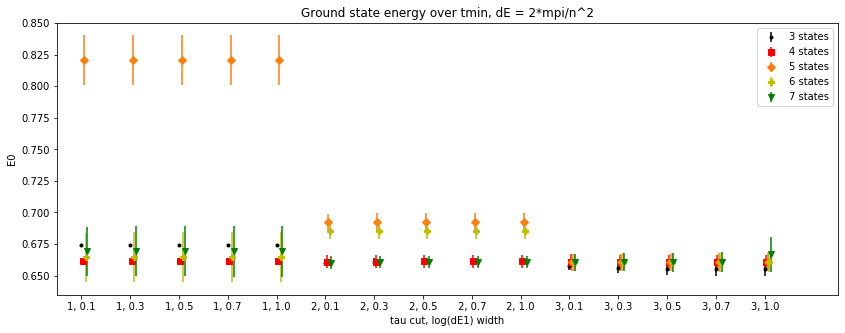

<Figure size 432x288 with 0 Axes>

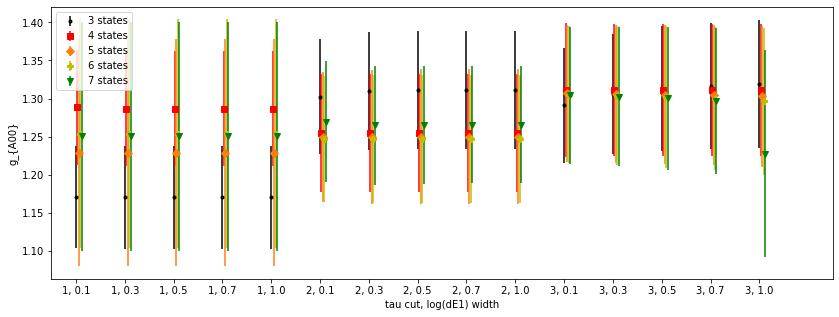

<Figure size 432x288 with 0 Axes>

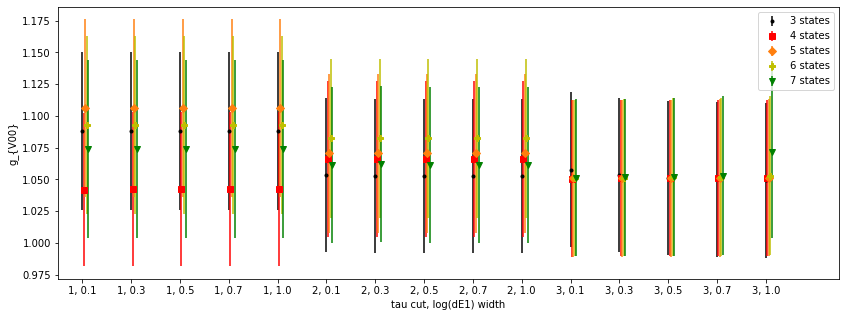

<Figure size 432x288 with 0 Axes>

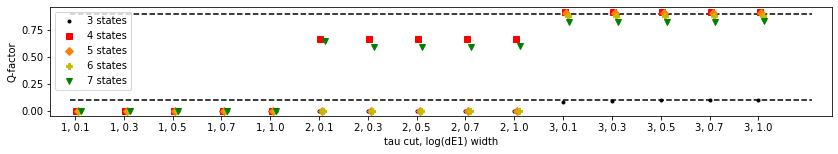

<Figure size 432x288 with 0 Axes>

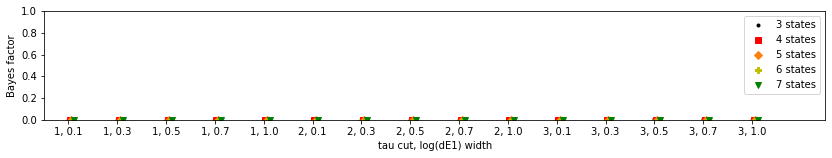

<Figure size 432x288 with 0 Axes>

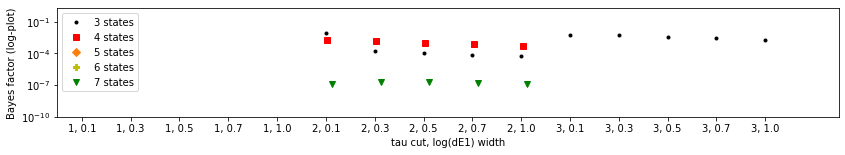

In [190]:
# Now, 1/n^2
# Next, create the figure
#E0
plt.figure(figsize = (14,5))
plt.xlim([-0.5, 15.5])
plt.xticks(ticks = xticlocs, labels=xticklabels)
plt.xlabel("tau cut, log(dE1) width")

# Now loop over the number of states used in 3-point
for k in range(len(n_z_vals)):
    plt.errorbar(ax_ensemble_to_x_map + k*0.03, [E0_a2_graph[i][k*2].mean for i in range(len(ax_ensemble_to_x_map))], yerr = [E0_a2_graph[i][k*2].sdev for i in range(len(ax_ensemble_to_x_map))], fmt='.', marker = ax_markers[k], color = ax_colors[k], label = ax_labels[k])
    
plt.title("Ground state energy over tmin, dE = 2*mpi/n^2")
plt.ylabel("E0")

plt.legend()
plt.show()

plt.clf()

# Next, create the figure
#gA00
plt.figure(figsize = (14,5))
plt.xlim([-0.5, 15.5])
plt.xticks(ticks = xticlocs, labels=xticklabels)
plt.xlabel("tau cut, log(dE1) width")

for k in range(len(n_z_vals)):
    plt.errorbar(ax_ensemble_to_x_map + k*0.03, [gA00_a2_graph[i][k*2].mean for i in range(len(ax_ensemble_to_x_map))], yerr = [gA00_a2_graph[i][k*2].sdev for i in range(len(ax_ensemble_to_x_map))], fmt='.', marker = ax_markers[k], color = ax_colors[k], label = ax_labels[k])
    
plt.legend()
plt.ylabel("g_{A00}")
plt.show()

plt.clf()

# Next, create the figure
#gV00
plt.figure(figsize = (14,5))
plt.xlim([-0.5, 15.5])
plt.xticks(ticks = xticlocs, labels=xticklabels)
plt.xlabel("tau cut, log(dE1) width")

for k in range(len(n_z_vals)):
    plt.errorbar(ax_ensemble_to_x_map + k*0.03, [gV00_a2_graph[i][k*2].mean for i in range(len(ax_ensemble_to_x_map))], yerr = [gV00_a2_graph[i][k*2].sdev for i in range(len(ax_ensemble_to_x_map))], fmt='.', marker = ax_markers[k], color = ax_colors[k], label = ax_labels[k])
    
plt.legend()
plt.ylabel("g_{V00}")
plt.show()

plt.clf()

# Next, create the figure
#Q-factor
plt.figure(figsize = (14,2))
plt.xlim([-0.5, 15.5])
plt.xticks(ticks = xticlocs, labels=xticklabels)
plt.xlabel("tau cut, log(dE1) width")

for k in range(len(n_z_vals)):
    plt.errorbar(ax_ensemble_to_x_map + k*0.03, [Q_a2_graph[i][k*2] for i in range(len(ax_ensemble_to_x_map))], fmt='.', marker = ax_markers[k], color = ax_colors[k], label = ax_labels[k])
plt.plot(samp_line, Q_01_line, "k--")
plt.plot(samp_line, Q_09_line, "k--")
    
plt.legend()
plt.ylabel("Q-factor")
plt.show()

plt.clf()

# Next, create the figure
#Bayes factor
plt.figure(figsize = (14,2))
plt.xlim([-0.5, 15.5])
plt.xticks(ticks = xticlocs, labels=xticklabels)
plt.xlabel("tau cut, log(dE1) width")

for k in range(len(n_z_vals)):
    plt.errorbar(ax_ensemble_to_x_map + k*0.03, [BF_a2_graph[i][k*2] for i in range(len(ax_ensemble_to_x_map))], fmt='.', marker = ax_markers[k], color = ax_colors[k], label = ax_labels[k])

plt.ylim(0, 1.00)  

plt.legend()
plt.ylabel("Bayes factor")
plt.show()

plt.clf()

# Next, create the figure
#Bayes factor
plt.figure(figsize = (14,2))
plt.xlim([-0.5, 15.5])
plt.xticks(ticks = xticlocs, labels=xticklabels)
plt.xlabel("tau cut, log(dE1) width")

for k in range(len(n_z_vals)):
    plt.semilogy(ax_ensemble_to_x_map + k*0.03, [BF_a2_graph[i][k*2] for i in range(len(ax_ensemble_to_x_map))], '.', marker = ax_markers[k], color = ax_colors[k], label = ax_labels[k])
    #plt.semilogy(tmin+ i*0.03, [BF_tmin_bmax_a1[i][k] for k in range(len(tmin))], '.', marker = a1_markers[i], color = a1_colors[i], label = "{0} excited states".format(np.min(num_fitsamples) + i))
    
plt.ylim(1e-10, 2.00)
    
plt.legend()
plt.ylabel("Bayes factor (log-plot)")
plt.show()